In [1]:
from profiler import *
from collections import defaultdict
import pandas as pd
import numpy as np
from tqdm import tqdm
import os, time, pickle
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [2]:
flat_list= lambda x: [ g for f in x for g in f ]
double_list= lambda x: [[g] for g in x]
split_n= lambda x, n: [x[i:i + n] for i in range(0, len(x), n)]

def smooth_df(runs, cols_names, verbose=False):
    """
        Resume multiple runs in one dataframe
        
        Remove outsamples using median split
        Average results and calculate standard deviation
    """
    count_shapes= defaultdict(lambda:0)
    for r in runs:
        count_shapes[np.shape(r)]+=1
    moda_shape= max(count_shapes,key=count_shapes.get)
    
    if verbose:
        print("Moda shape counts {:.2f}%".format(count_shapes[moda_shape]/sum(count_shapes.values())*100))
        print(count_shapes[moda_shape], sum(count_shapes.values()))
    data_moda= [d for d in runs if np.shape(d) == moda_shape]

    big_l= []
    for r in data_moda:
        big_l.append(np.array(r).reshape(-1))
    big_l= np.asarray(big_l)
    
    med_avg= []
    std_avg= []
    for s in range(big_l.shape[1]):
        el= int(len(big_l[:,s])*0.1)//2
        median= np.sort(big_l[:,s])
        if el: median= median[el:-el]
        med_avg.append(median.mean())
        std_avg.append(median.std())
    
    med_avg= np.asarray(med_avg)
    std_avg= np.asarray(std_avg)
    
    med_avg= pd.DataFrame(med_avg.reshape(moda_shape), columns=cols_names)
    std_avg= pd.DataFrame(std_avg.reshape(moda_shape), columns=cols_names)
    
    
    q= std_avg.values/med_avg.values
    if verbose:
        print("AVG 68% samples error", np.nanmean(q))
        print("AVG 99% stds error", np.nanmean(3*q))
        print("MAX 68% stds error", np.nanmax(q))
        print("MAX 99% stds error", np.nanmax(3*q))
    
    return med_avg, std_avg

## PMCs analysis

In [9]:
programs= os.listdir('hpc_belgica')
huge_df= pd.DataFrame()
for p in tqdm(programs):
    if 'mem' in p: continue
    clusters= ['hpc_belgica/'+p, 'hpc_brasil/'+p, 'pc_lab/'+p]
    clusters_name= ['Belgica', 'Brasil','Lab']
    for c, cname in zip(clusters, clusters_name):
        with open(c,'rb+') as fname:
            data= pickle.load(fname)
        dfs= pd.DataFrame()
        for i, d in enumerate(data['data']):
            df= pd.DataFrame(d, columns=flat_list(data['to_monitor']))
            df['run']= i
            df['program']= p
            dfs= pd.concat([df,dfs])
        dfs['cluster']= cname
        huge_df= pd.concat([dfs,huge_df])
huge_df.to_csv('huge_df.csv')

  0%|          | 0/240 [00:00<?, ?it/s]/home/vitor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

100%|██████████| 240/240 [00:39<00:00,  6.14it/s]


In [3]:
huge_df = pd.read_csv('huge_df.csv')

In [4]:
huge_df.head(5)

Unnamed: 0  PERF_COUNT_HW_BRANCH_INSTRUCTIONS  PERF_COUNT_HW_BRANCH_MISSES  \
0           0                             255755                         7347   
1           1                             255755                         7347   
2           0                             255720                         7401   
3           1                             255720                         7401   
4           0                             255754                         7346   

   PERF_COUNT_HW_CACHE_MISSES  PERF_COUNT_HW_INSTRUCTIONS  \
0                        2044                     2945568   
1                        2044                     2945568   
2                        2139                     2945385   
3                        2139                     2945385   
4                        2305                     2945567   

   PERF_COUNT_SW_CONTEXT_SWITCHES  PERF_COUNT_SW_CPU_CLOCK  \
0                               0                  2355386   
1                               0                  2355386   
2                               0                  2114659   
3                               0                  2114659   
4                               0                  1329972   

   PERF_COUNT_SW_CPU_MIGRATIONS  PERF_COUNT_SW_PAGE_FAULTS  \
0                             0                        102   
1                             0                        102   
2                             0                        100   
3                             0                        100   
4                             0                        102   

   PERF_COUNT_SW_PAGE_FAULTS_MAJ  SYSTEMWIDE:RAPL_ENERGY_CORES  \
0                              0                  1.758200e+09   
1                              0                  1.758200e+09   
2                              0                  2.154824e+09   
3                              0                  2.154824e+09   
4                              0                  3.718775e+09   

   SYSTEMWIDE:RAPL_ENERGY_DRAM  SYSTEMWIDE:RAPL_ENERGY_PKG cluster  \
0                          0.0                4.002546e+09     Lab   
1                          0.0                4.002546e+09     Lab   
2                          0.0                4.394713e+09     Lab   
3                          0.0                4.394713e+09     Lab   
4                          0.0                5.975245e+09     Lab   

                    program  run  
0  gemver_SMALL_DATASET.dat   14  
1  gemver_SMALL_DATASET.dat   14  
2  gemver_SMALL_DATASET.dat   13  
3  gemver_SMALL_DATASET.dat   13  
4  gemver_SMALL_DATASET.dat   12

## Data missing

Index(['PERF_COUNT_HW_BRANCH_INSTRUCTIONS', 'PERF_COUNT_HW_BRANCH_MISSES',
       'PERF_COUNT_HW_CACHE_MISSES', 'PERF_COUNT_HW_INSTRUCTIONS',
       'PERF_COUNT_SW_CONTEXT_SWITCHES', 'PERF_COUNT_SW_CPU_CLOCK',
       'PERF_COUNT_SW_CPU_MIGRATIONS', 'PERF_COUNT_SW_PAGE_FAULTS',
       'PERF_COUNT_SW_PAGE_FAULTS_MAJ', 'SYSTEMWIDE:RAPL_ENERGY_CORES',
       'SYSTEMWIDE:RAPL_ENERGY_DRAM', 'SYSTEMWIDE:RAPL_ENERGY_PKG', 'cluster',
       'program', 'run'],
      dtype='object')

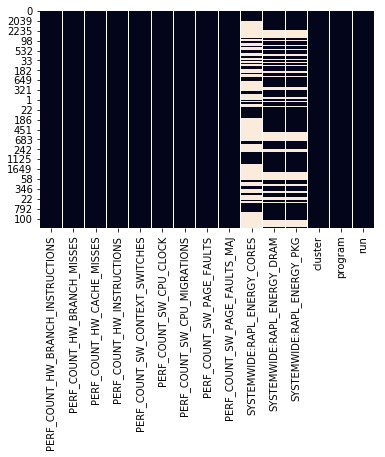

In [151]:
sns.heatmap(huge_df.isnull(), cbar=False)
huge_df.columns

In [5]:
huge_train= huge_df.drop(['SYSTEMWIDE:RAPL_ENERGY_DRAM',
                          'SYSTEMWIDE:RAPL_ENERGY_PKG',
                          'SYSTEMWIDE:RAPL_ENERGY_CORES',
                         'cluster','program','run'],axis=1)
data= scale(huge_train.values)
pca= PCA(n_components=2)
pca.fit(data)
huge_train.columns

print(pca.components_)
counters= pca.transform(data)
df_reduc= pd.DataFrame(counters,columns=['x1','x2'])
df_reduc['cluster']= huge_df['cluster'].values
df_reduc['program']= huge_df['program'].values

/home/vitor/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/vitor/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


[[ 0.46061258  0.45493195  0.2185885   0.29825267  0.45127136 -0.
   0.46082073 -0.          0.16773729 -0.        ]
 [ 0.12674971  0.14977645  0.1557678  -0.58092038  0.17490287  0.
   0.12695954  0.         -0.74367984  0.        ]]


## Per input PCA visualization

/home/vitor/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/vitor/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


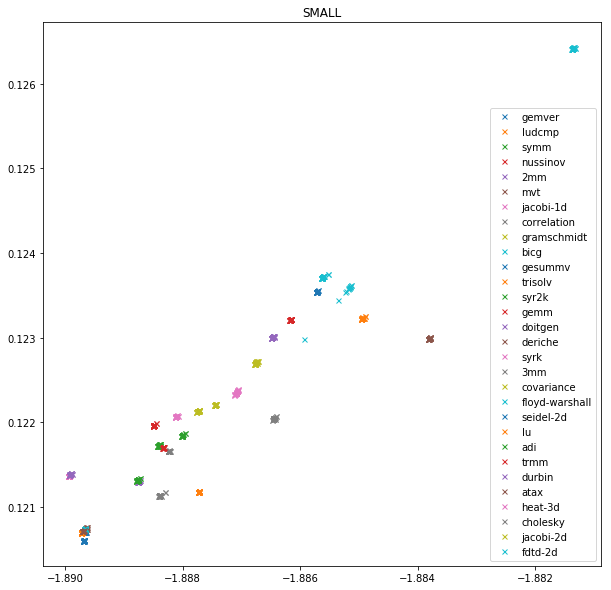

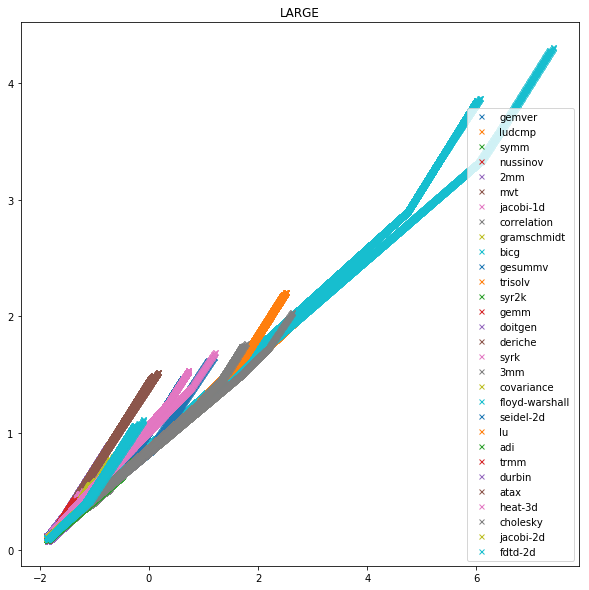

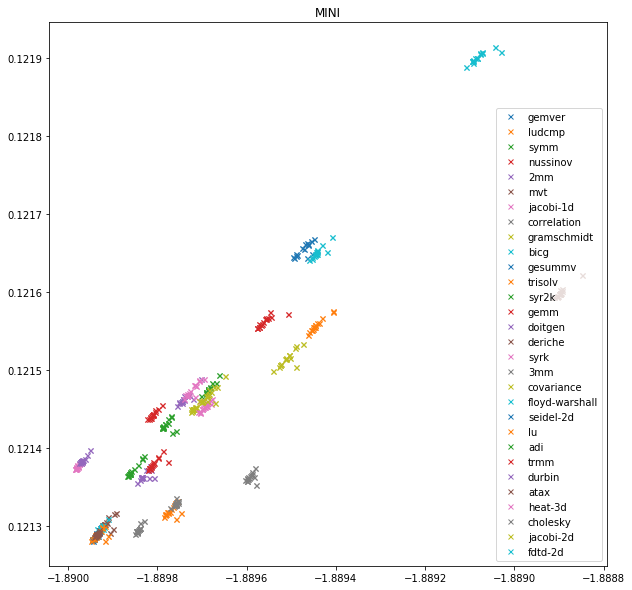

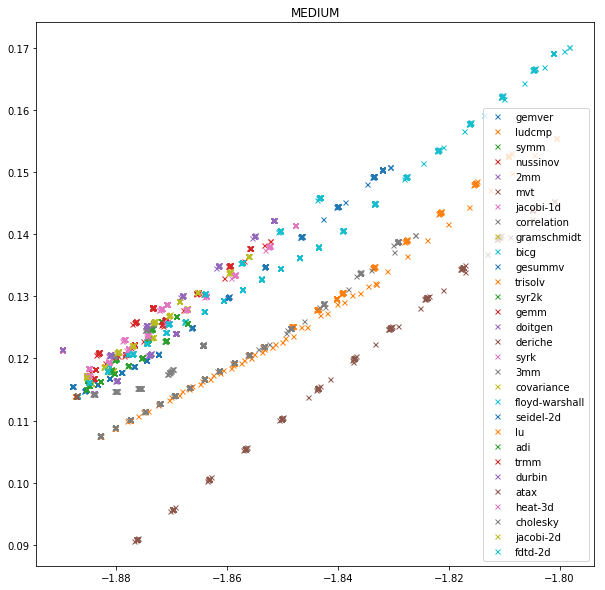

In [249]:
df_reduc['input']= df_reduc['program'].str.split('_',n=2,expand=True)[1]
df_reduc['program']= df_reduc['program'].str.split('_',n=2,expand=True)[0]
df_reduc= df_reduc[df_reduc['cluster']=='Brasil']

for d in df_reduc['input'].unique():
    plt.figure(figsize=(10,10))
    for c in df_reduc['program'].unique():
        aux= df_reduc[ (df_reduc['program']==c)&(df_reduc['input']==d) ][['x1','x2']].values
        plt.plot(aux[:,0],aux[:,1],'x', markersize=5,label=c)
    plt.legend(fontsize=10)
    plt.title(d)

## Per program PCA visualization

/home/vitor/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/vitor/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/vitor/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


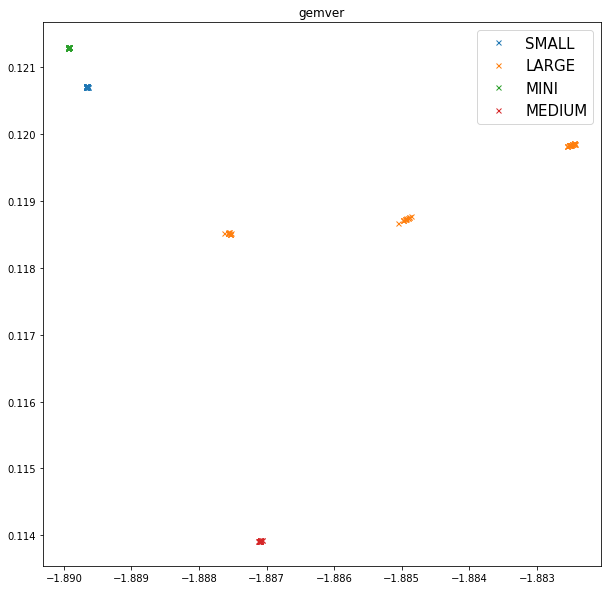

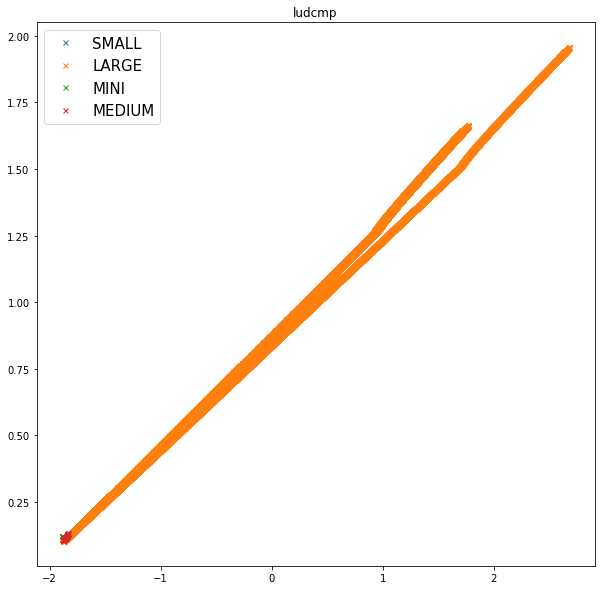

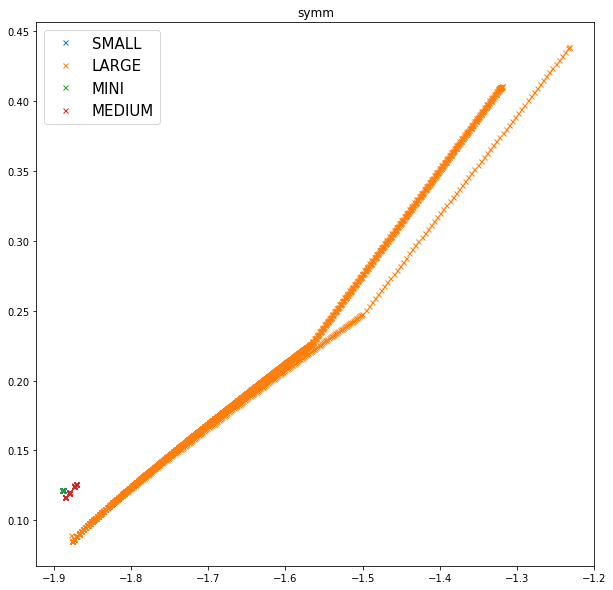

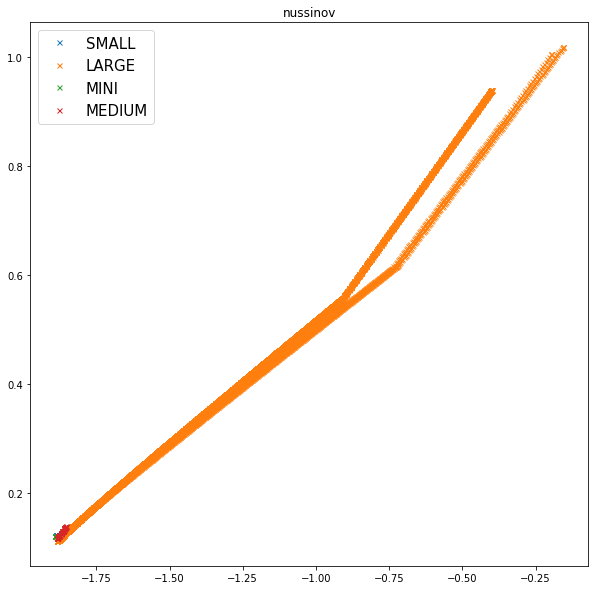

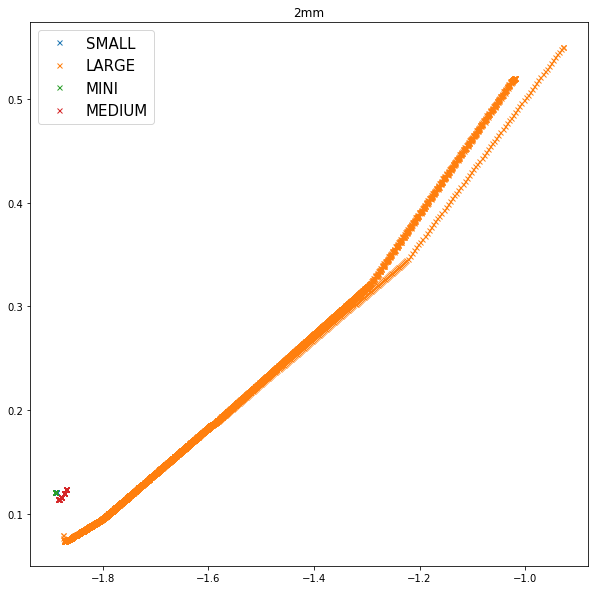

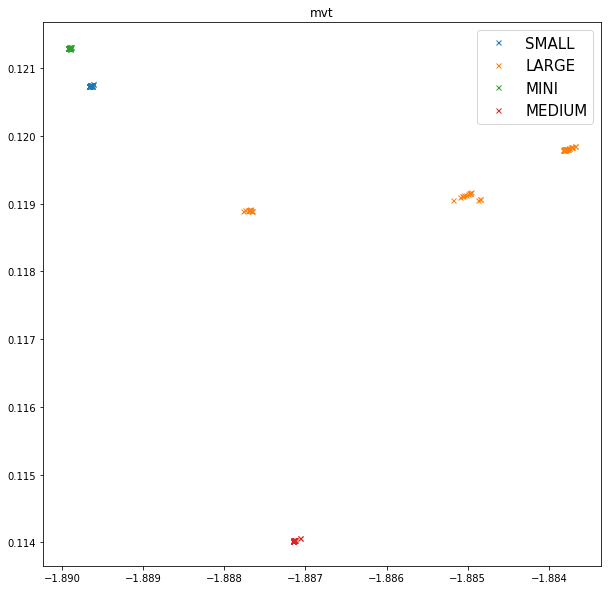

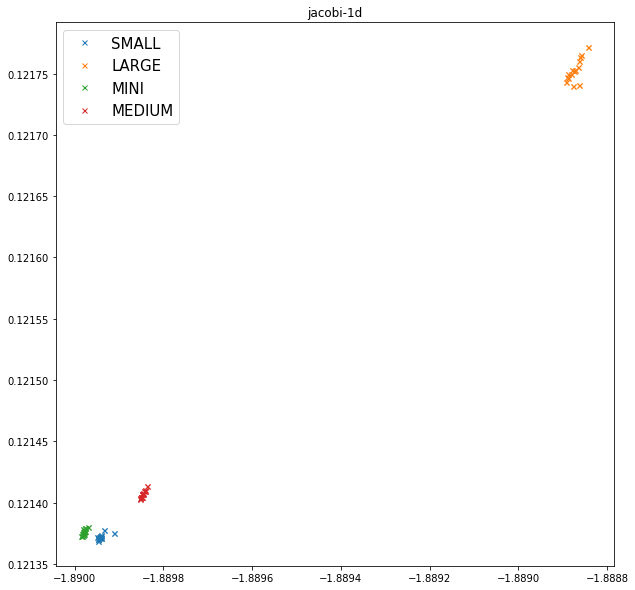

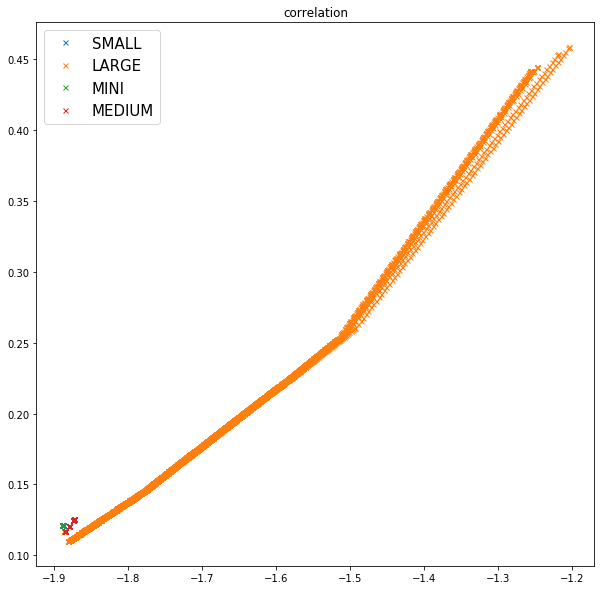

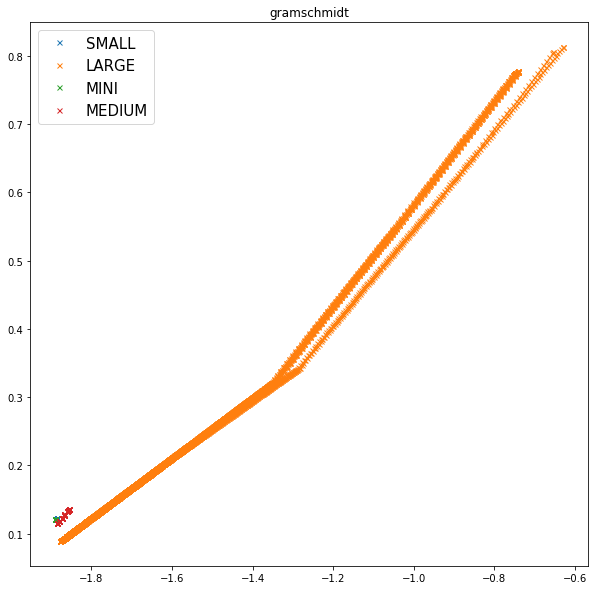

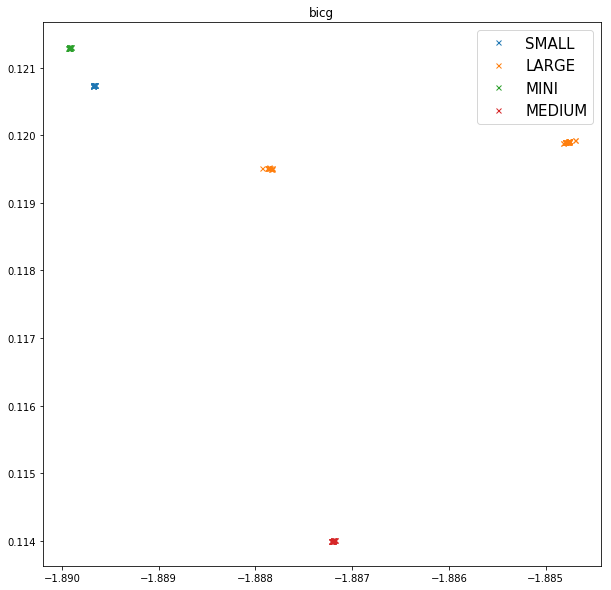

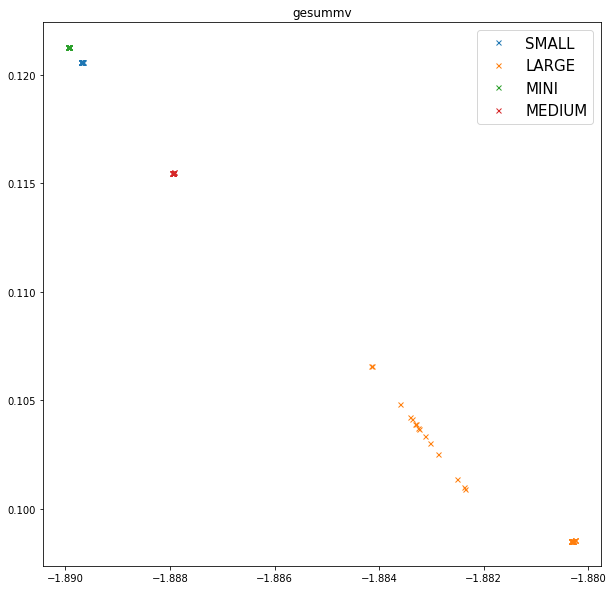

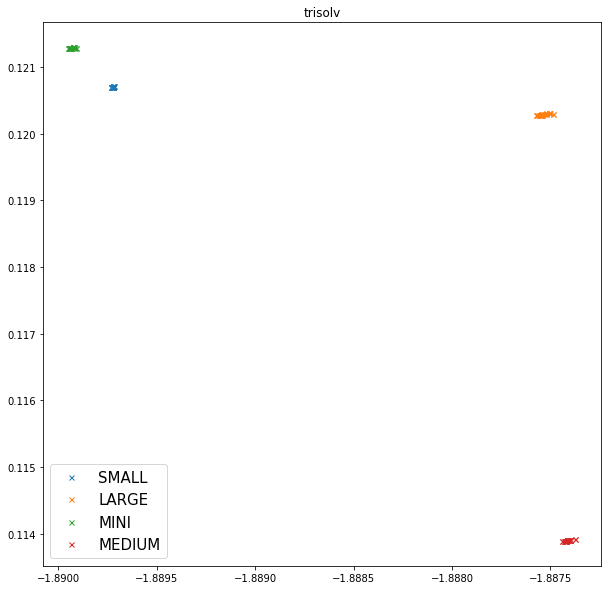

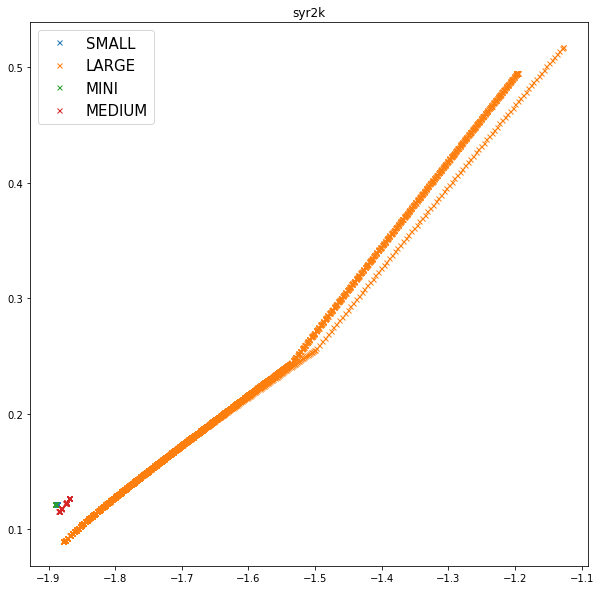

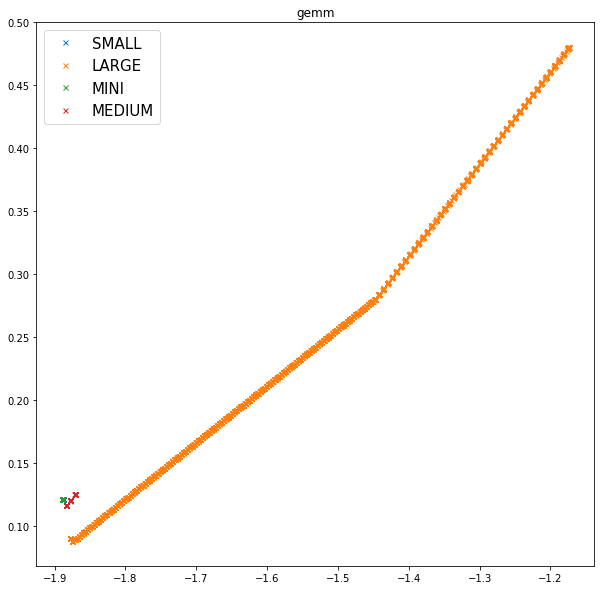

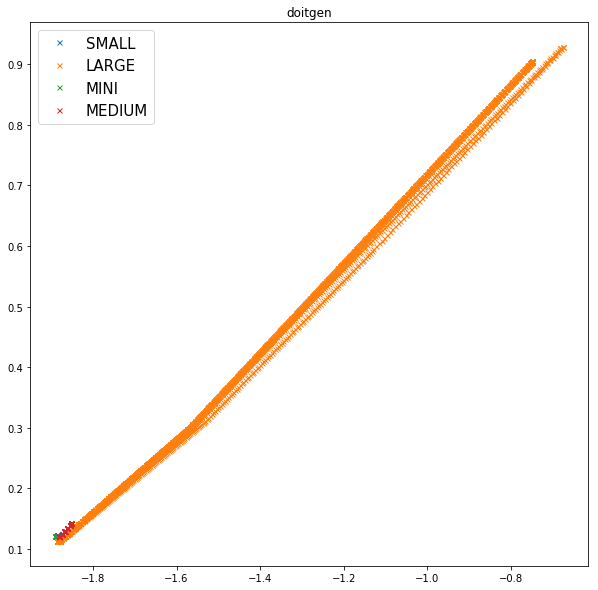

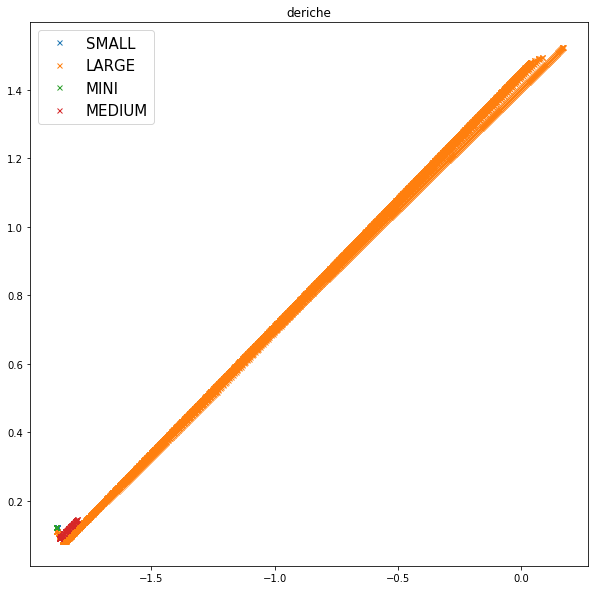

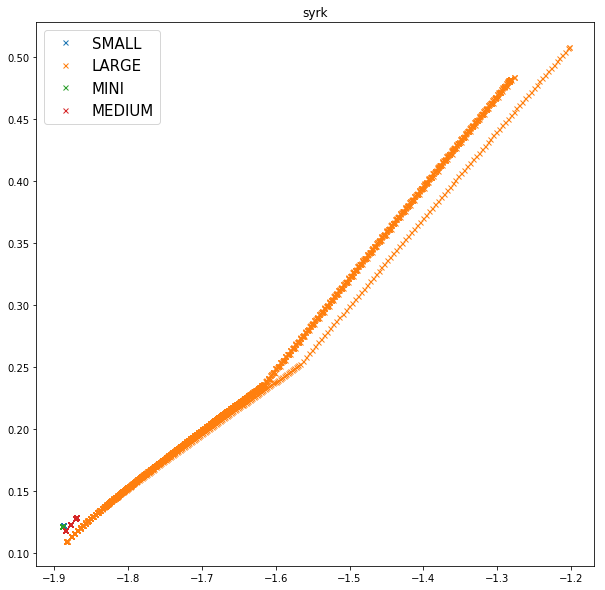

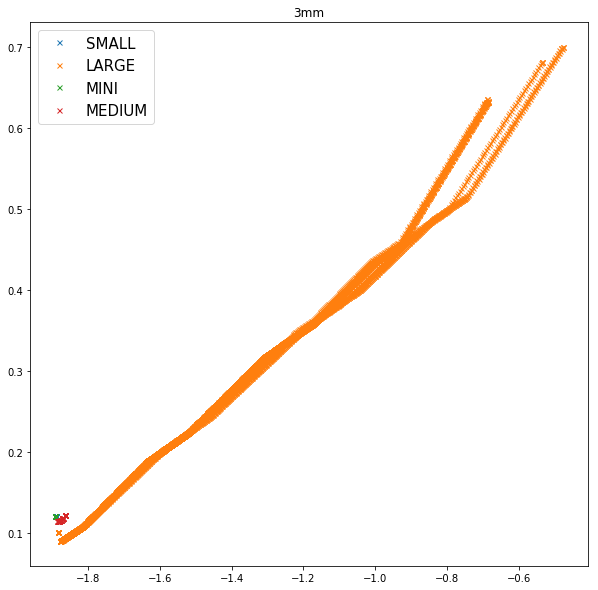

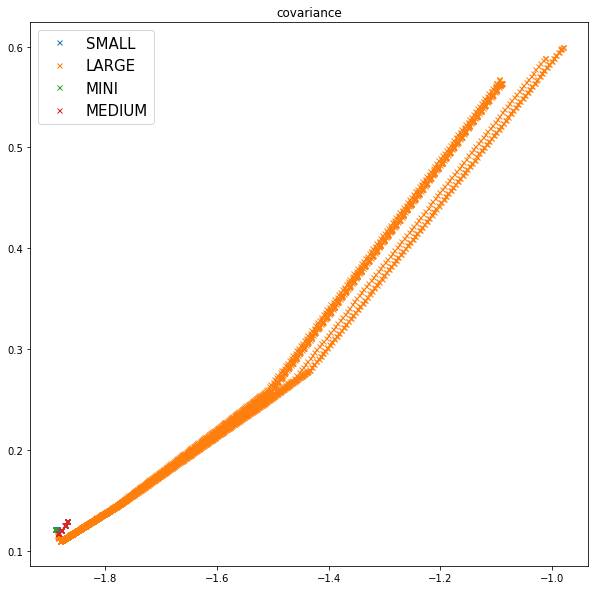

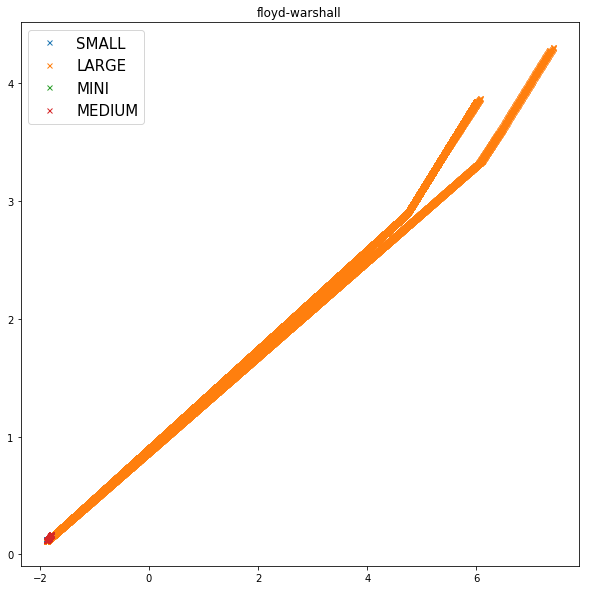

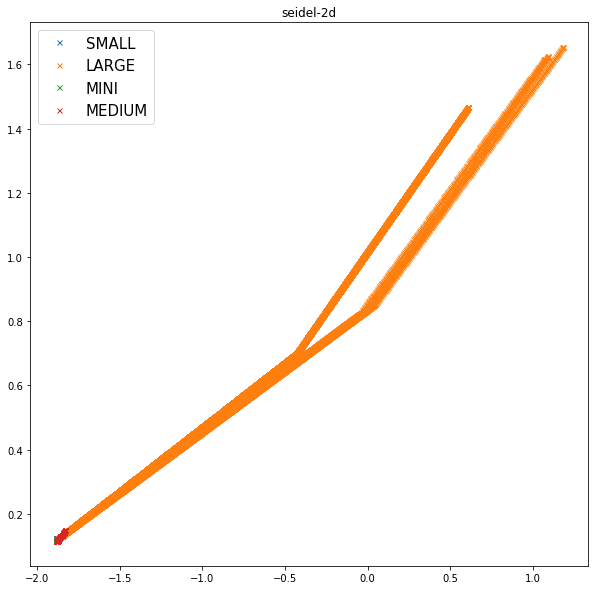

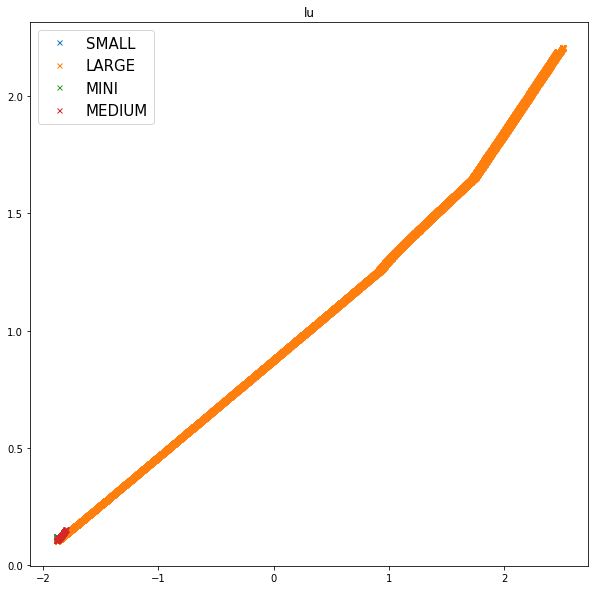

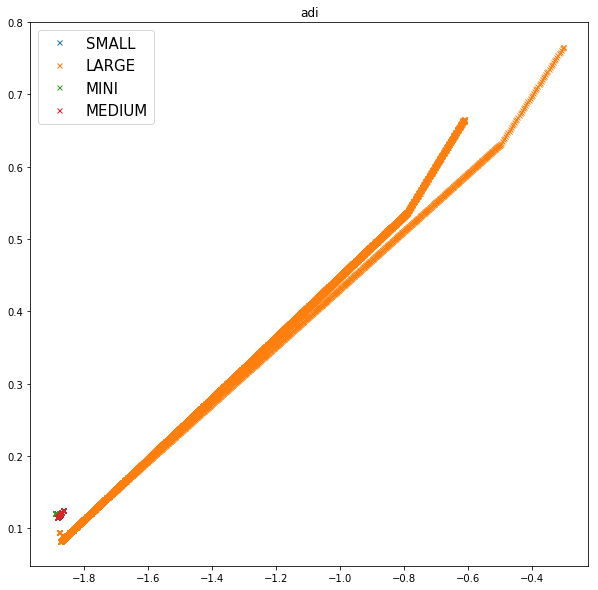

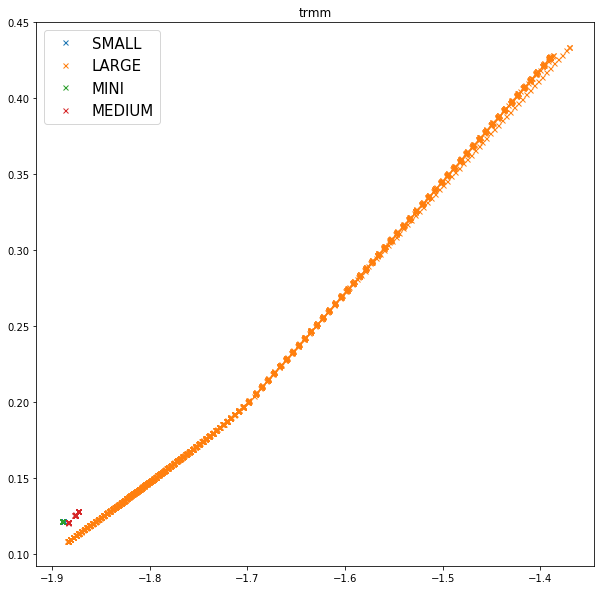

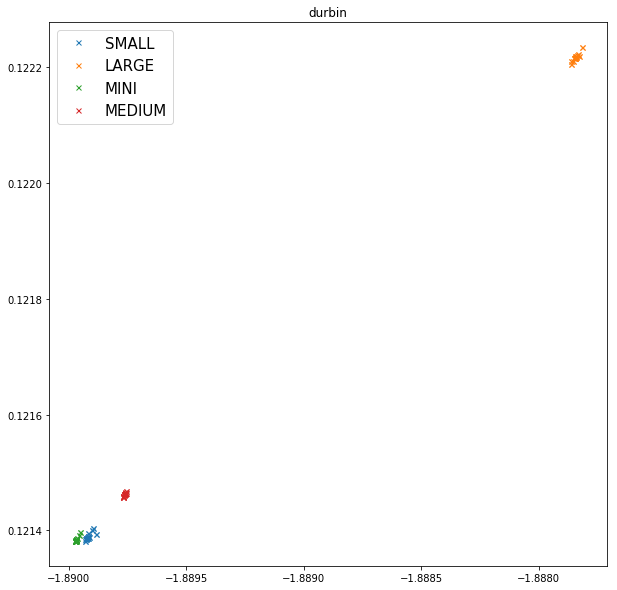

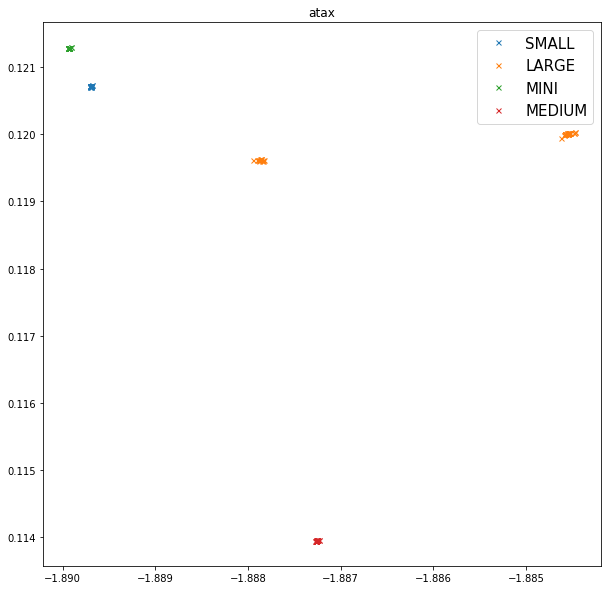

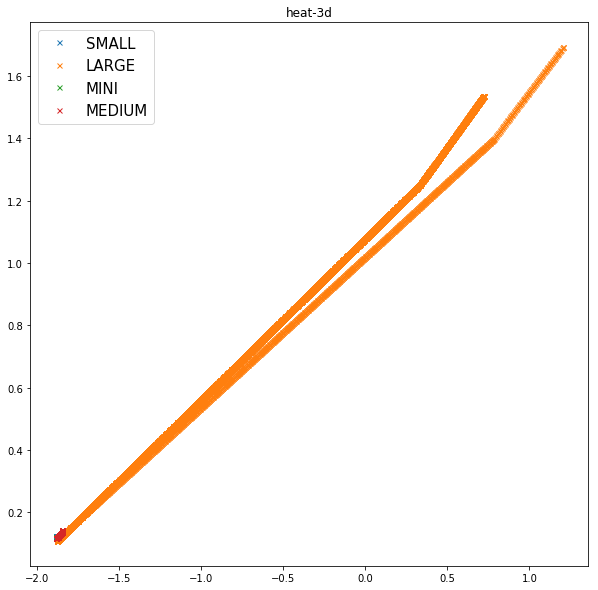

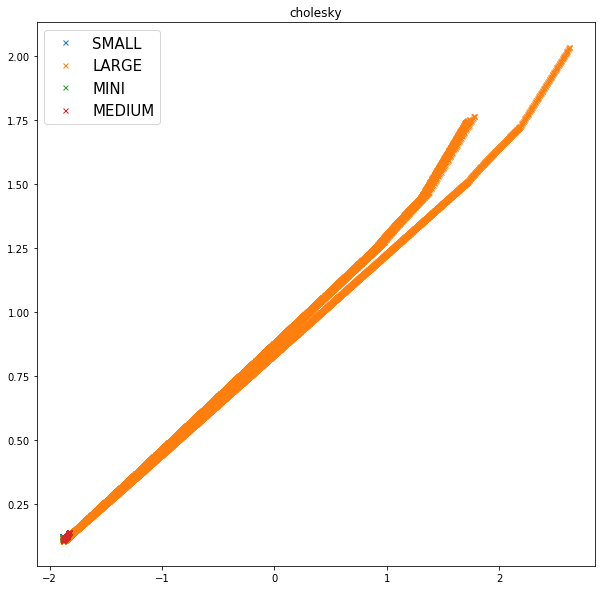

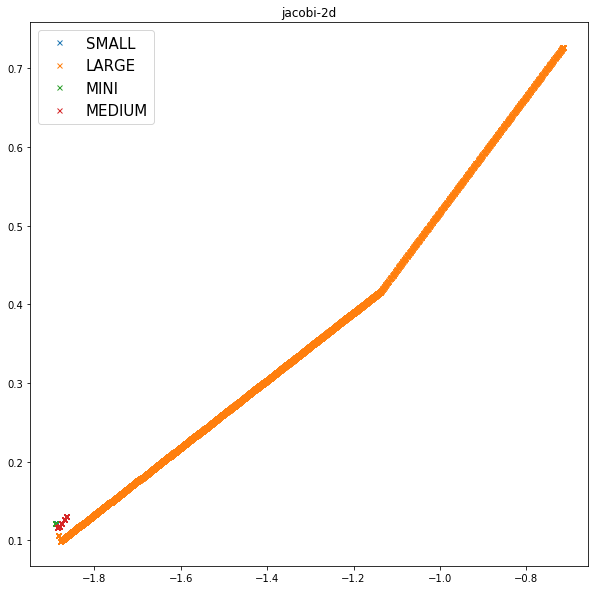

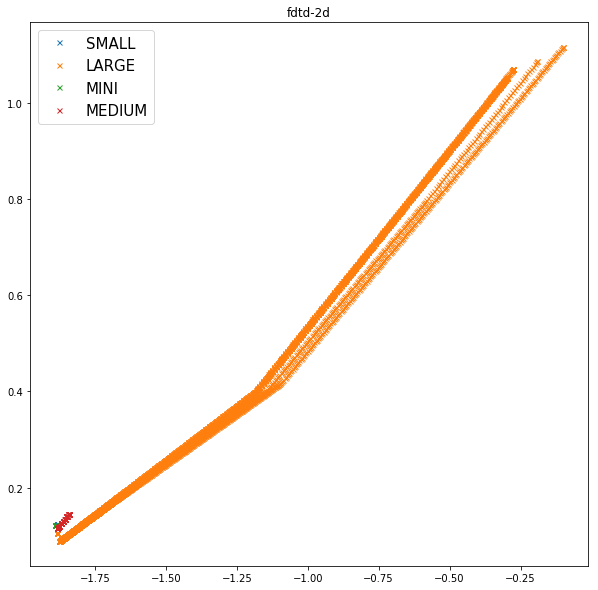

In [243]:
df_reduc['input']= df_reduc['program'].str.split('_',n=2,expand=True)[1]
df_reduc['program']= df_reduc['program'].str.split('_',n=2,expand=True)[0]
df_reduc= df_reduc[df_reduc['cluster']=='Brasil']

for c in df_reduc['program'].unique():
    plt.figure(figsize=(10,10))
    for d in df_reduc['input'].unique():
        aux= df_reduc[ (df_reduc['program']==c)&(df_reduc['input']==d) ][['x1','x2']].values
        plt.plot(aux[:,0],aux[:,1],'x', markersize=5,label=d)
    plt.title(c)
    plt.legend(fontsize=15)

## Per cluster PCA visualization

/home/vitor/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)
/home/vitor/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/vitor/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


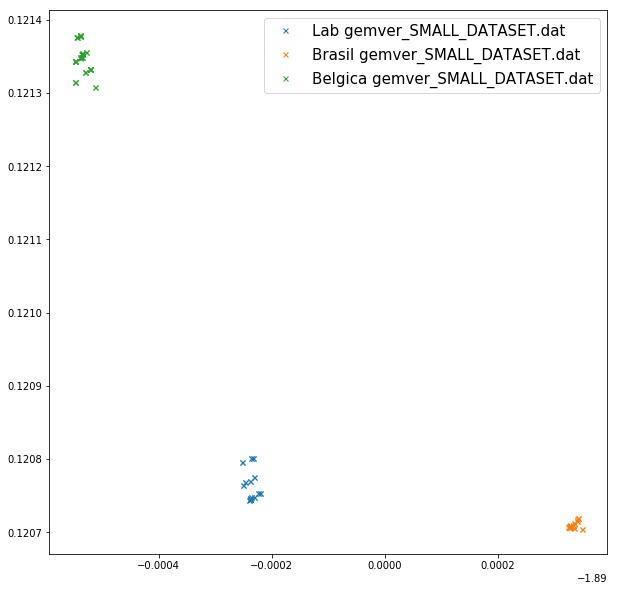

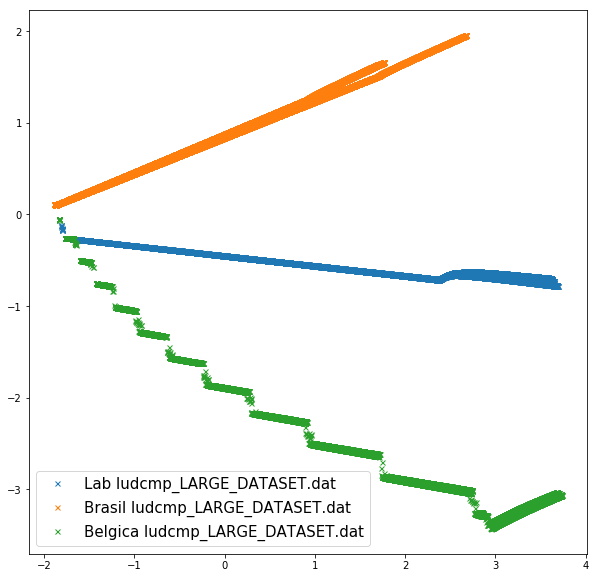

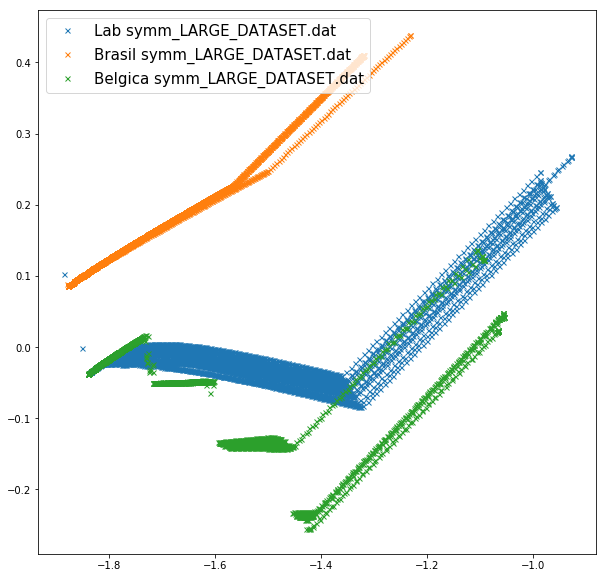

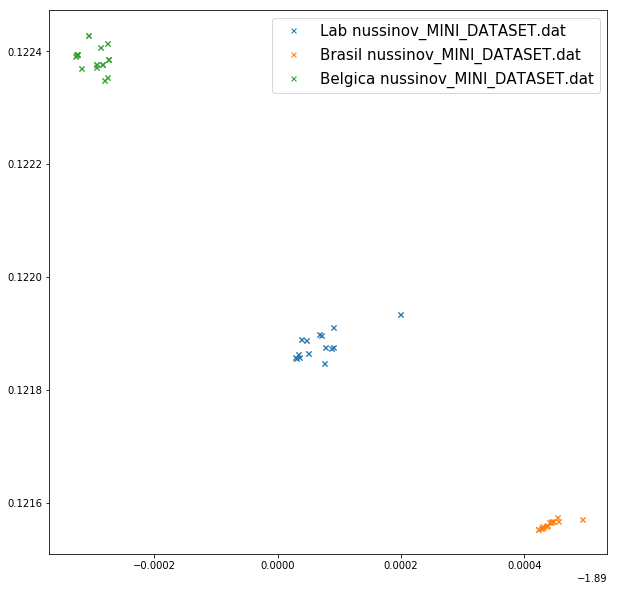

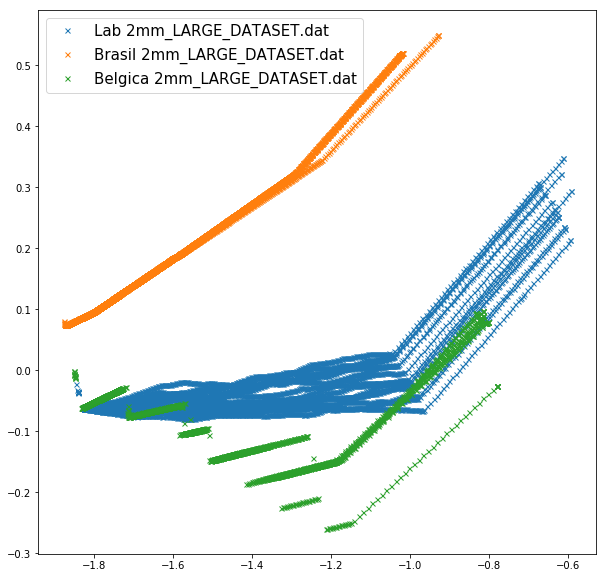

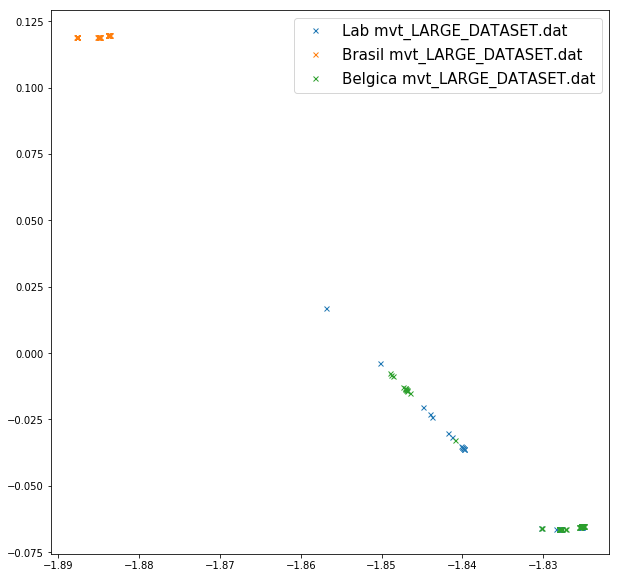

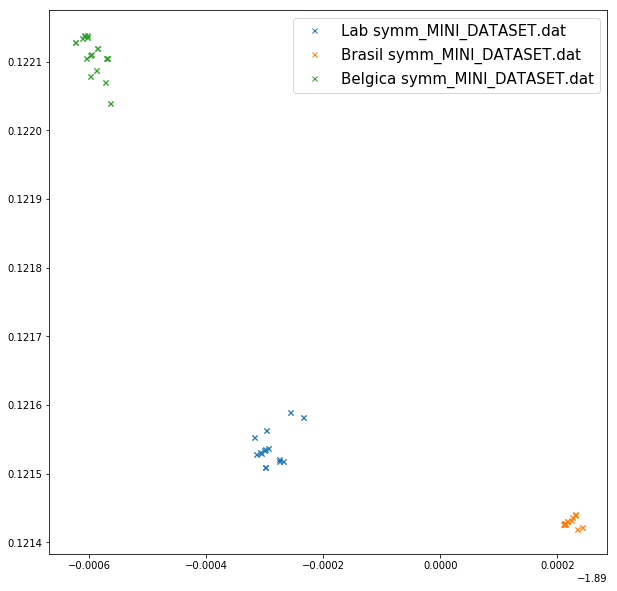

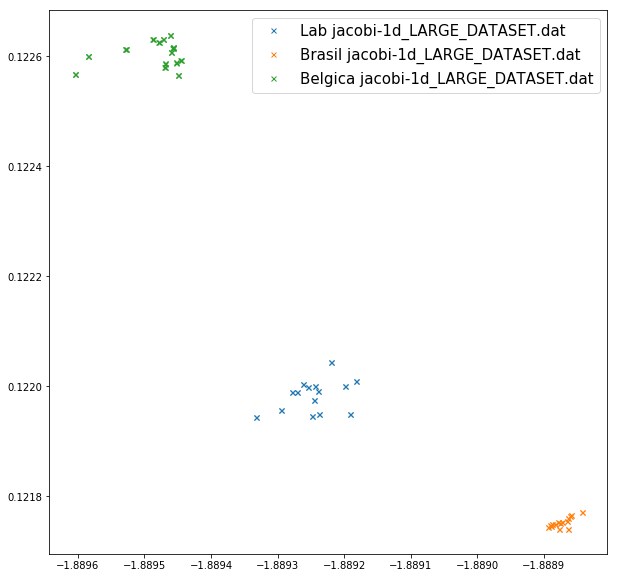

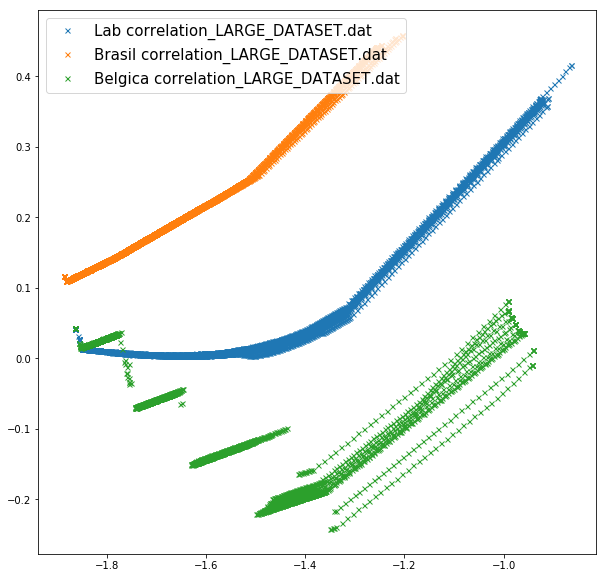

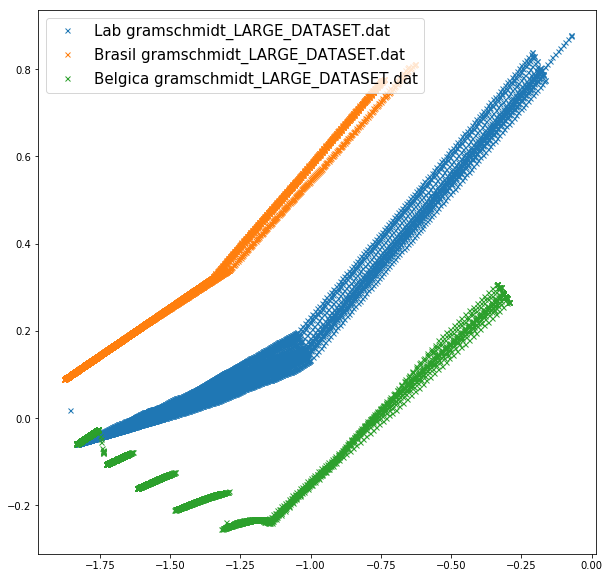

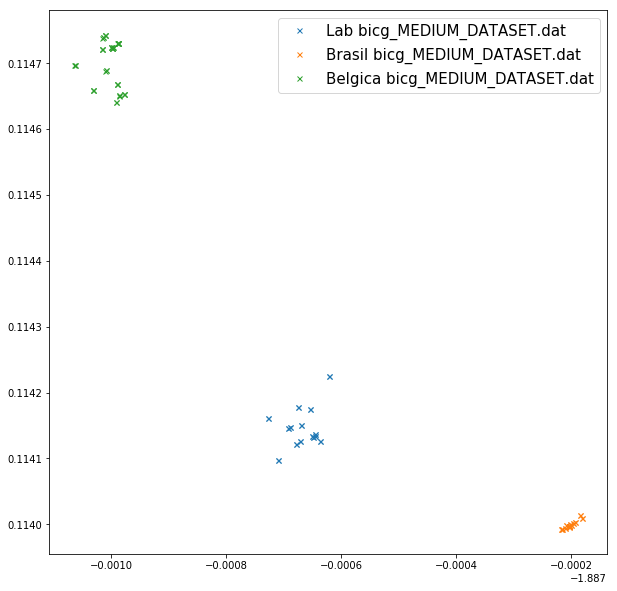

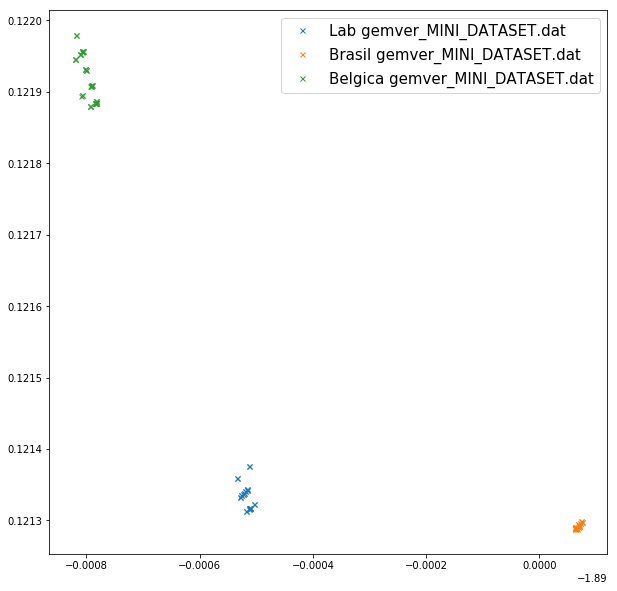

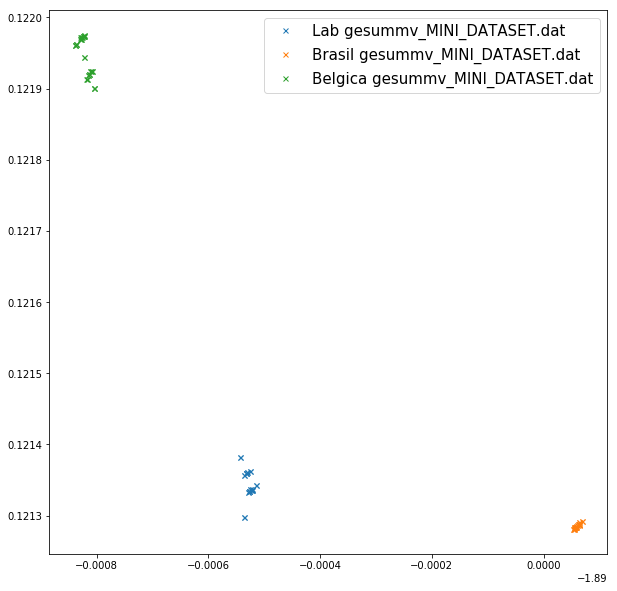

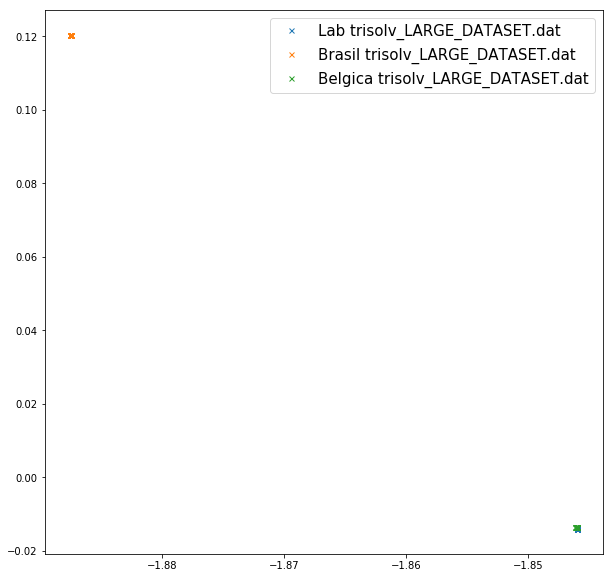

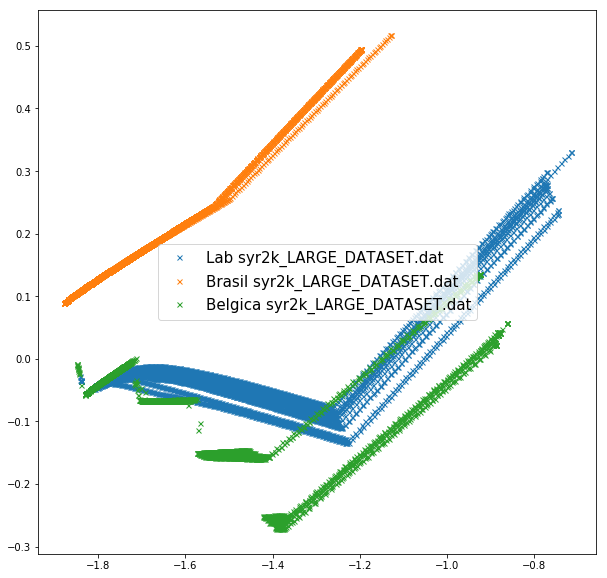

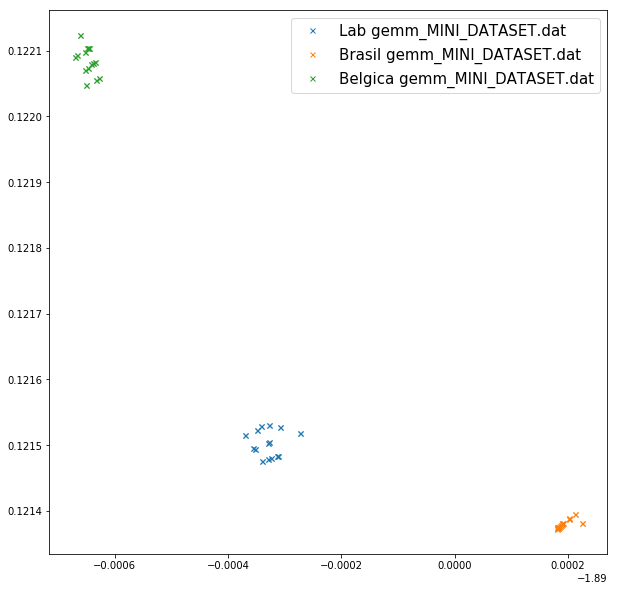

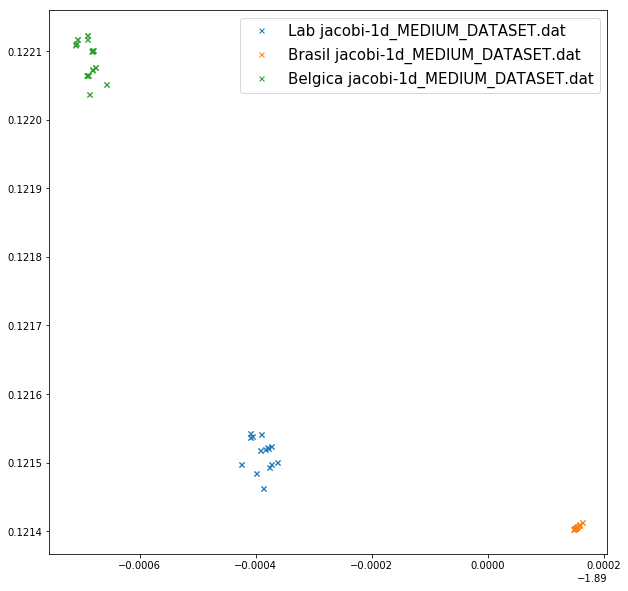

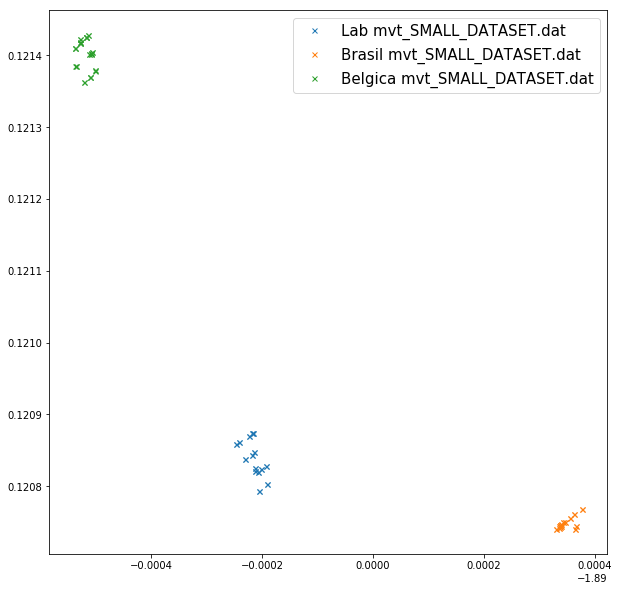

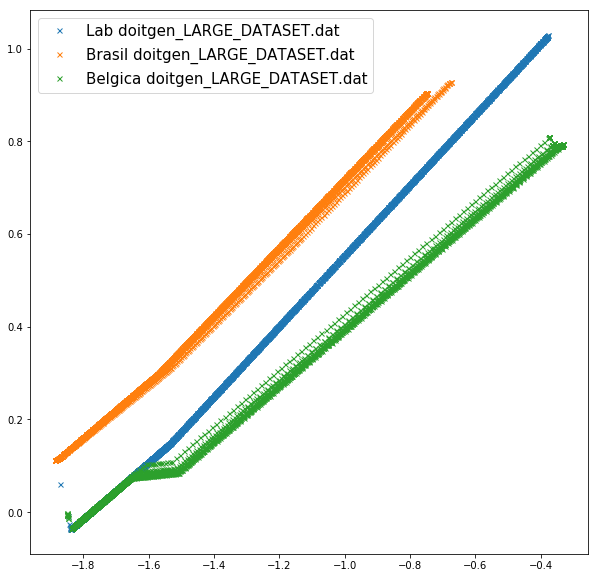

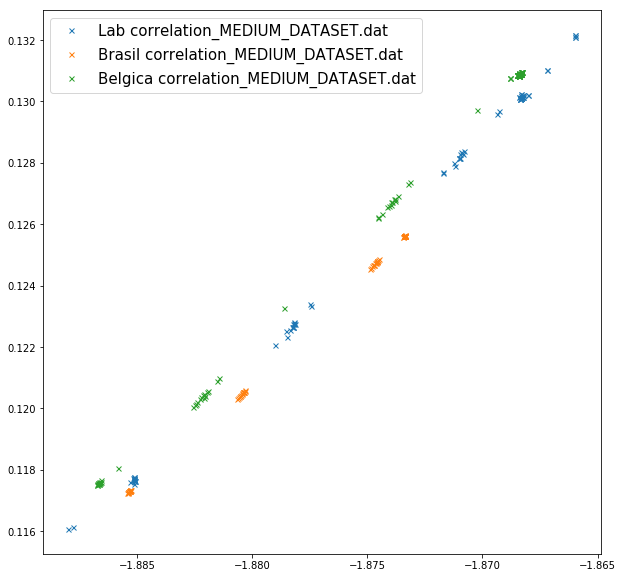

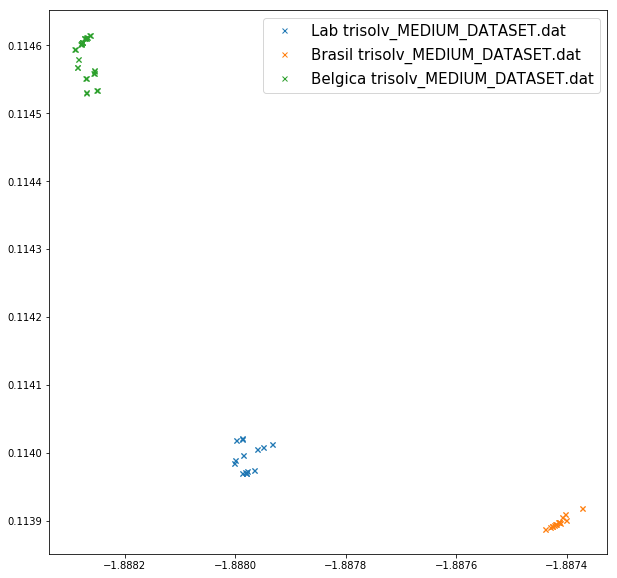

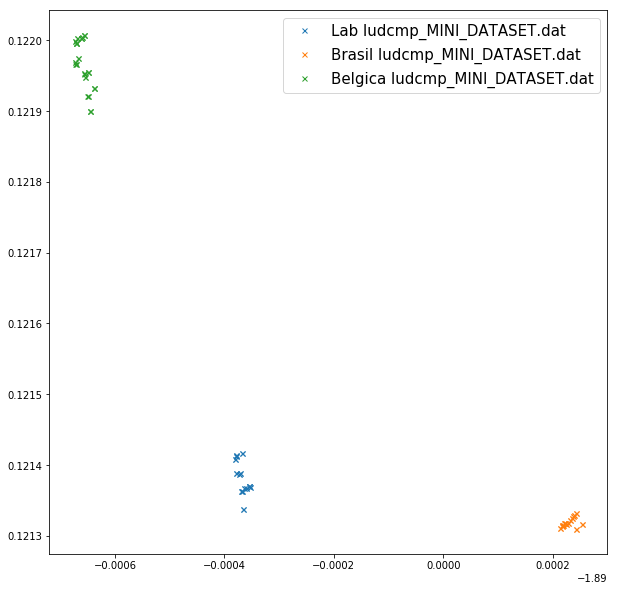

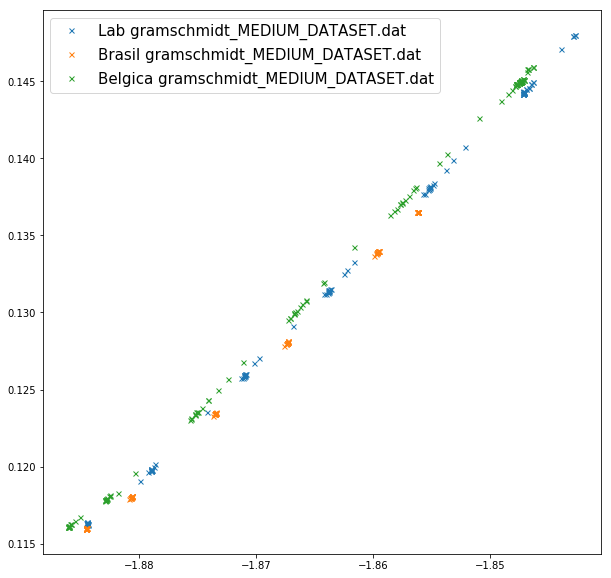

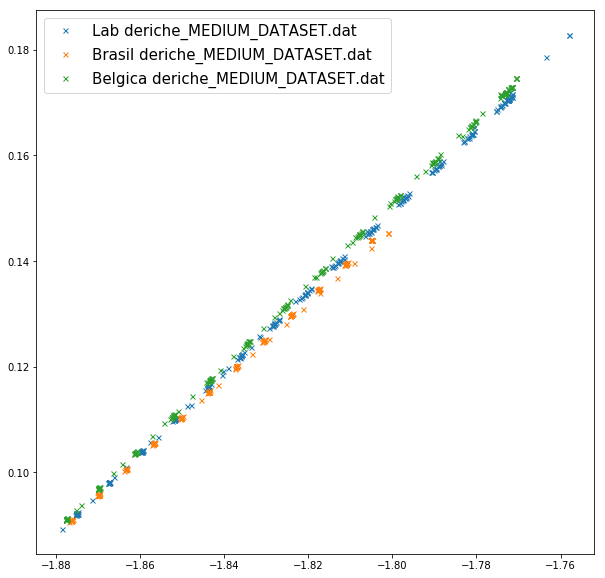

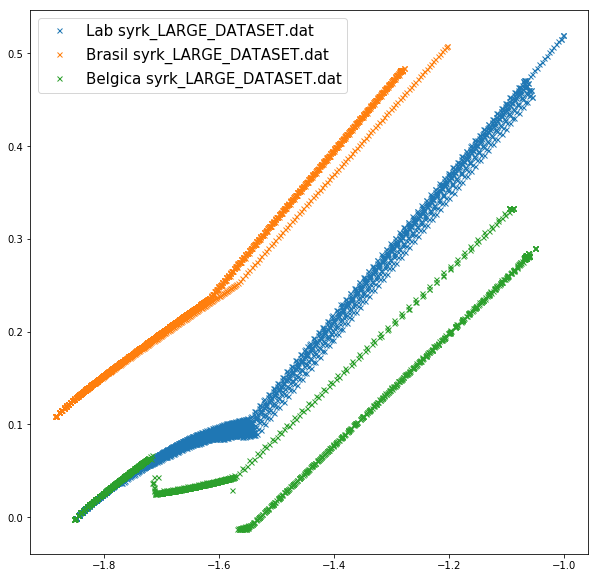

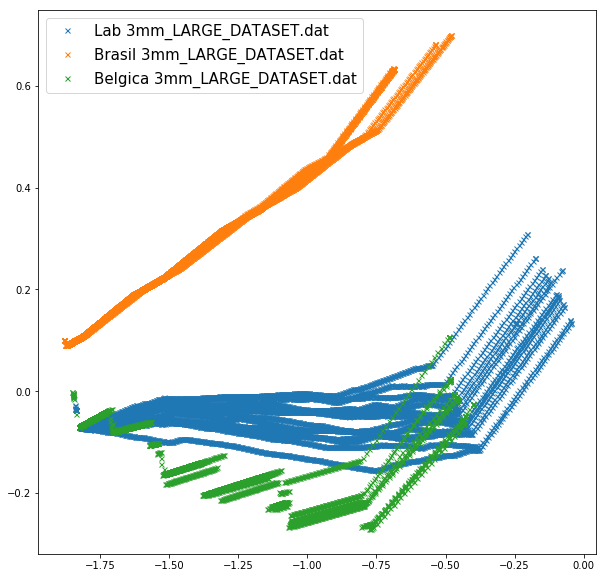

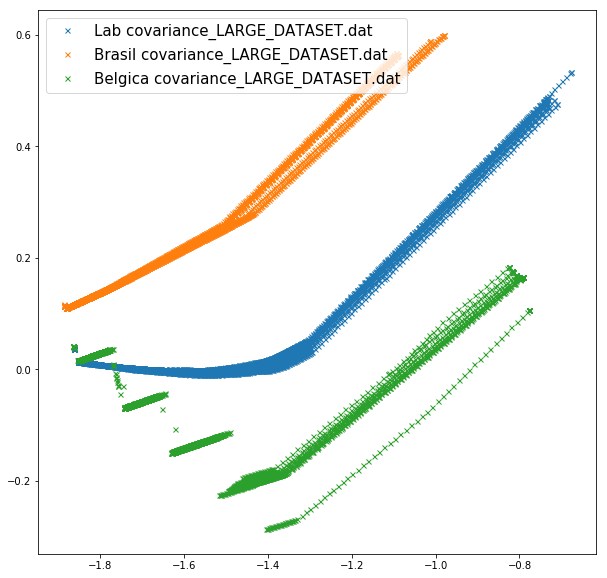

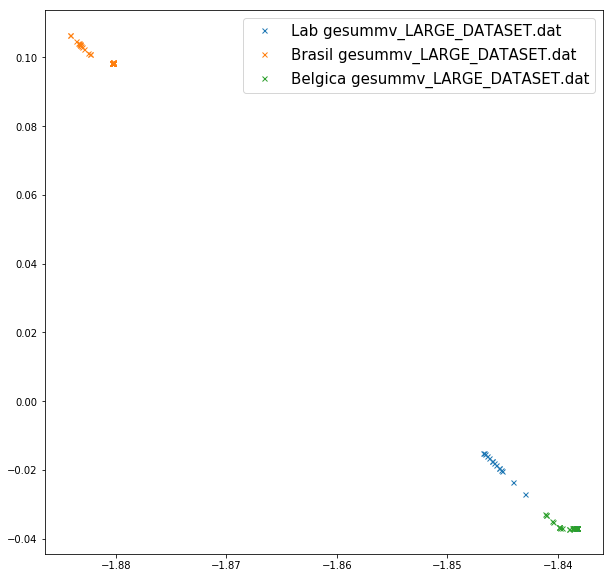

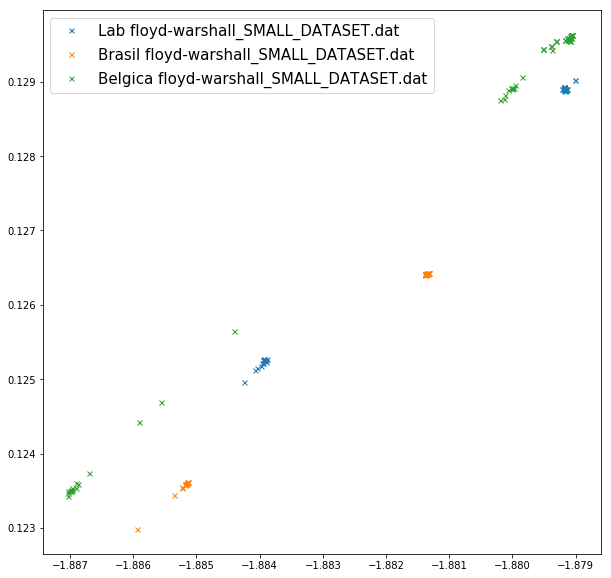

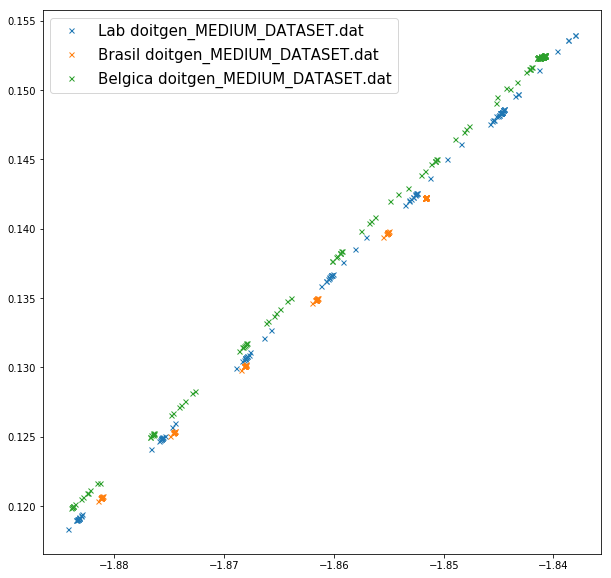

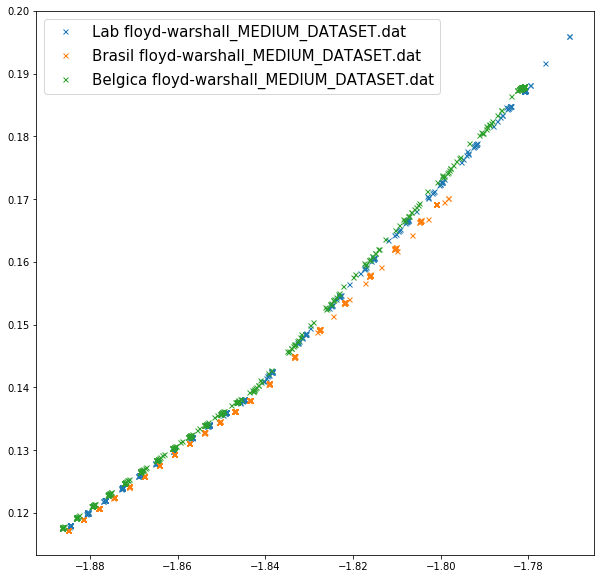

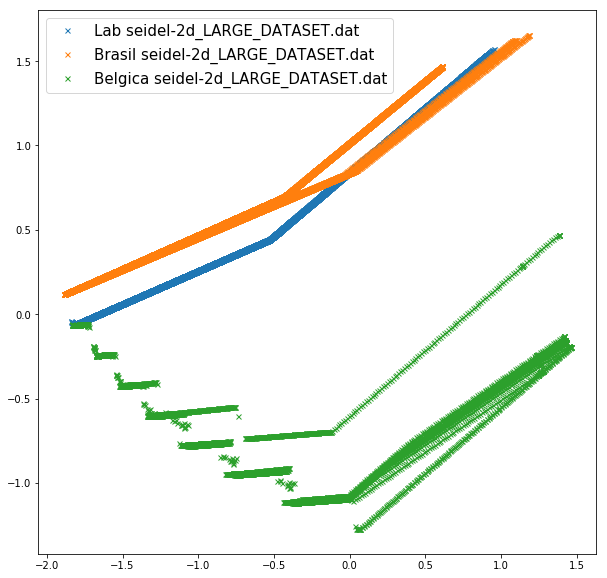

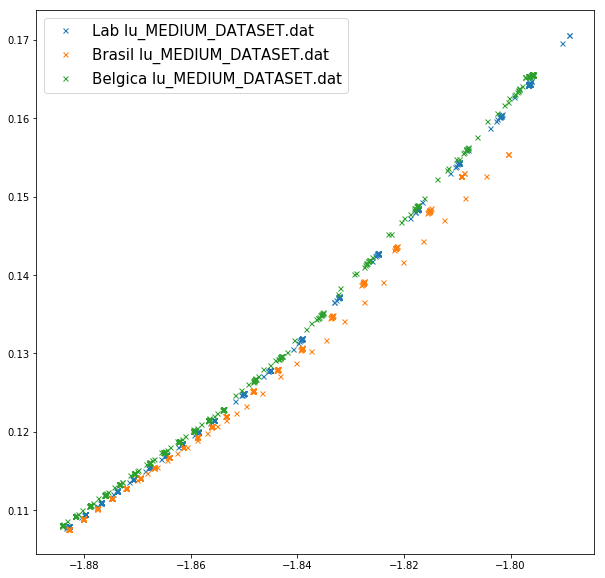

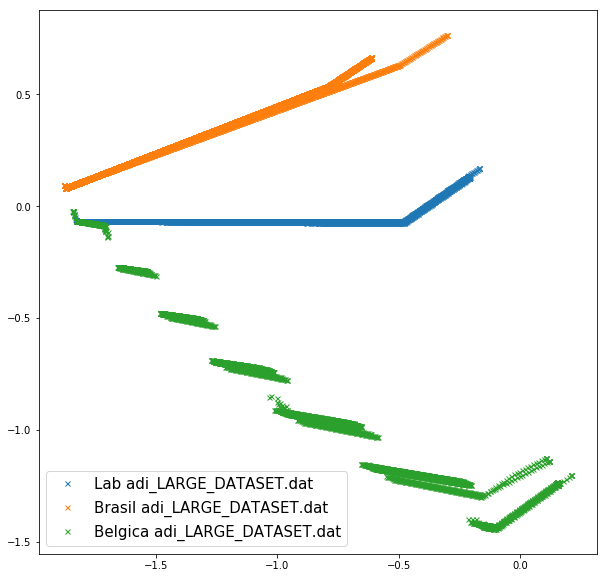

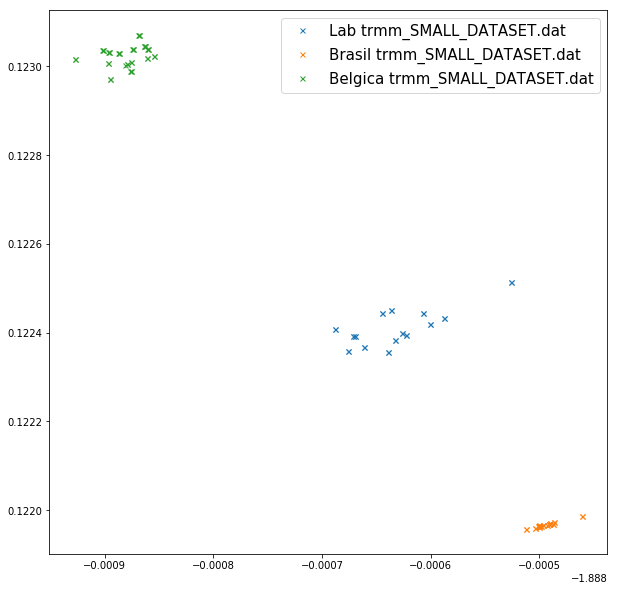

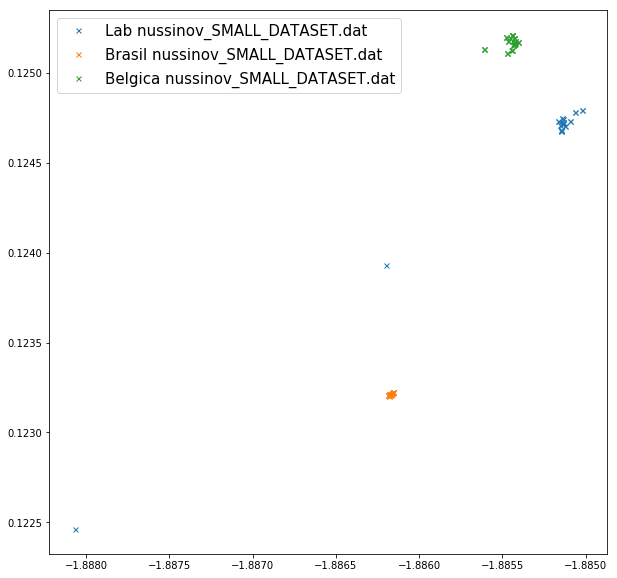

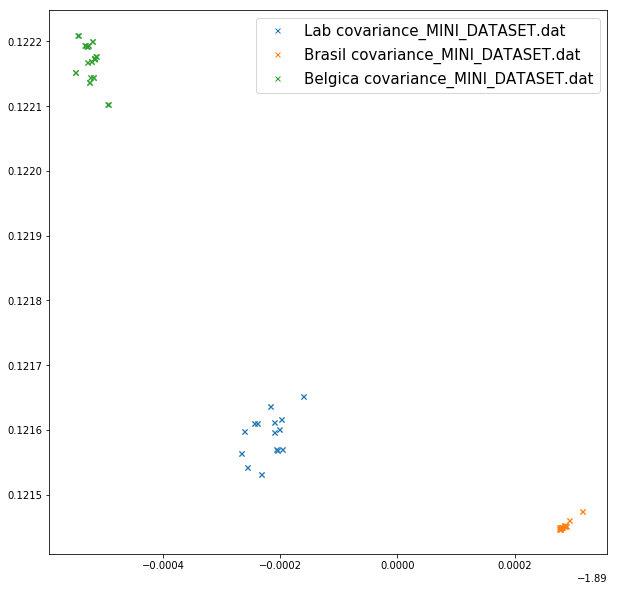

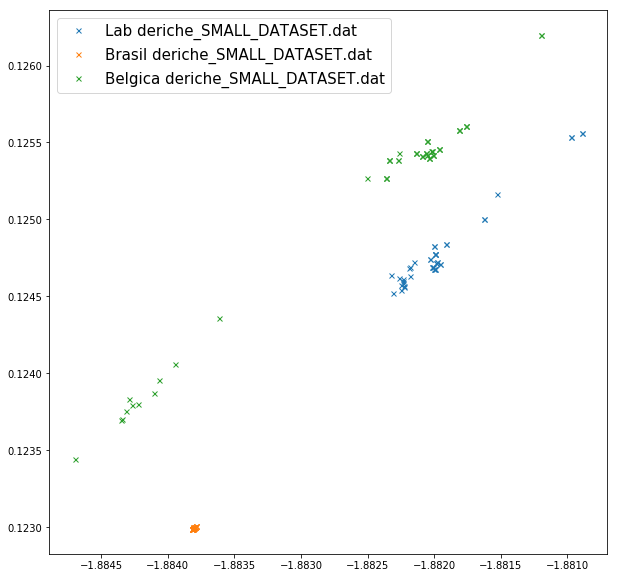

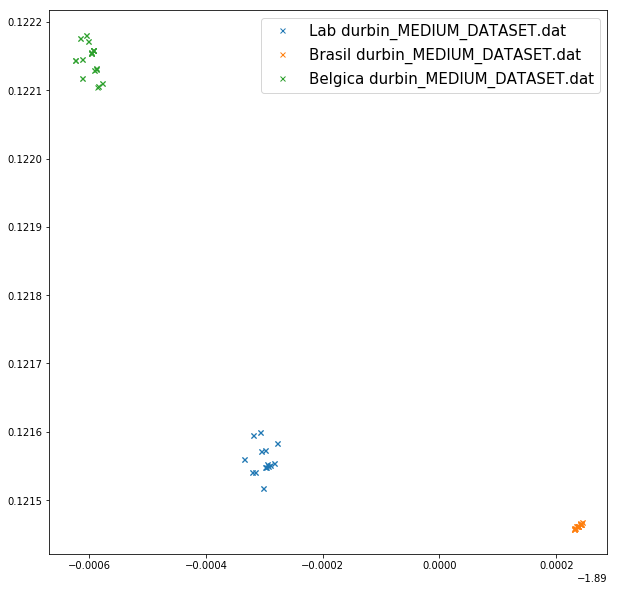

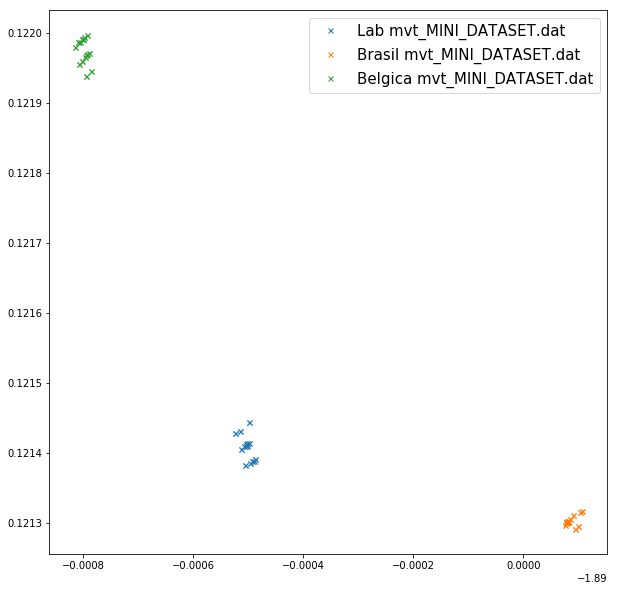

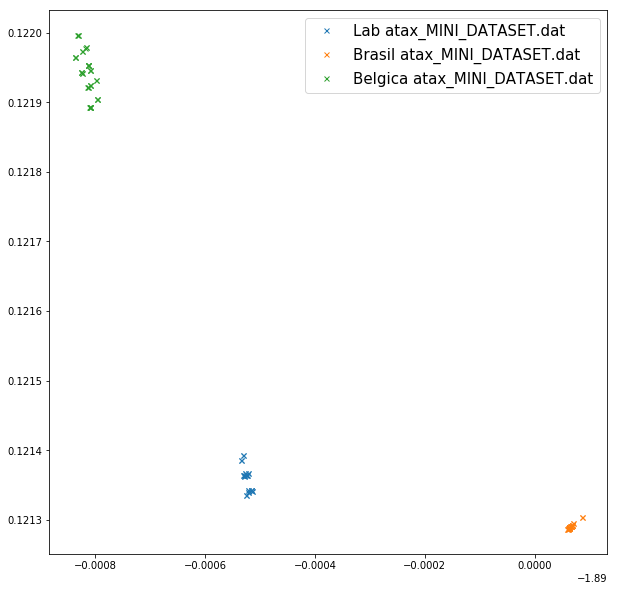

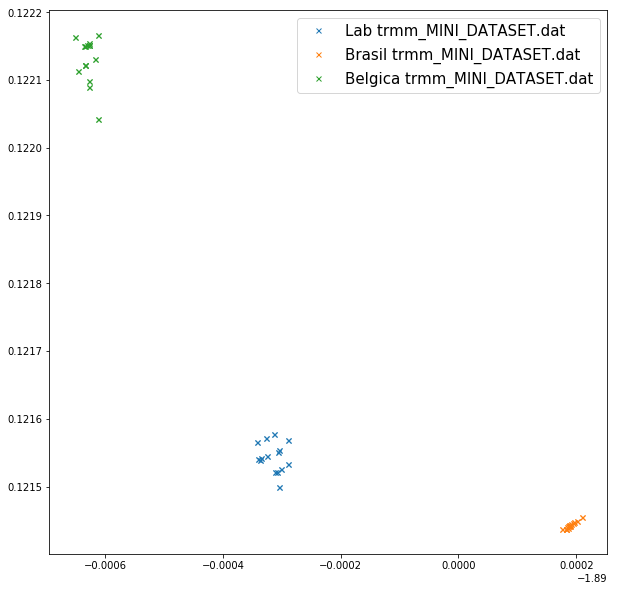

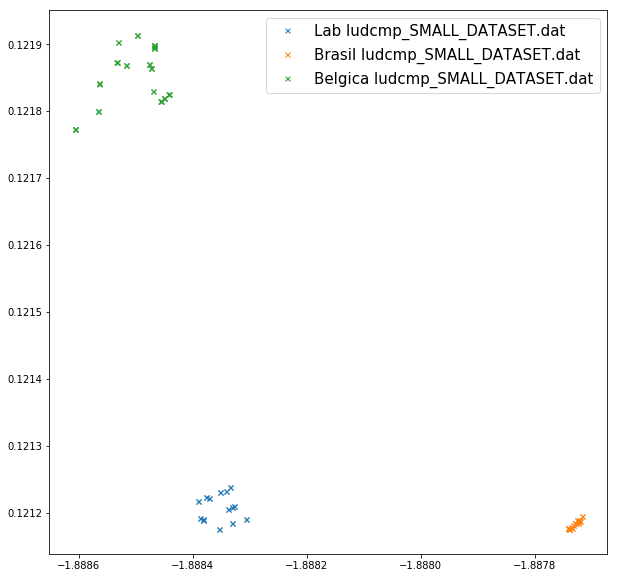

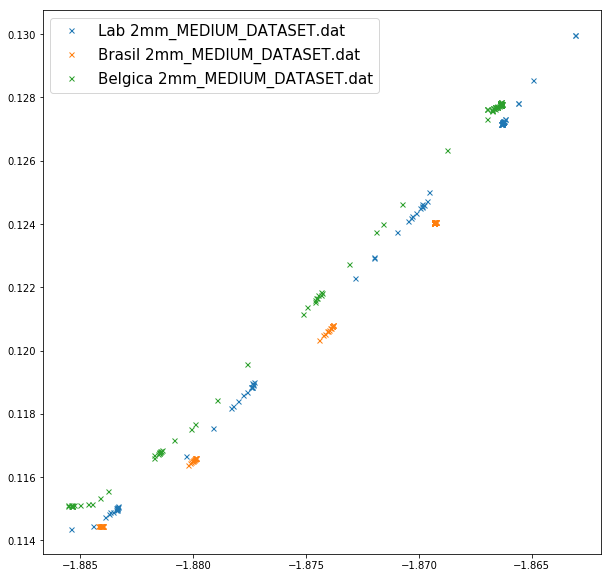

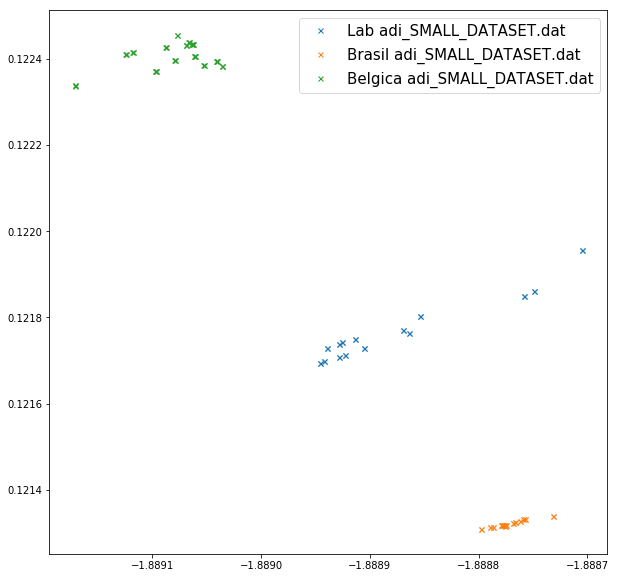

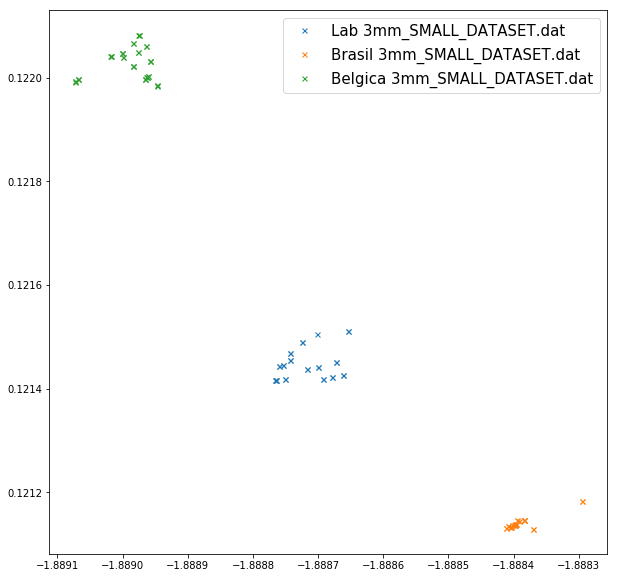

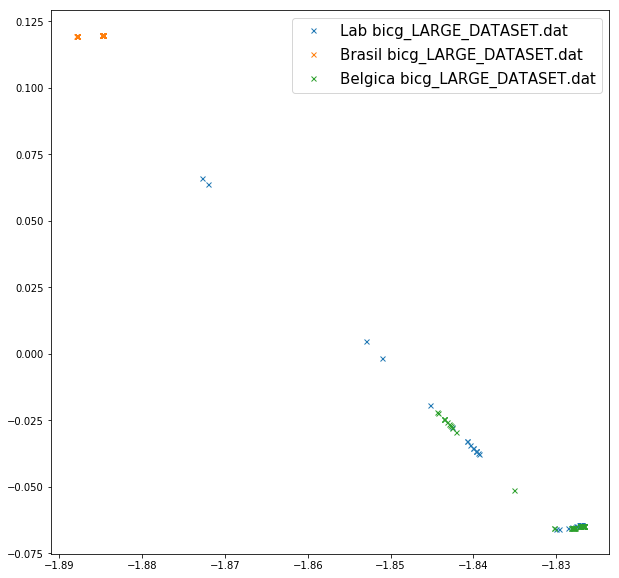

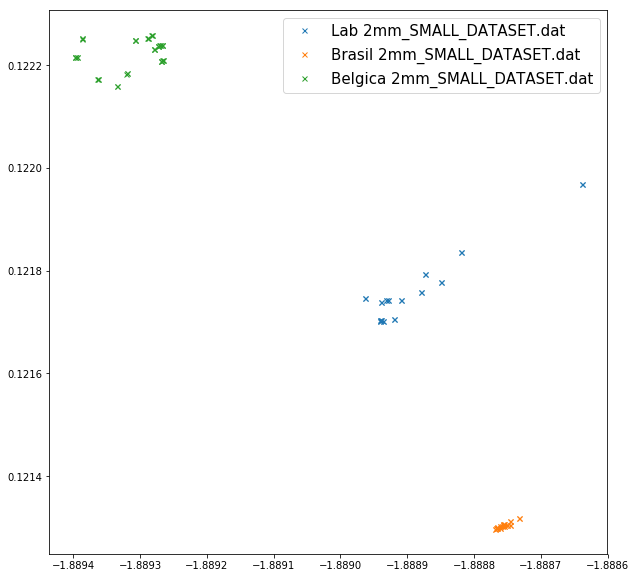

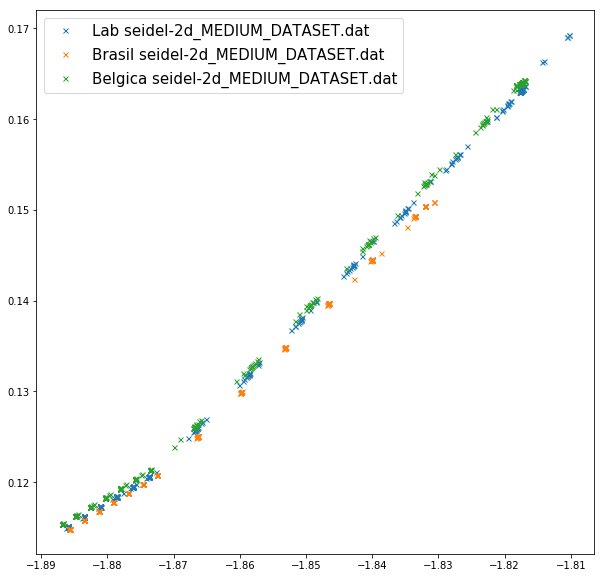

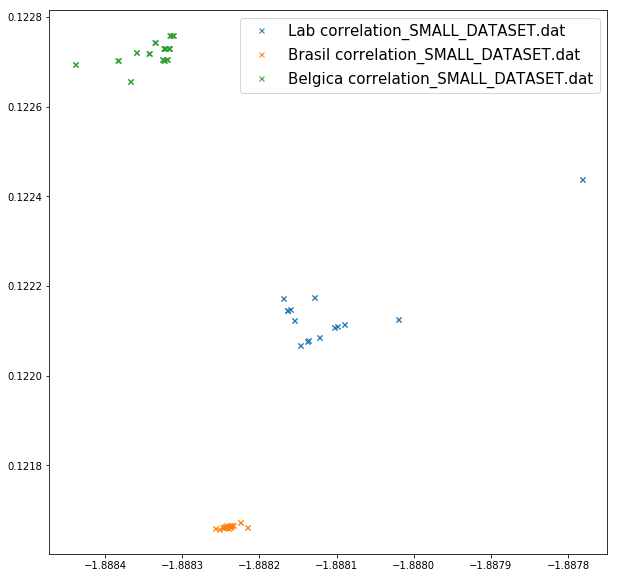

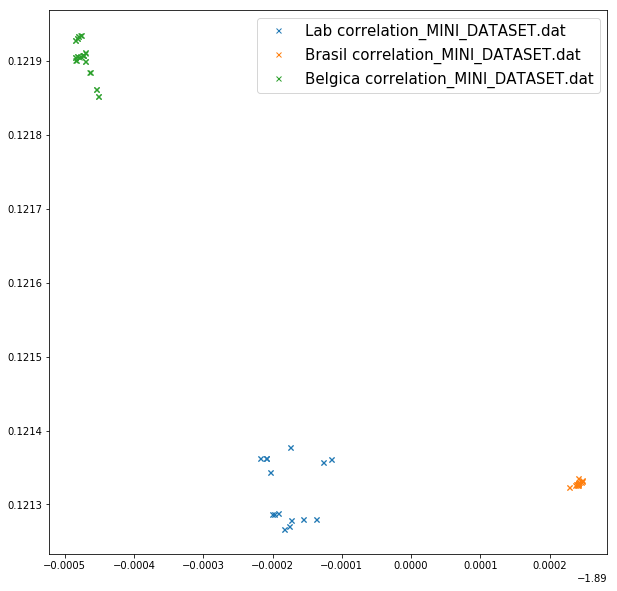

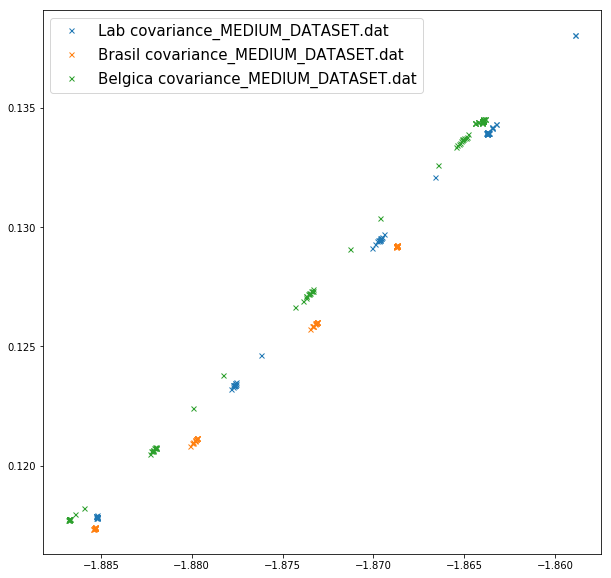

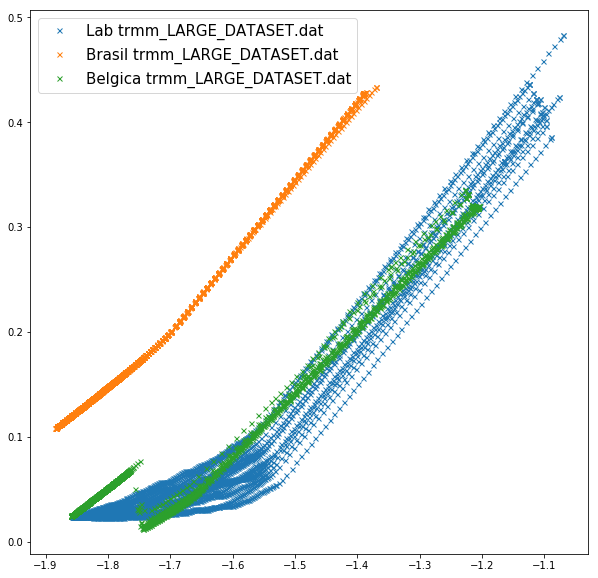

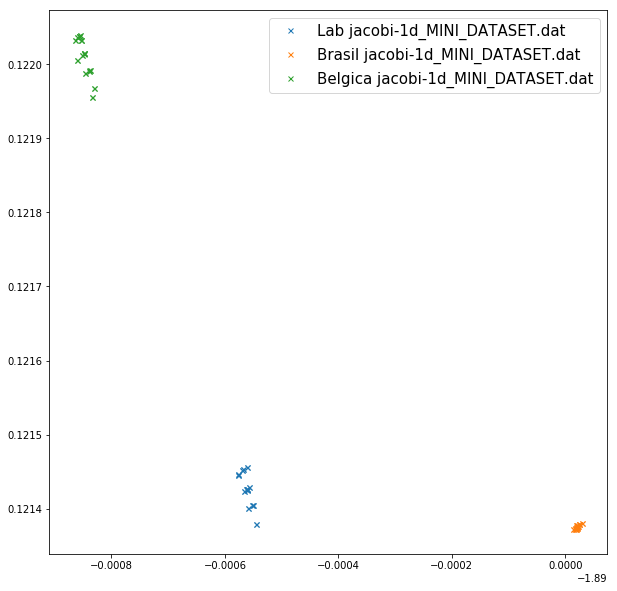

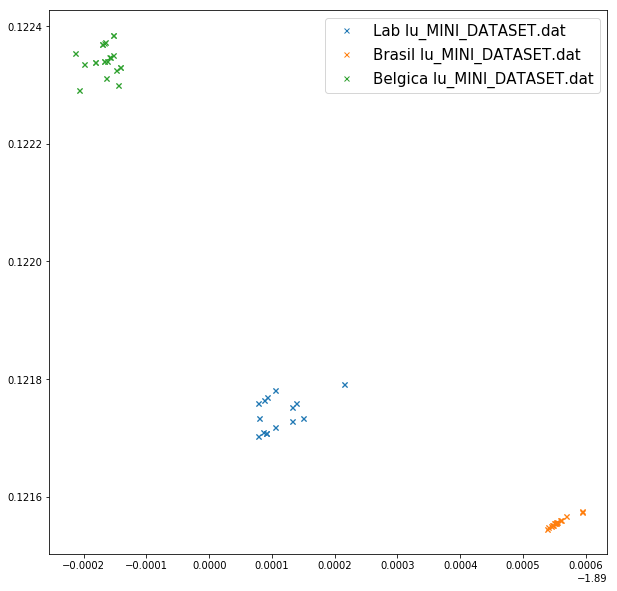

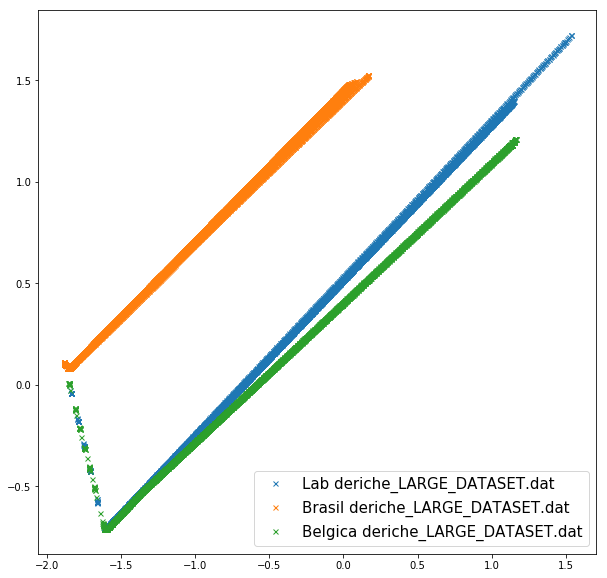

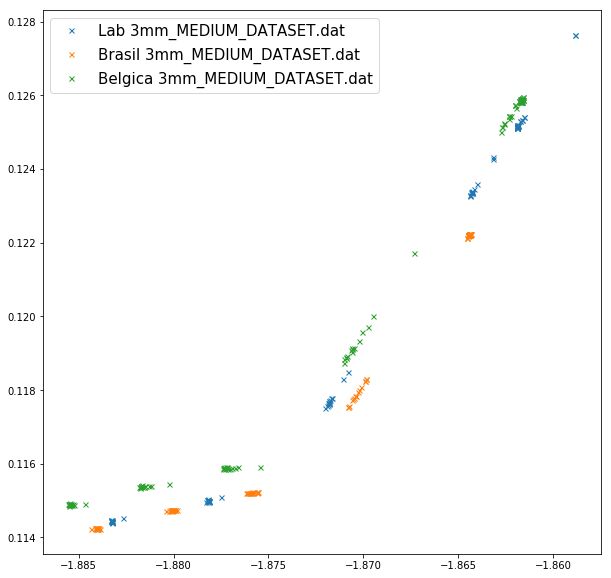

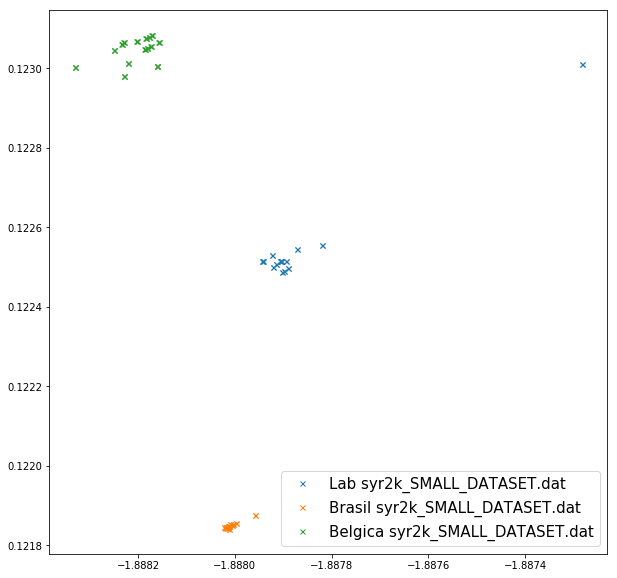

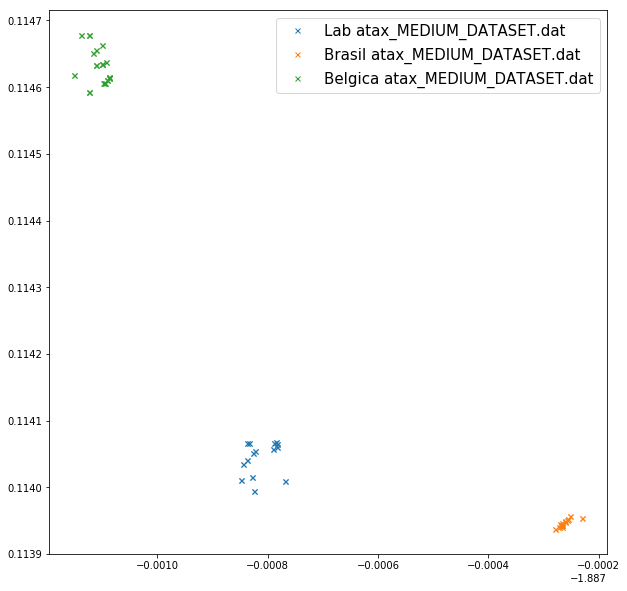

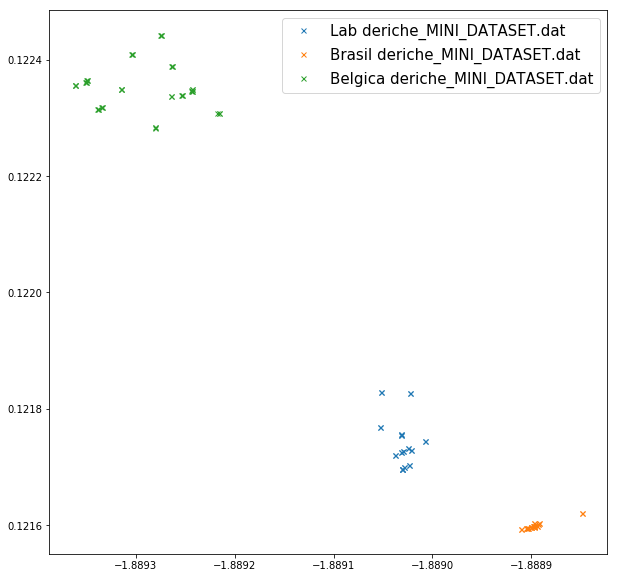

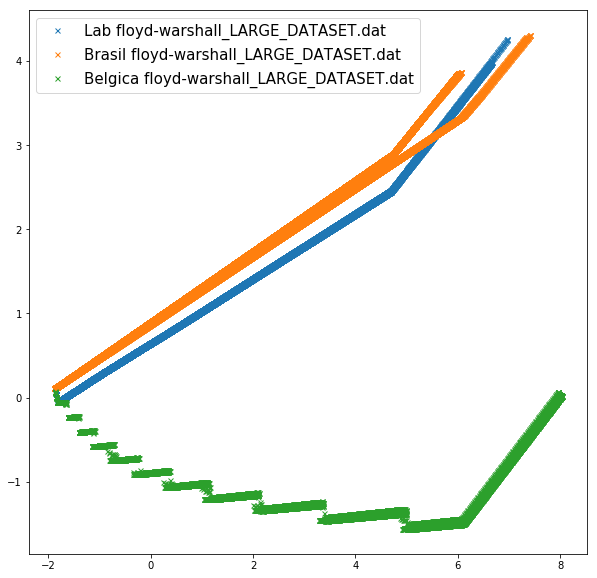

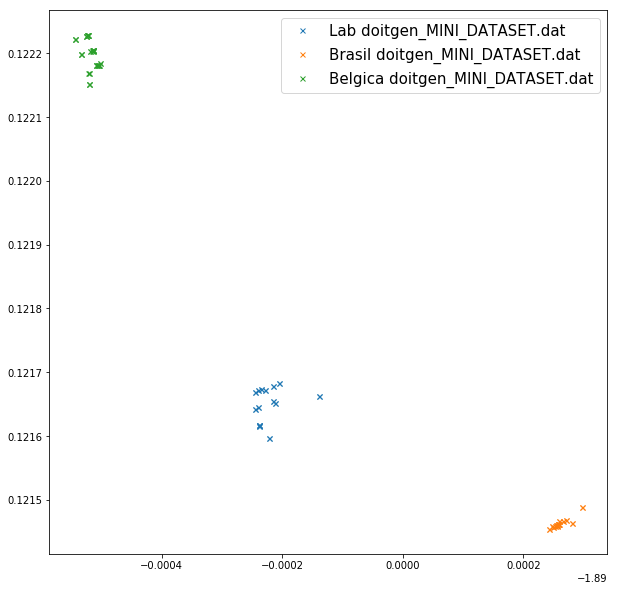

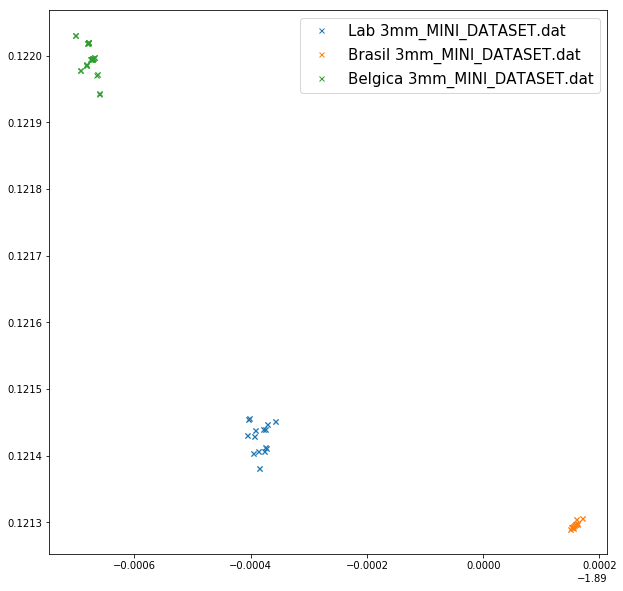

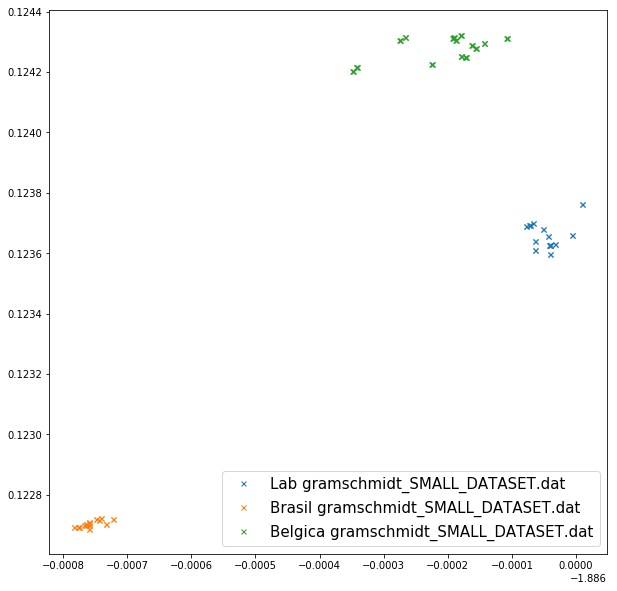

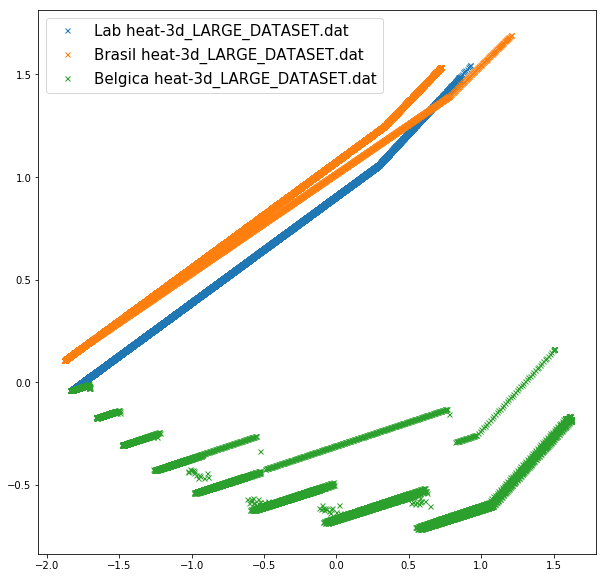

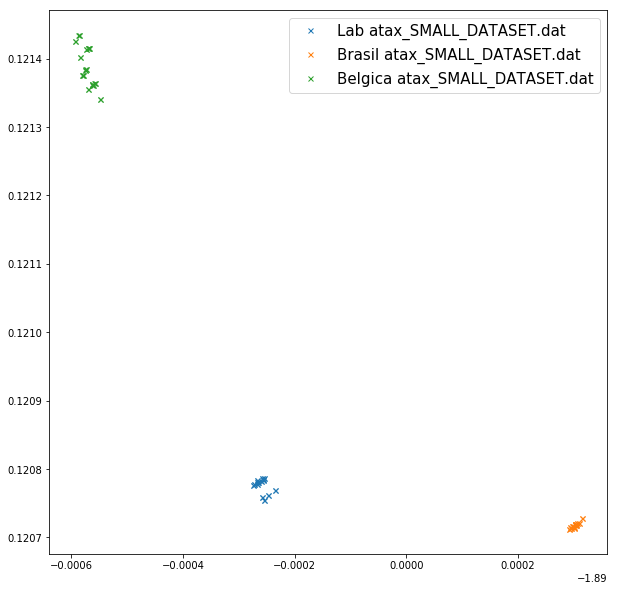

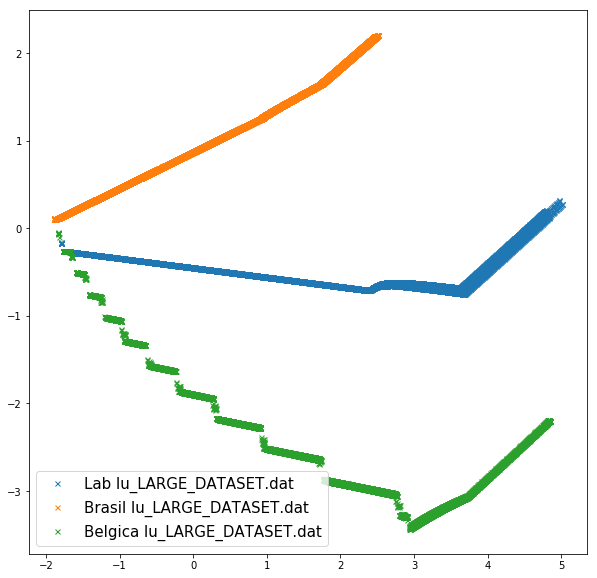

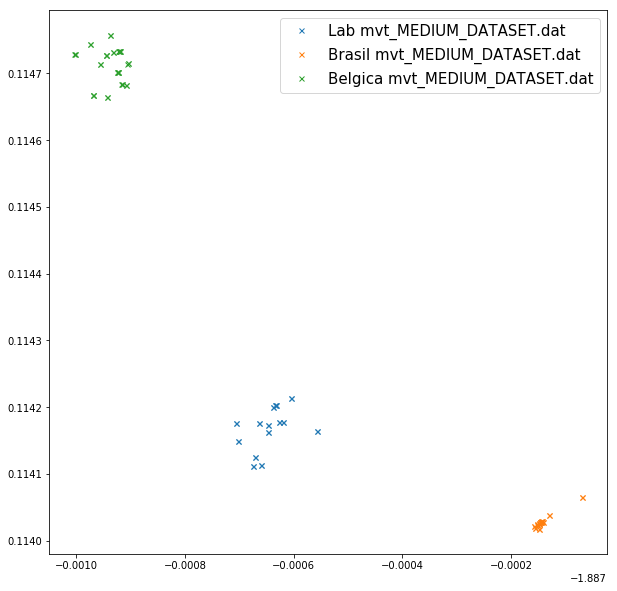

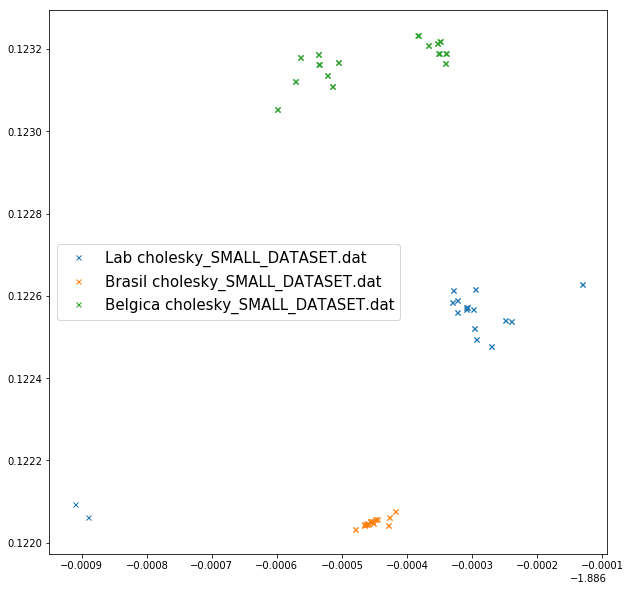

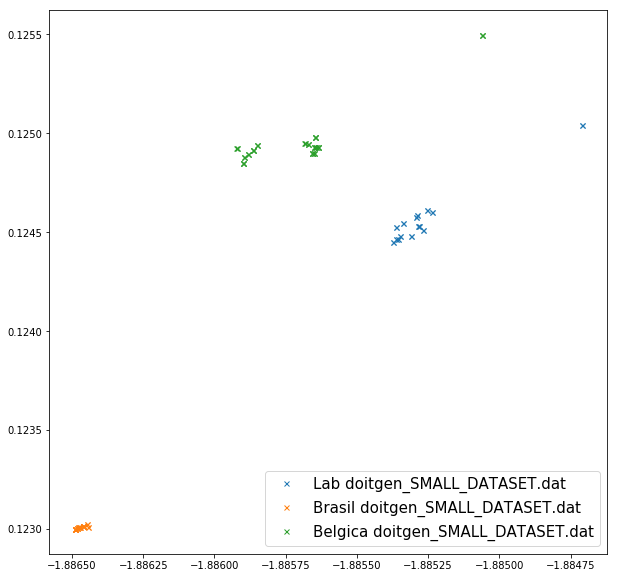

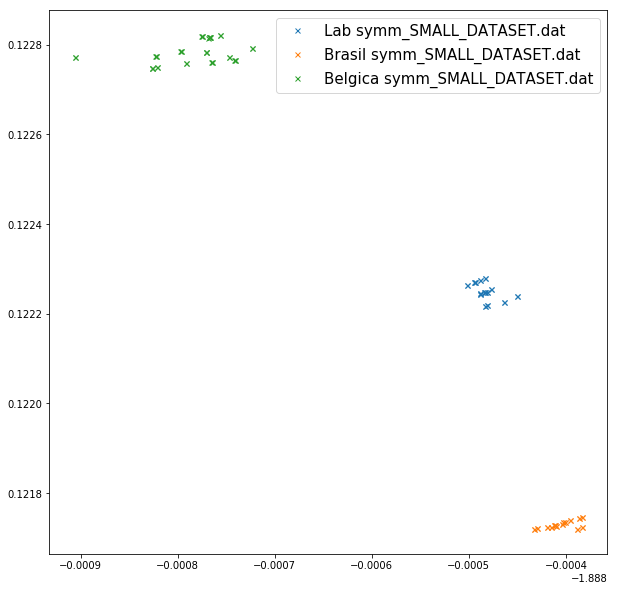

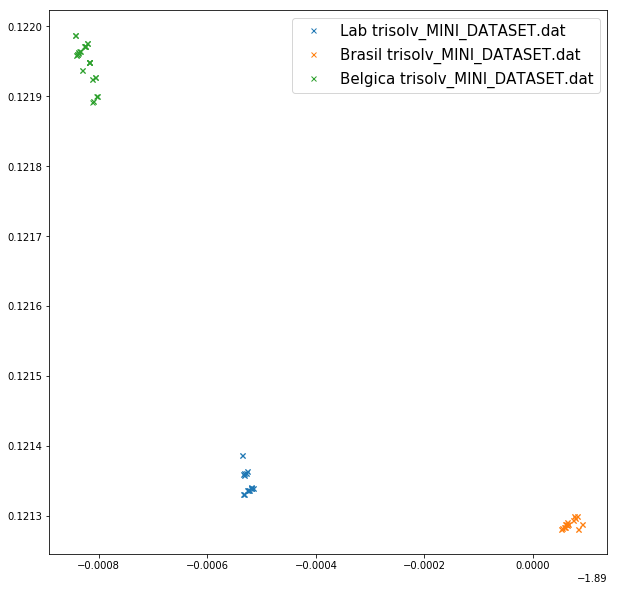

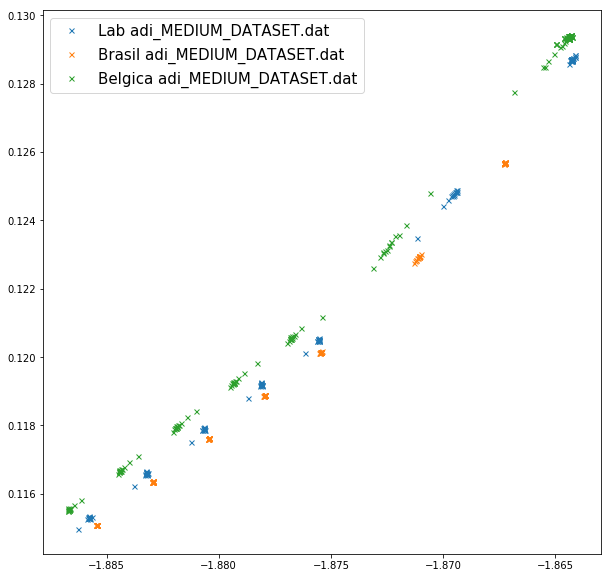

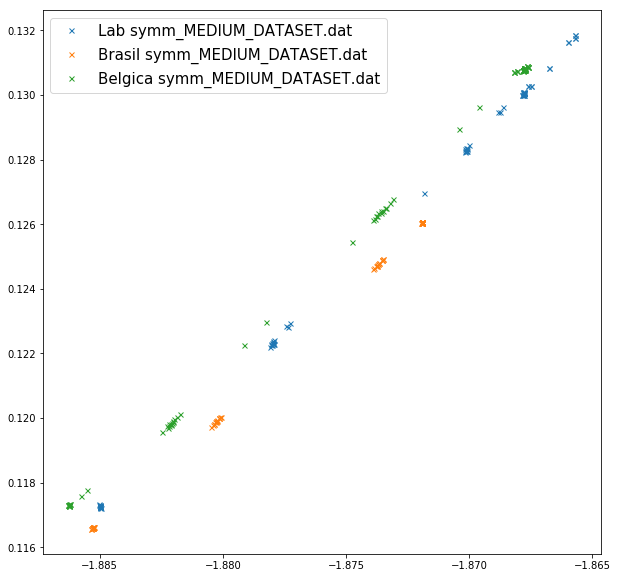

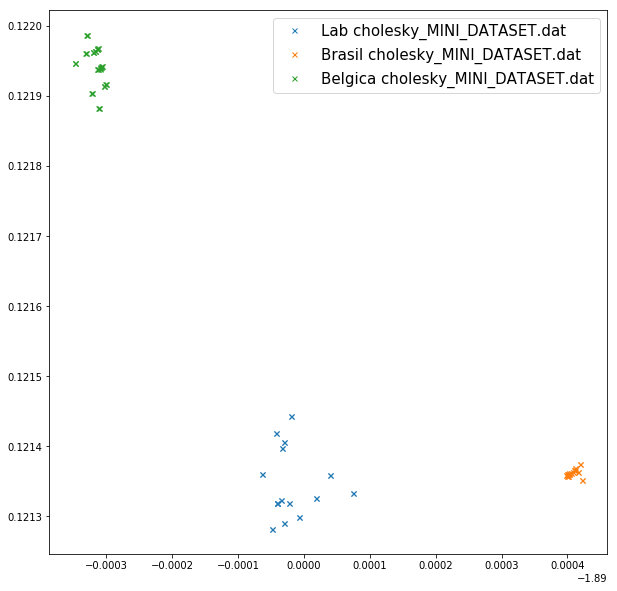

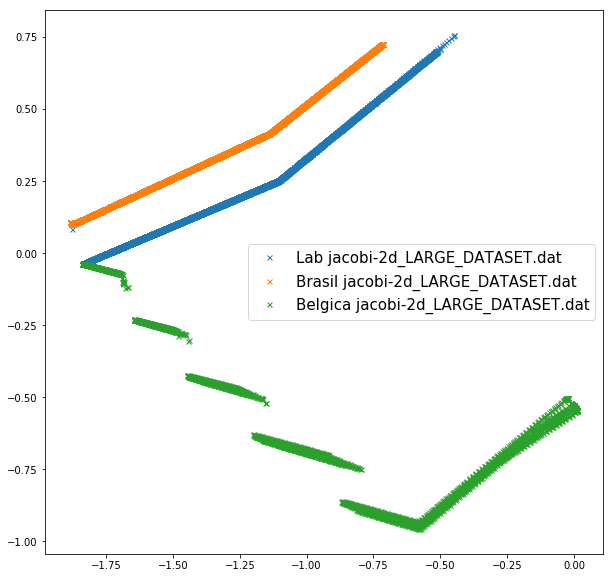

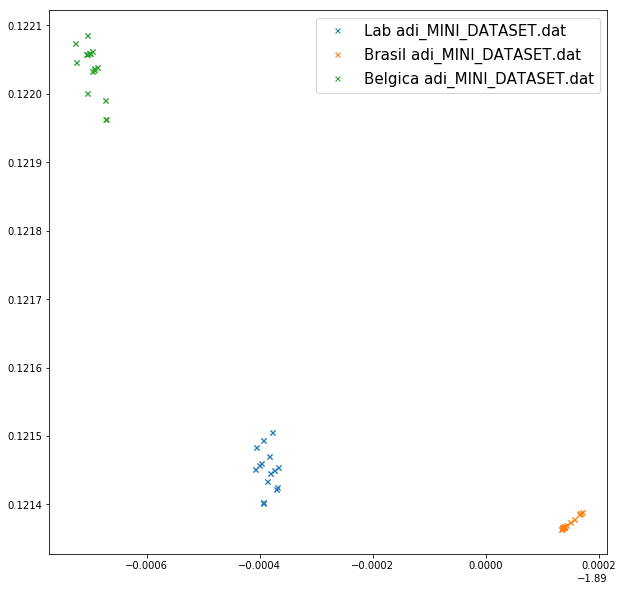

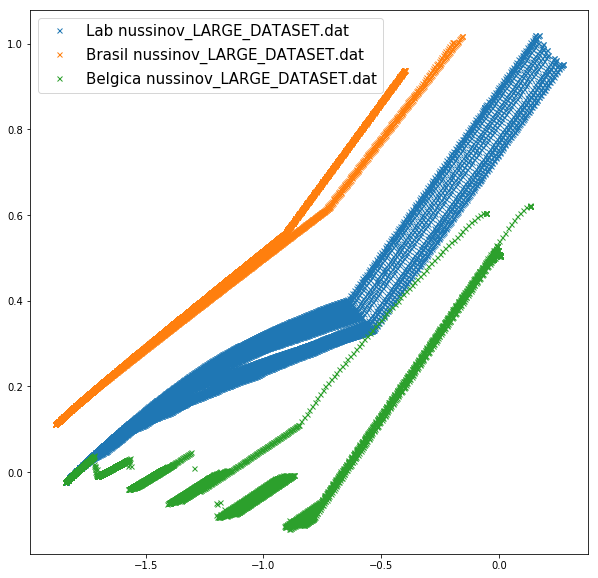

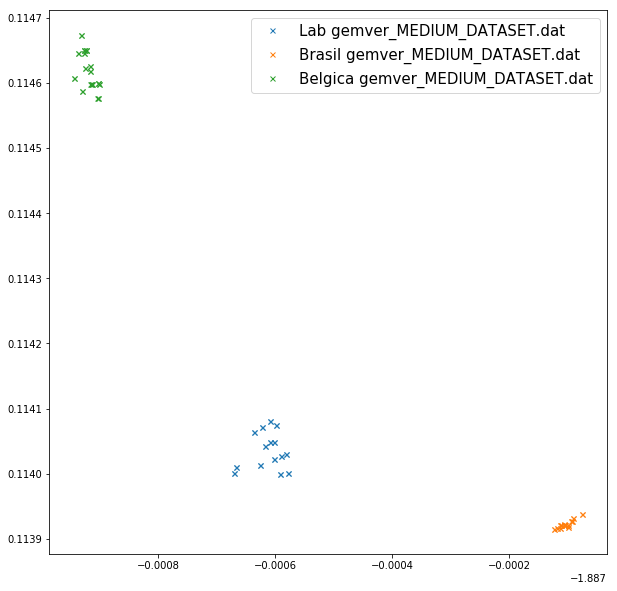

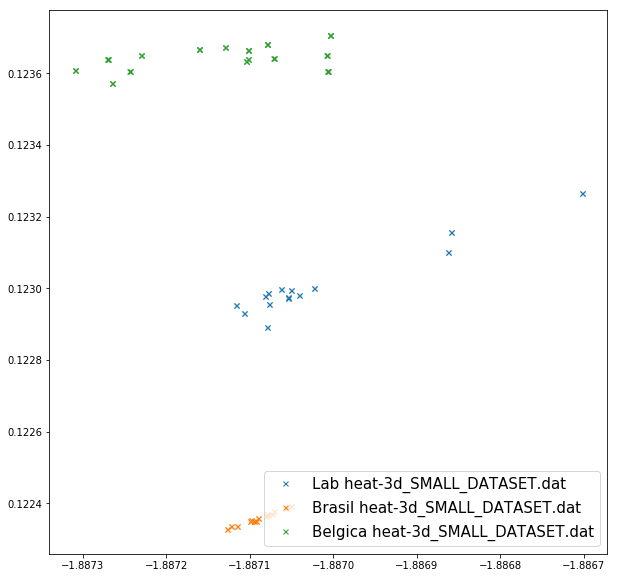

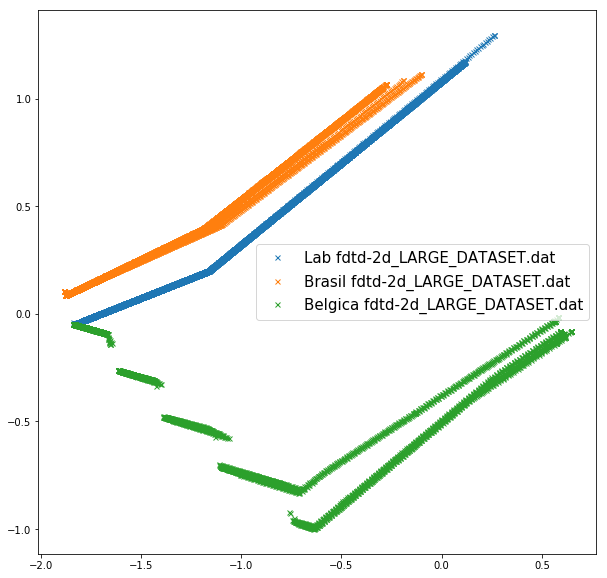

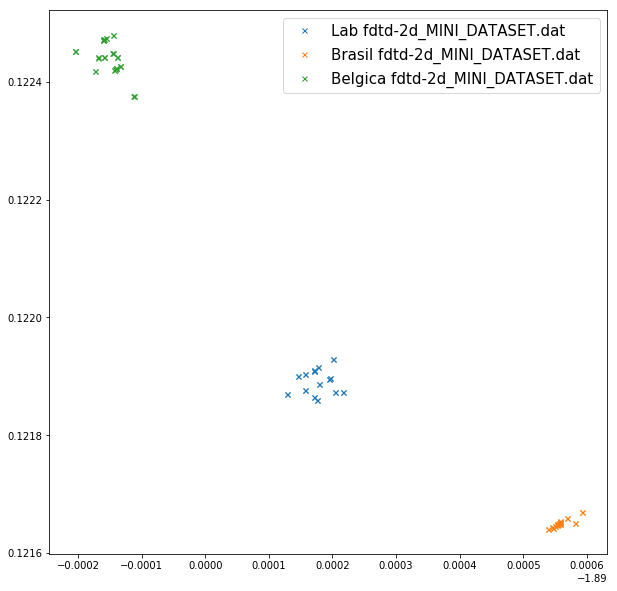

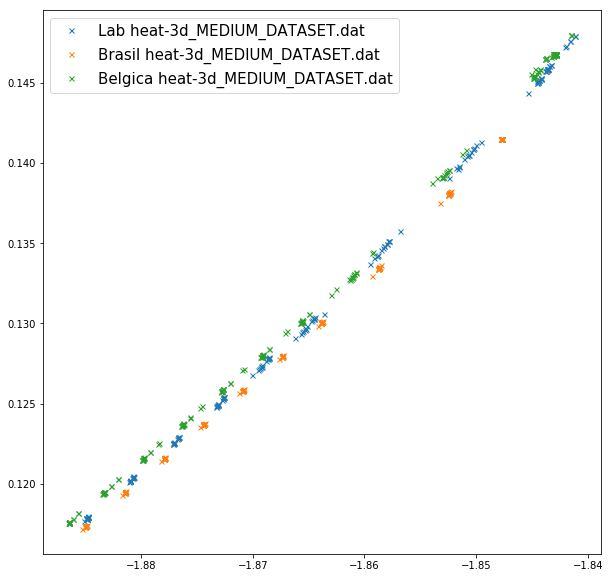

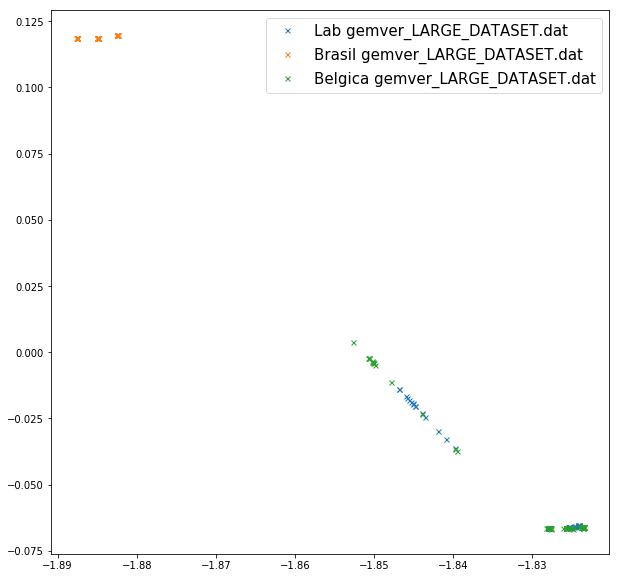

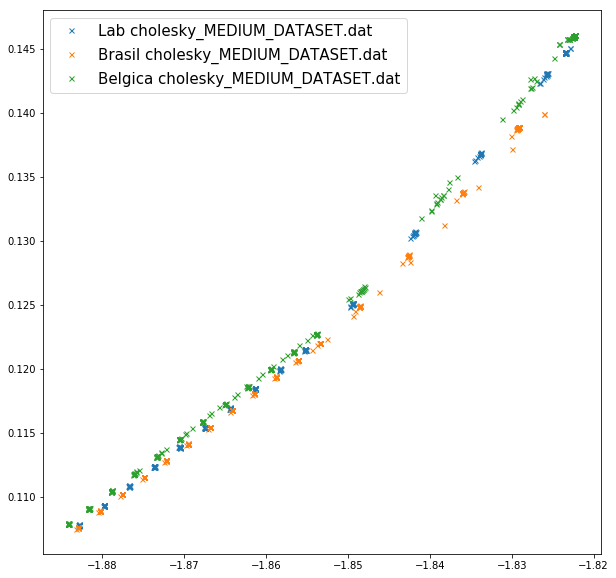

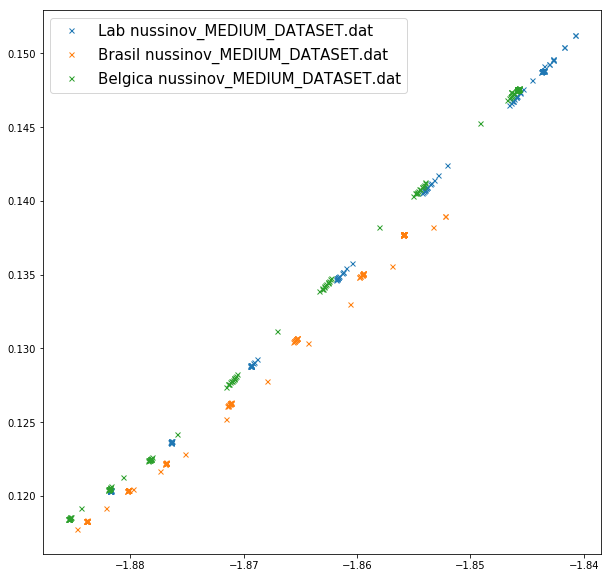

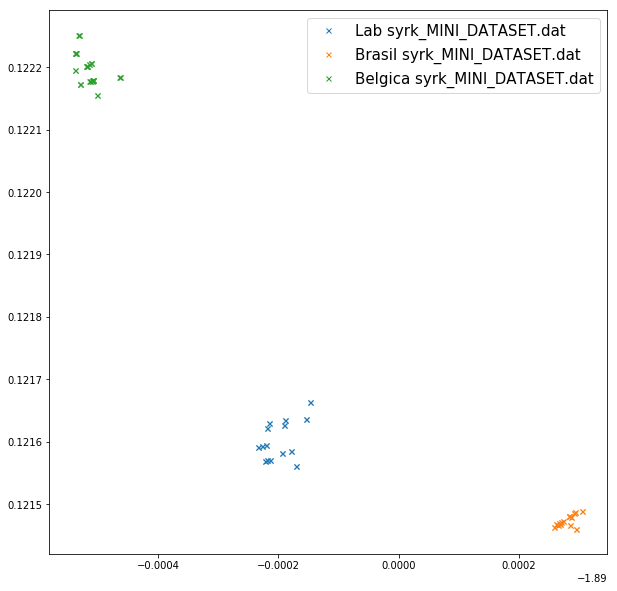

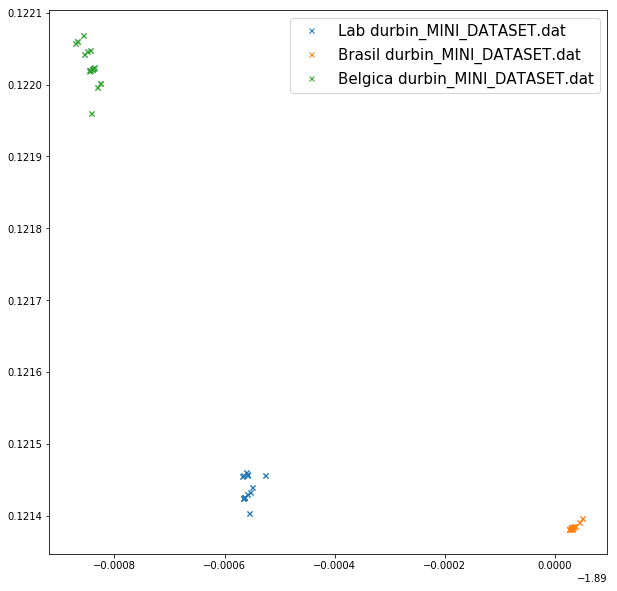

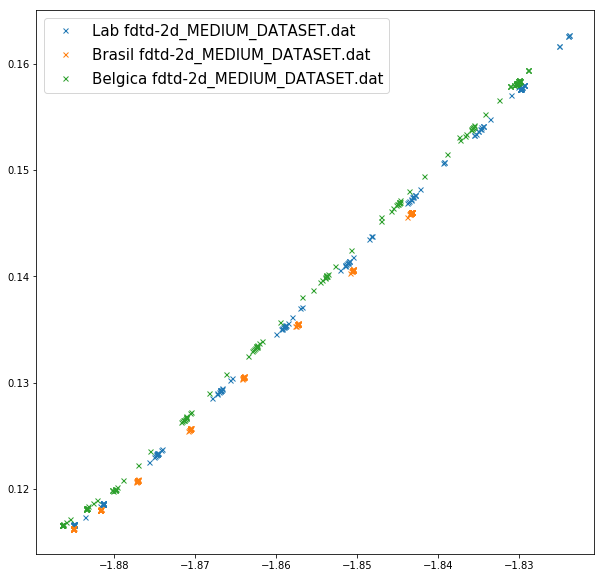

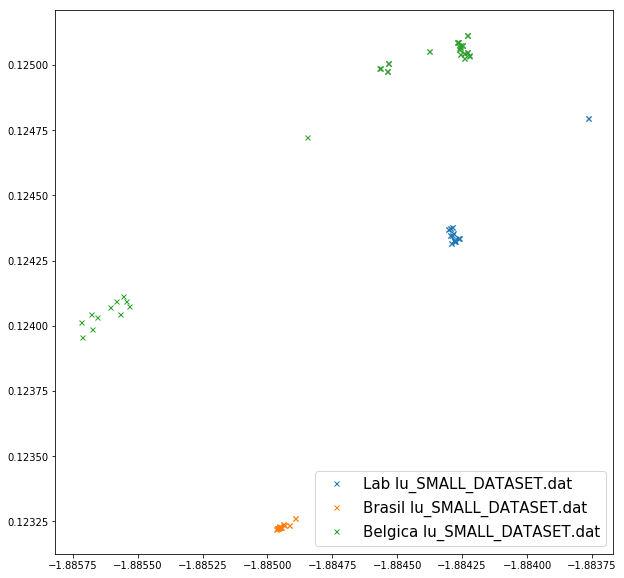

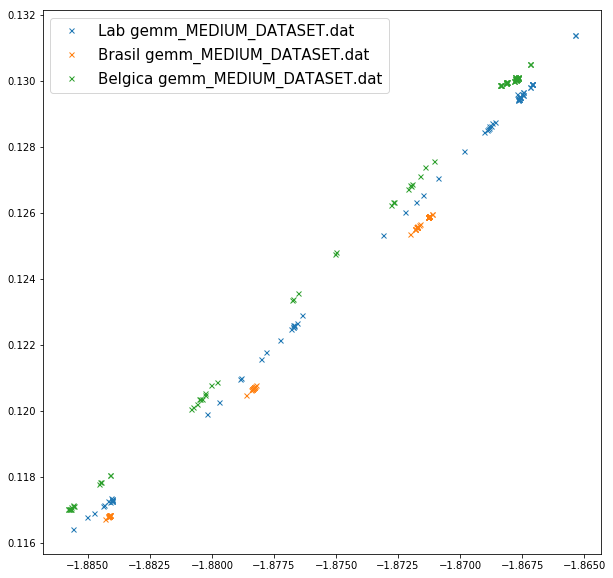

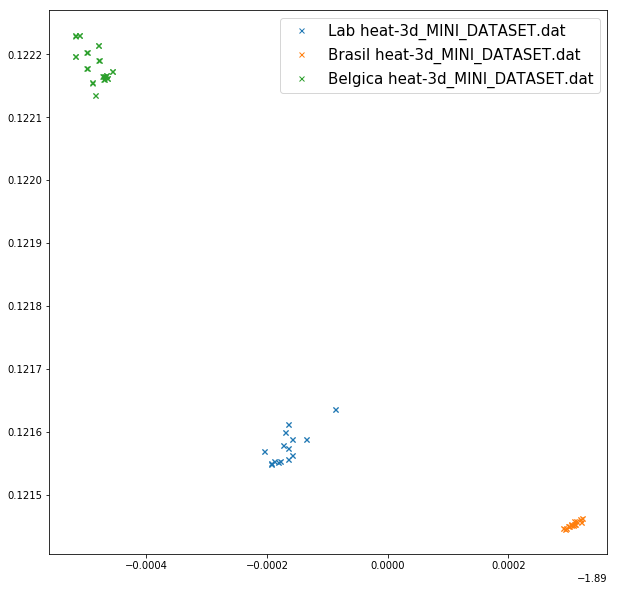

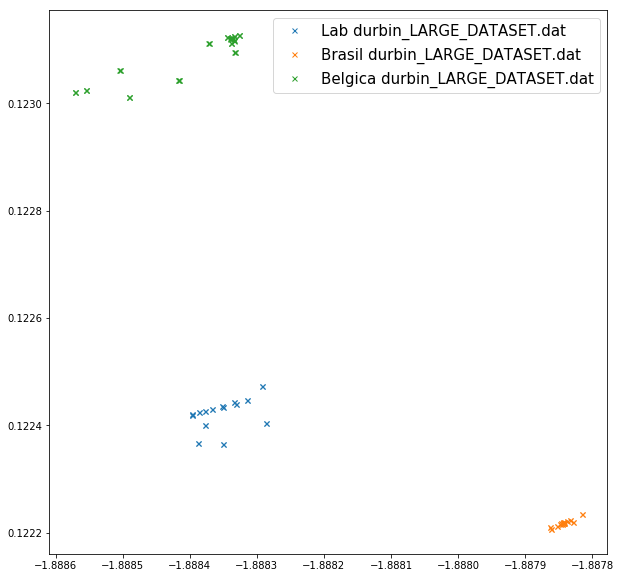

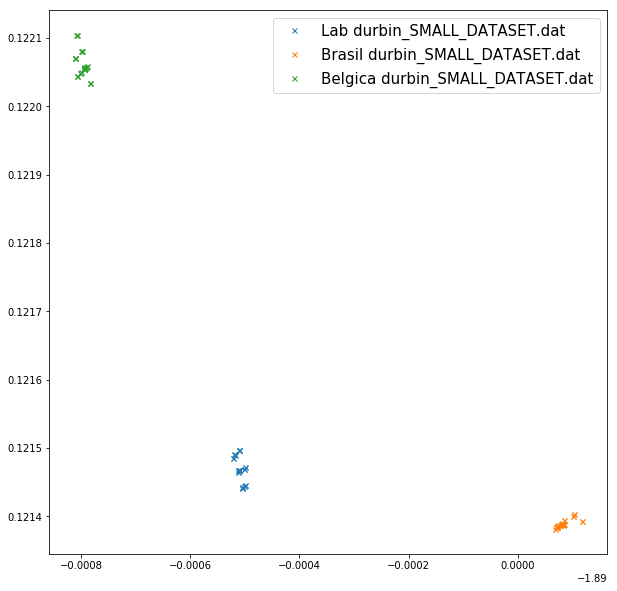

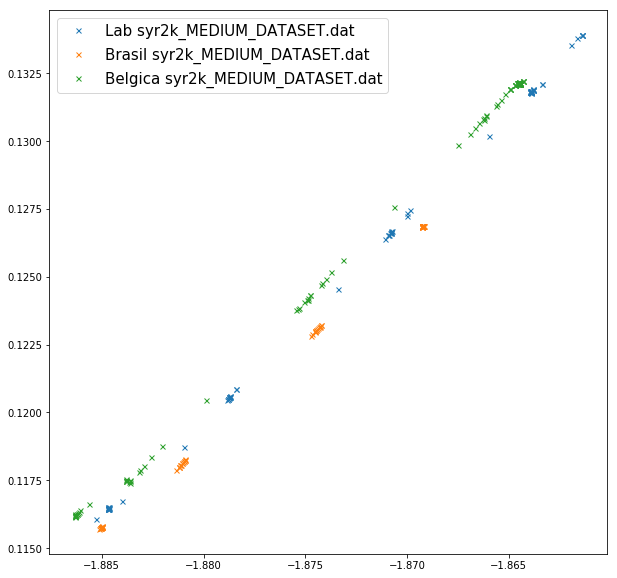

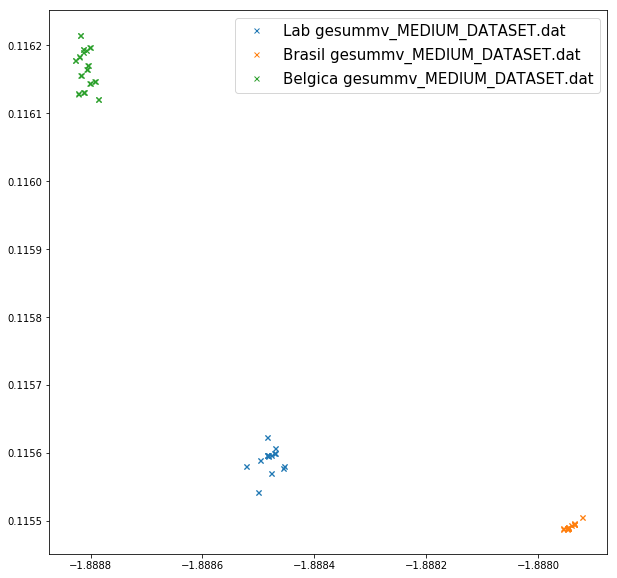

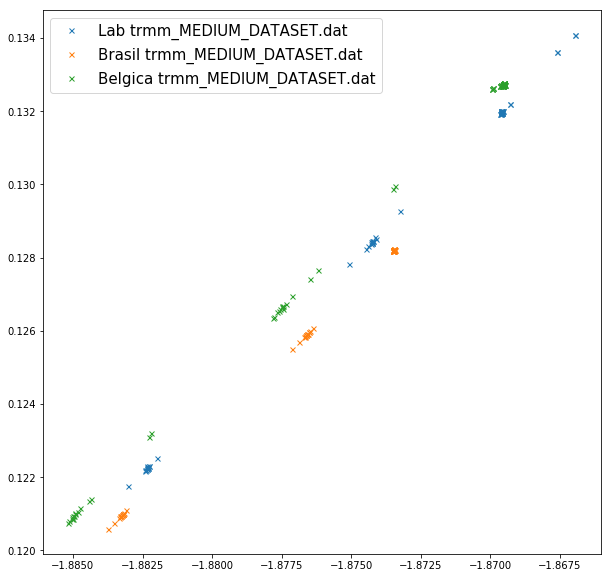

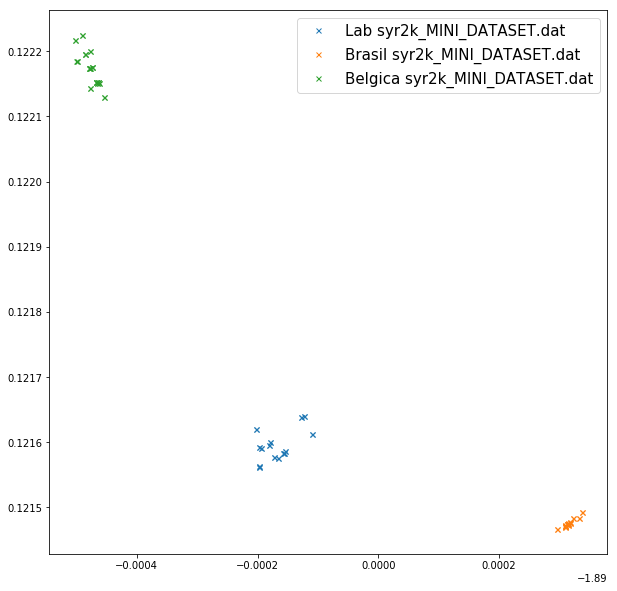

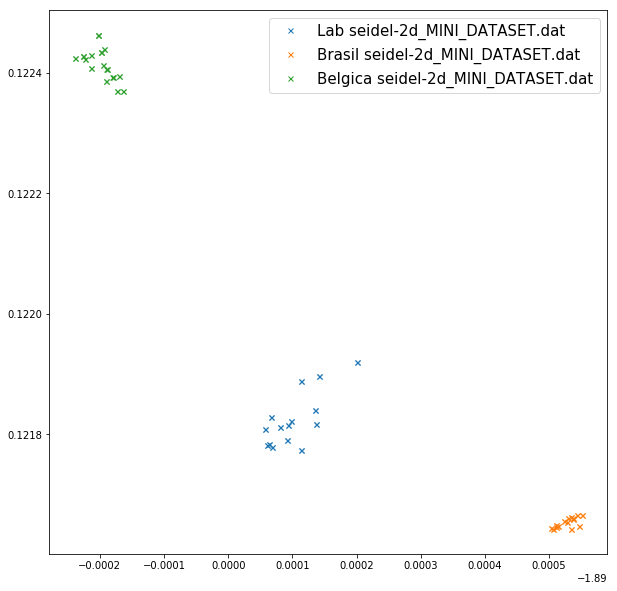

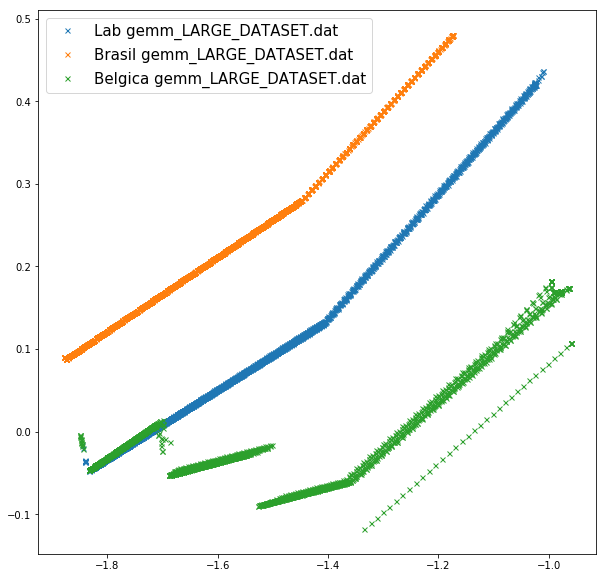

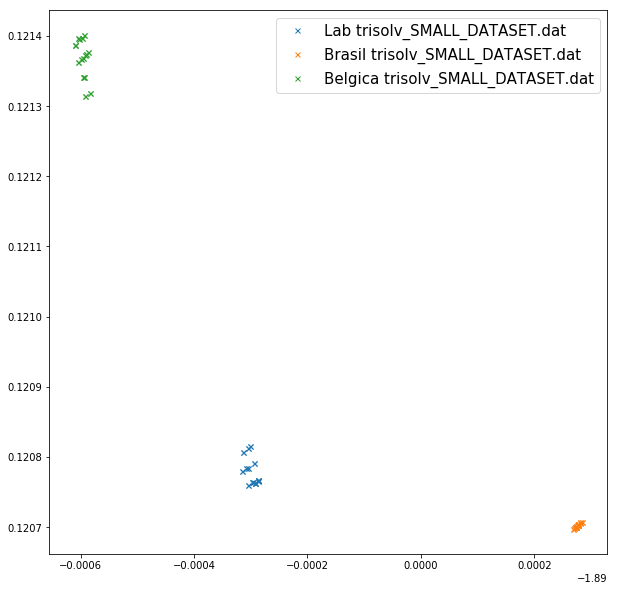

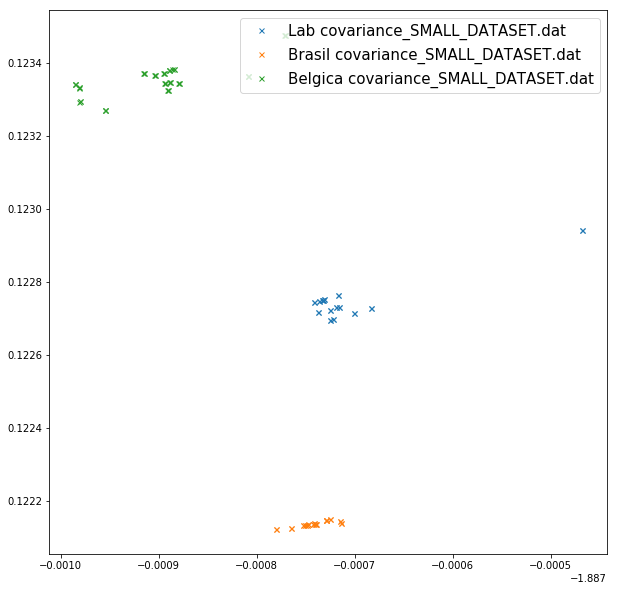

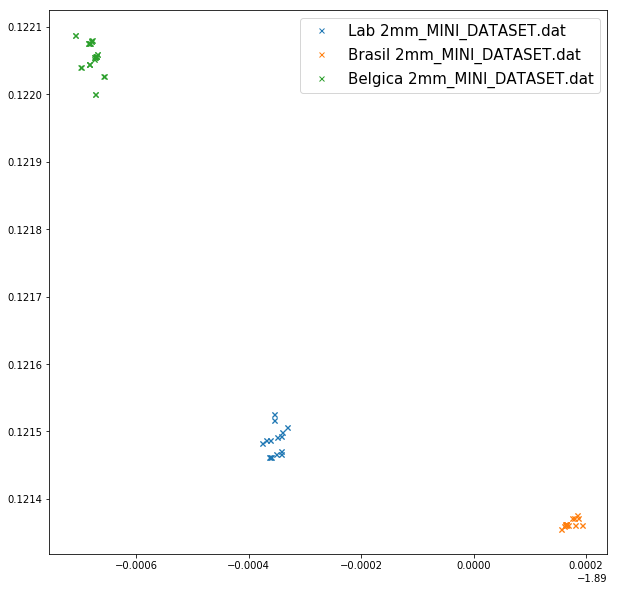

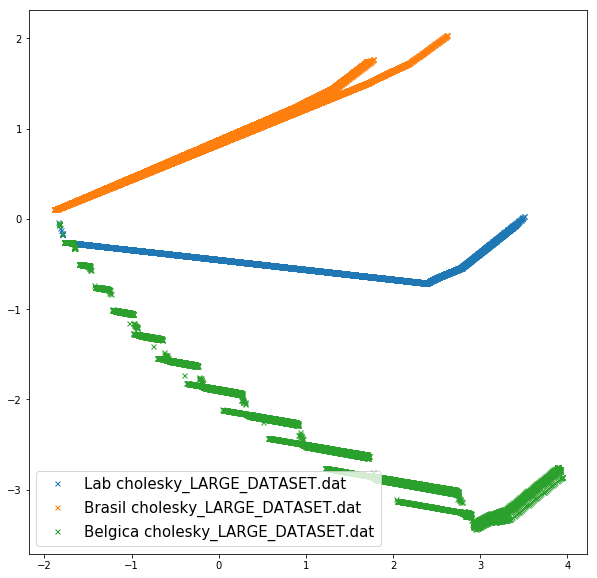

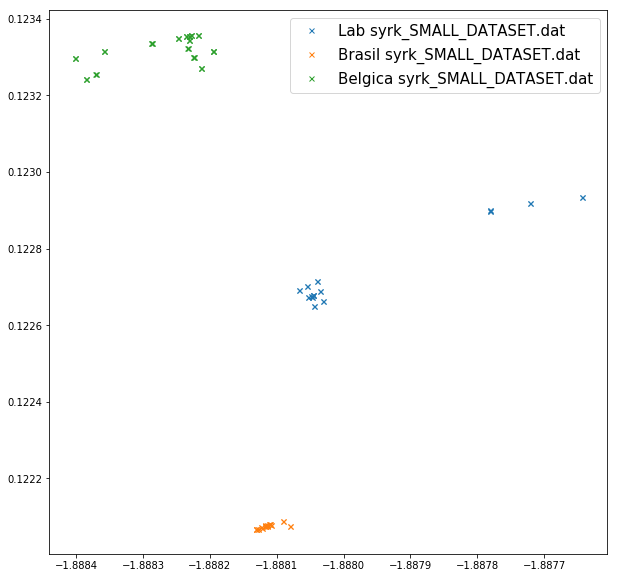

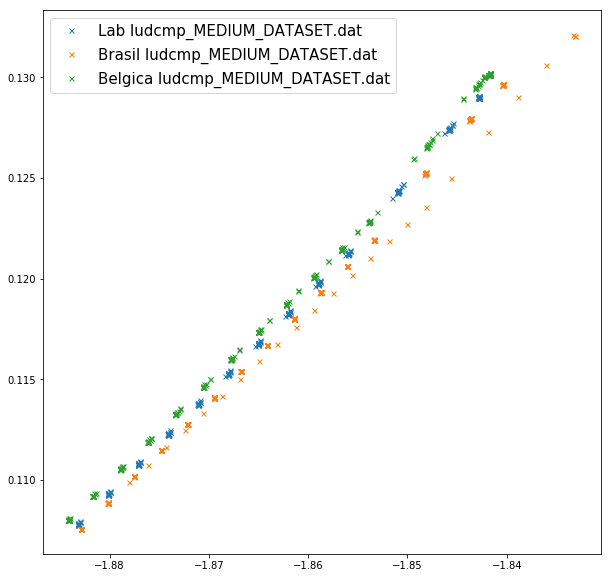

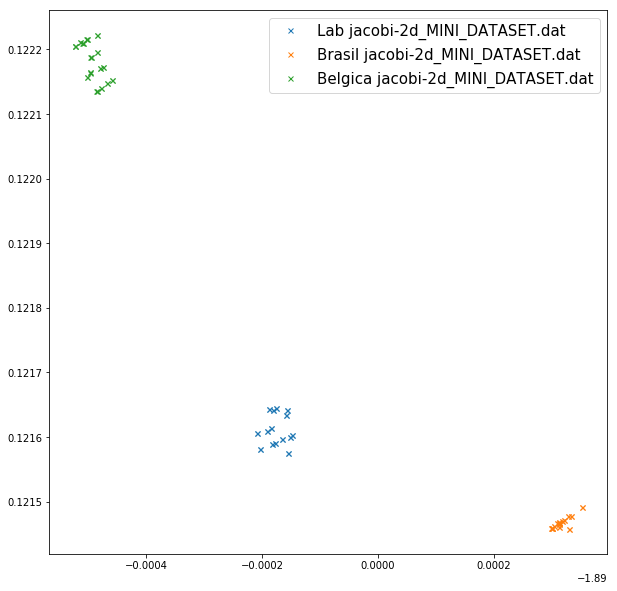

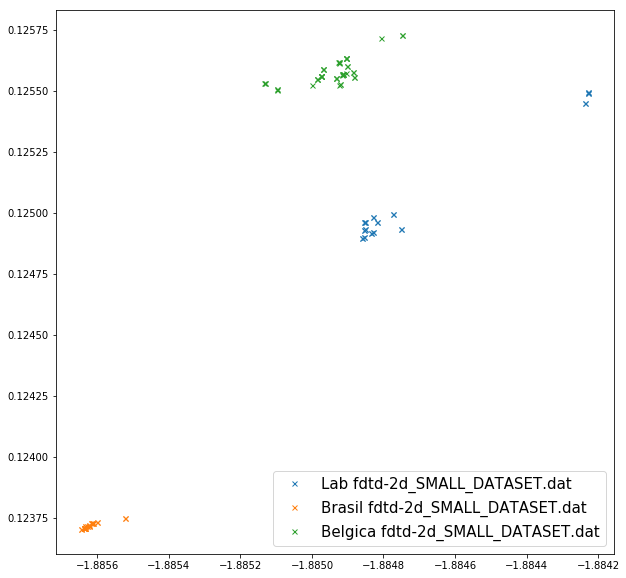

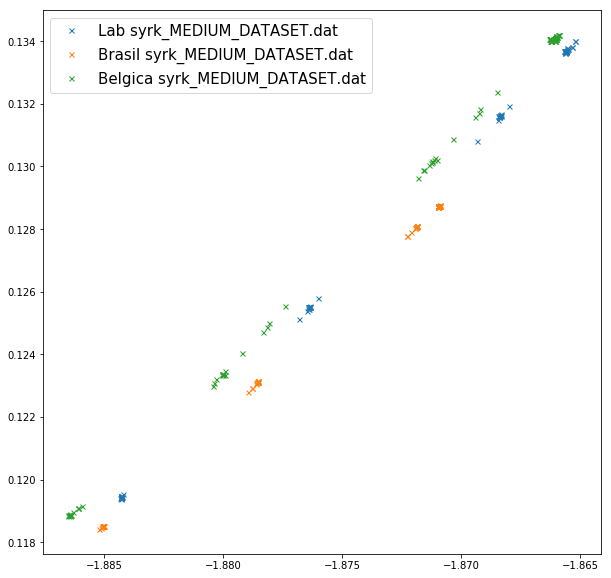

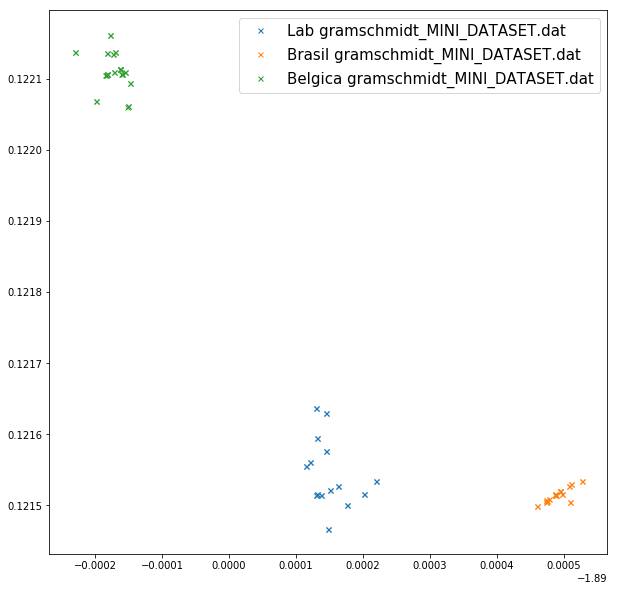

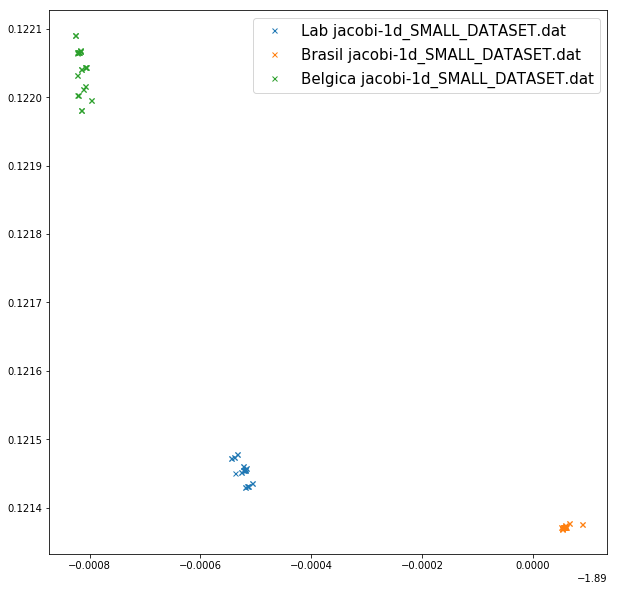

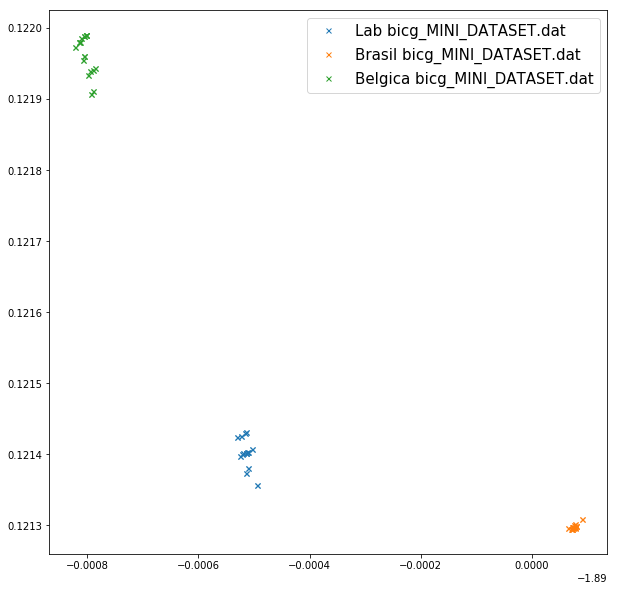

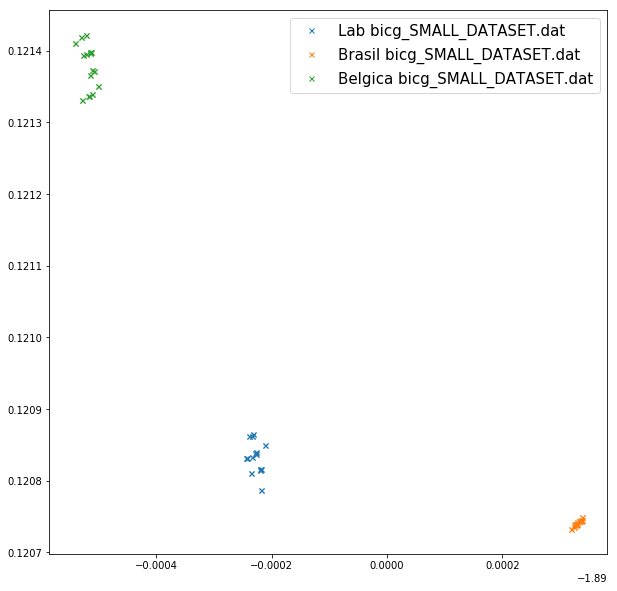

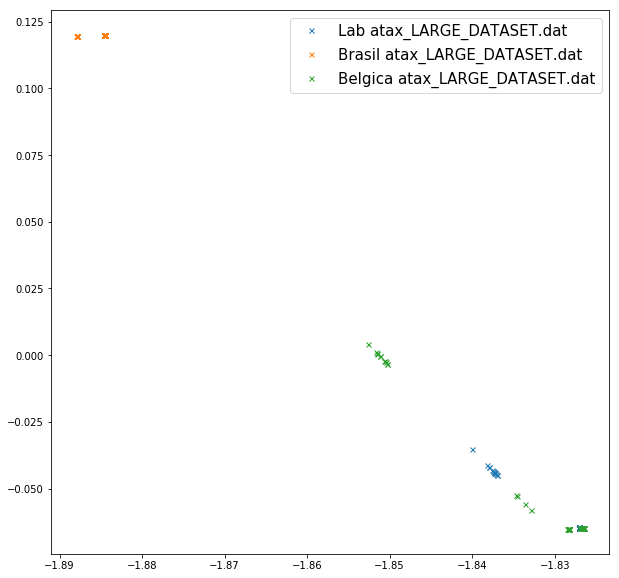

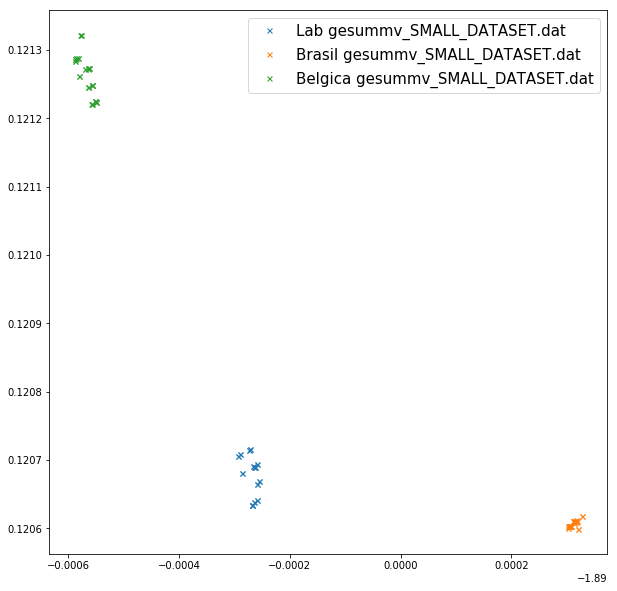

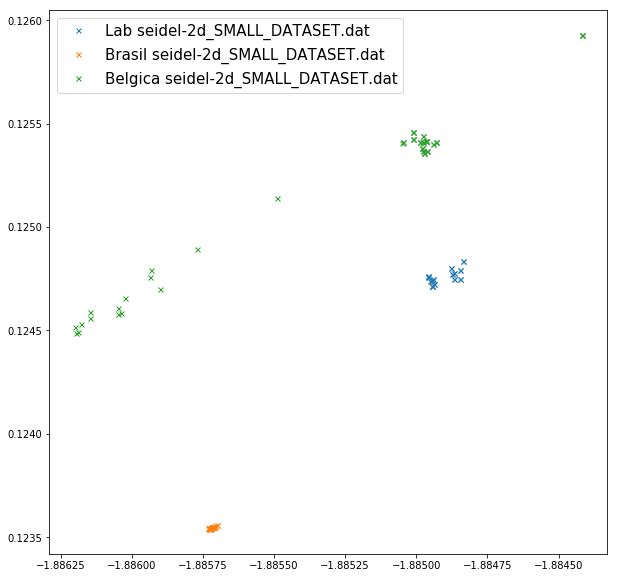

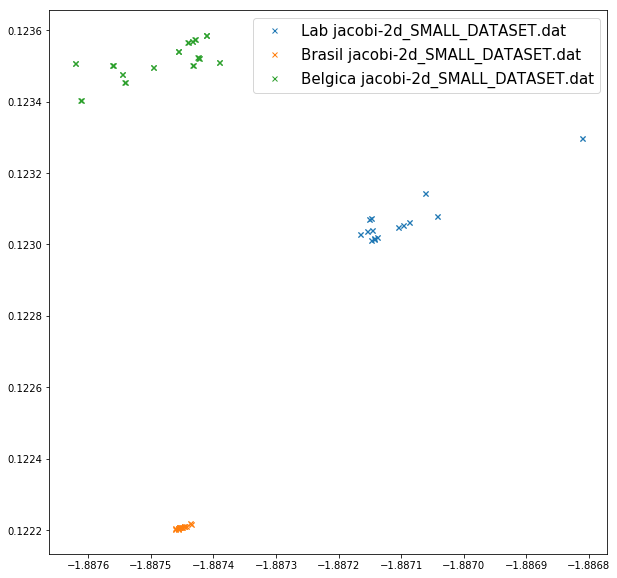

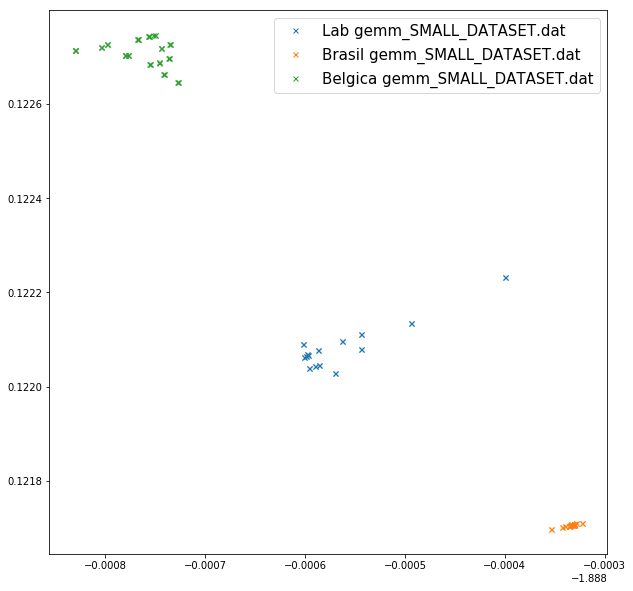

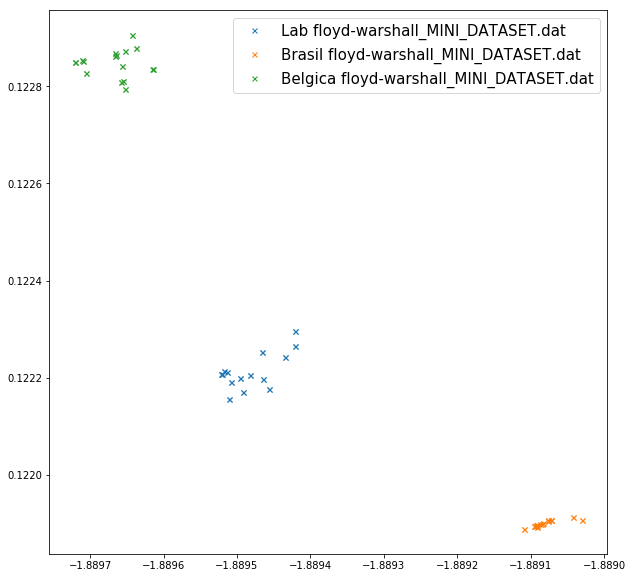

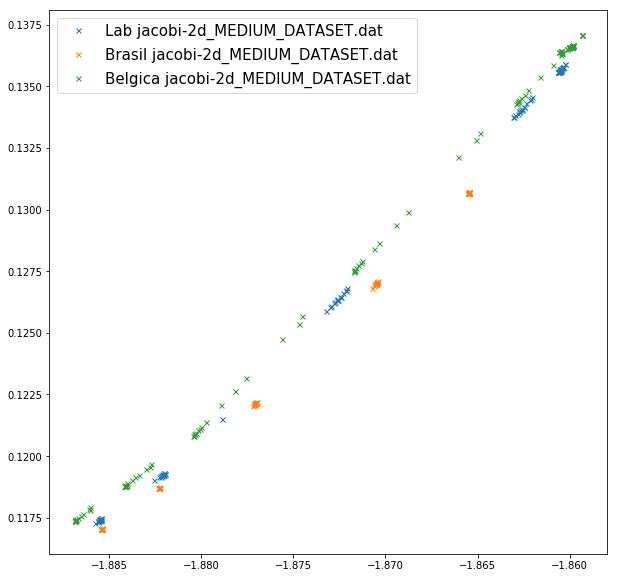

In [221]:
for c in df_reduc['program'].unique():
    plt.figure(figsize=(10,10))
    for d in df_reduc['cluster'].unique():
        aux= df_reduc[ (df_reduc['program']==c)&(df_reduc['cluster']==d) ][['x1','x2']].values
        plt.plot(aux[:,0],aux[:,1],'x', markersize=5,label=d+' '+c)
#plt.title(c)
    plt.legend(fontsize=15)

## Time comparision per cluster

In [8]:
def side_comp(f_list, f_list_name, sbs= False):
    hpc_data= []
    for fx in f_list:
        with open(fx, 'rb+') as f: hpc_data.append(pickle.load(f))
    
    avg_df= []
    std_df= []
    for data in hpc_data:
        avg_df_, std_df_= smooth_df(data['data'], flat_list(data['to_monitor']))
        avg_df.append(avg_df_)
        std_df.append(std_df_)

    to_monitor= set(flat_list(hpc_data[0]['to_monitor']))
    for data in hpc_data[1:]:
        to_monitor&=set(flat_list(data['to_monitor']))
    #to_monitor= ['PERF_COUNT_SW_PAGE_FAULTS']
    
    if sbs:
        for c in to_monitor:
            f, axarr = plt.subplots(1, len(hpc_data), figsize=(20,5))
            for idx in range(len(hpc_data)):
                i= flat_list(hpc_data[idx]['to_monitor']).index(c)
                for r in hpc_data[idx]['data']:
                    aux= np.array(r)
                    axarr[idx].plot(aux[:,i],zorder=0)
                aux= avg_df[idx][c].values
                aux_std= std_df[idx][c].values
                axarr[idx].fill_between(np.arange(aux.shape[0]), aux-3*aux_std, aux+3*aux_std,color='k',zorder=1)
                axarr[idx].plot(aux,c='r',linewidth=0.5)
                axarr[idx].set_title(f_list_name[idx]+' '+c)
    else:
        for c in to_monitor:
            plt.figure(figsize=(10,10))
            for idx in range(len(hpc_data)):
                i= flat_list(hpc_data[idx]['to_monitor']).index(c)
    #             for r in hpc_data[idx]['data']:
    #                 aux= np.array(r)
    #                 axarr[idx].plot(aux[:,i],zorder=0)
                aux= avg_df[idx][c].values
                aux_std= std_df[idx][c].values
                #plt.fill_between(np.arange(aux.shape[0]), aux-3*aux_std, aux+3*aux_std,color='k',zorder=1)
                plt.plot(aux,linewidth=3, label=f_list_name[idx])
            plt.legend()
            plt.title(c)
                #plt.set_title(f_list_name[idx]+' '+c)

/home/vitor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


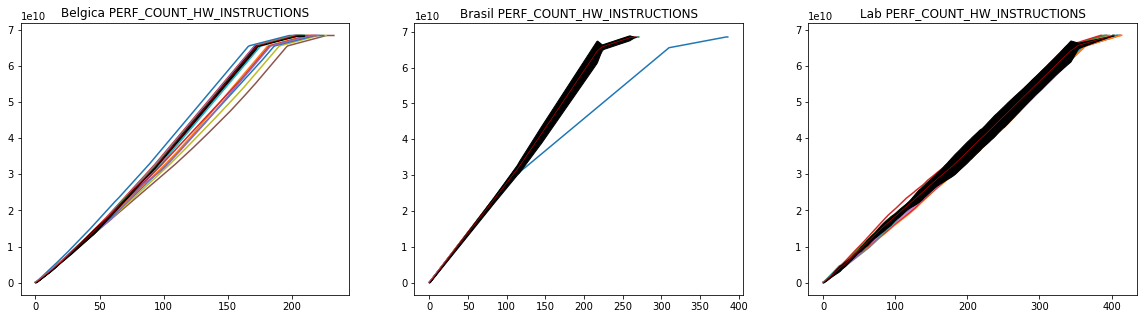

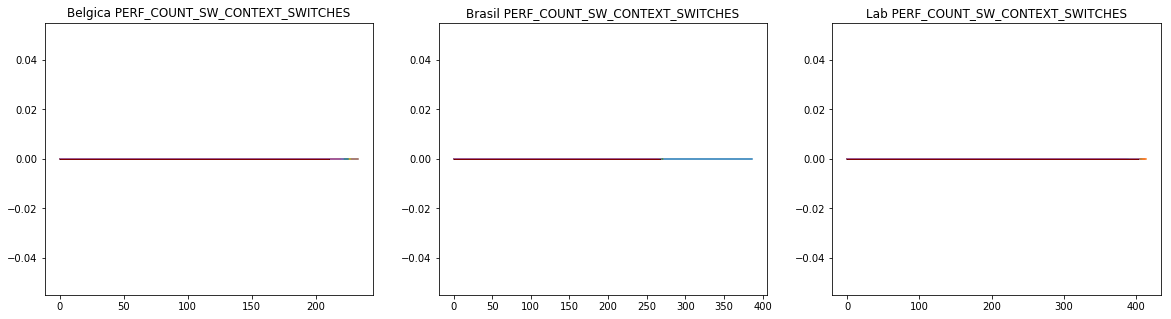

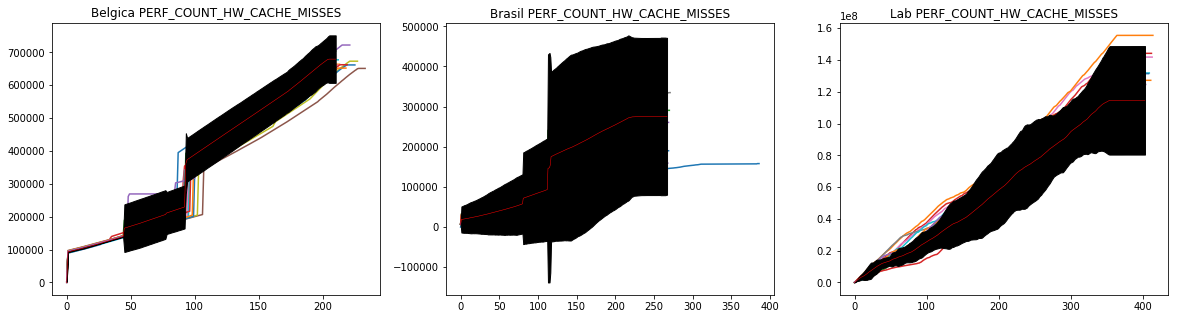

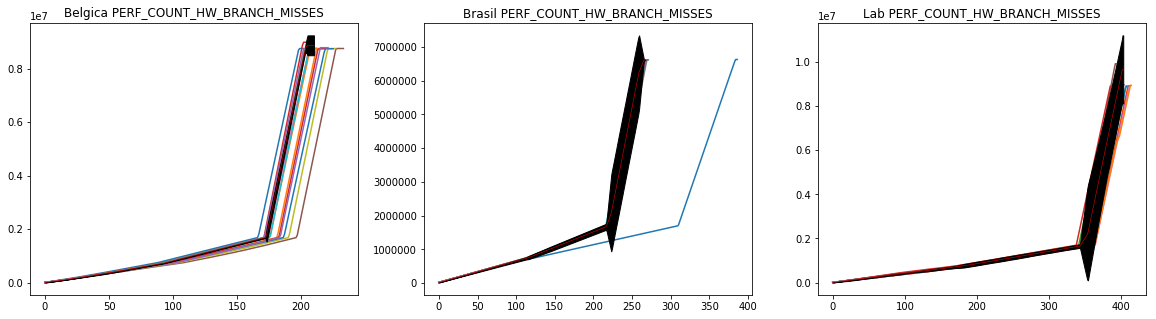

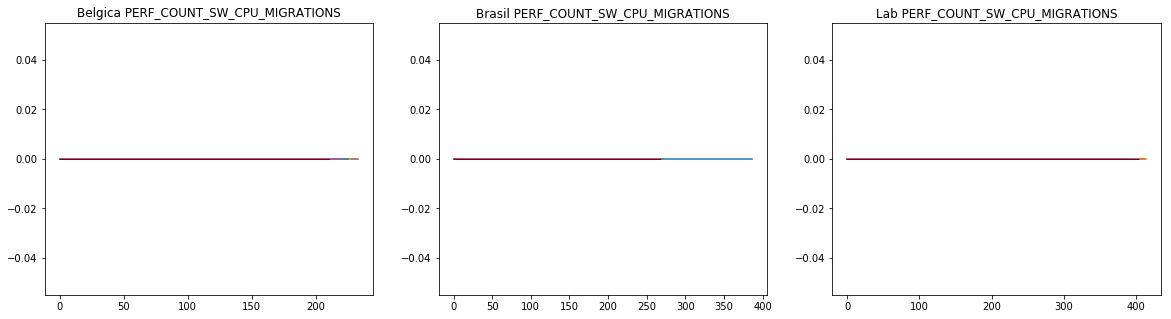

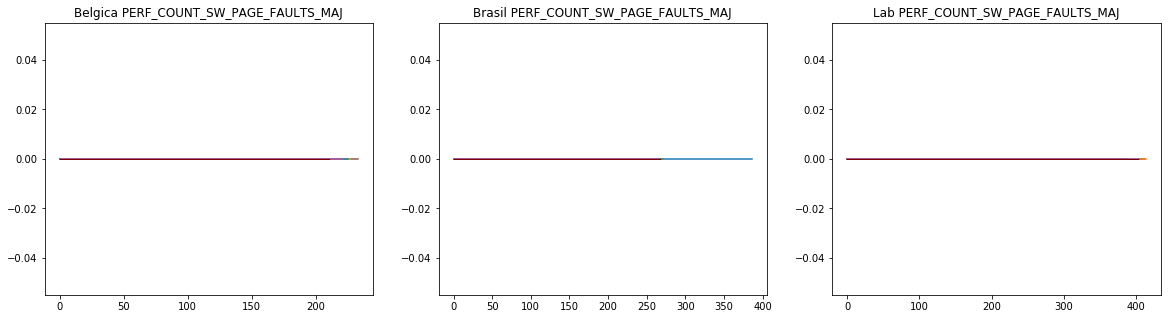

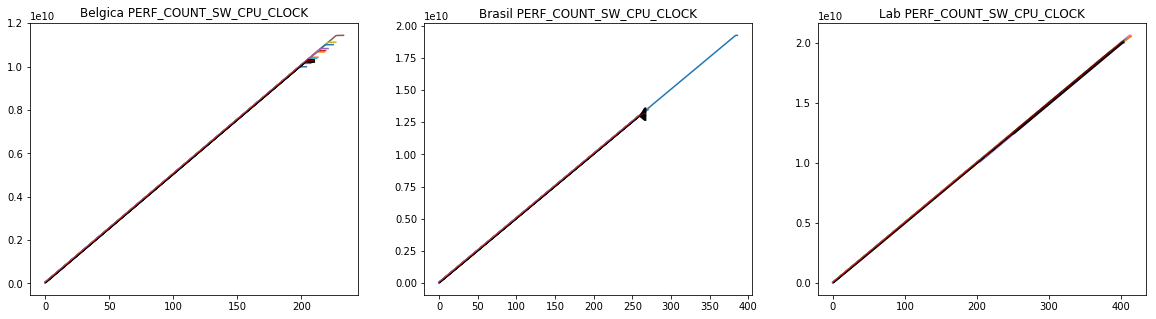

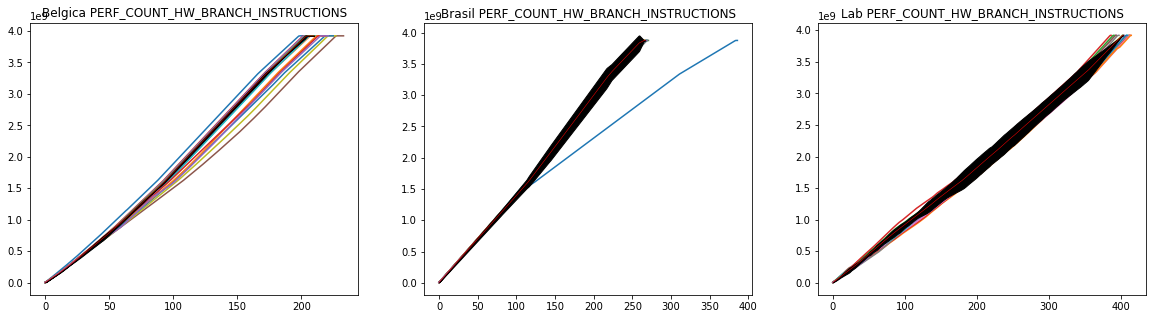

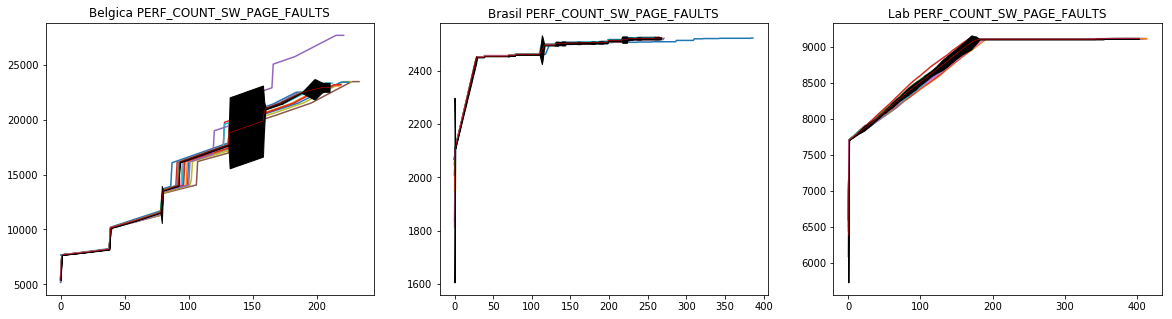

In [9]:
p= '2mm_LARGE_DATASET.dat'
side_comp(['hpc_belgica/'+p,
              'hpc_brasil/'+p, 'pc_lab/'+p],
             ['Belgica', 'Brasil','Lab'],True)

## Time comparison per input size

/home/vitor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


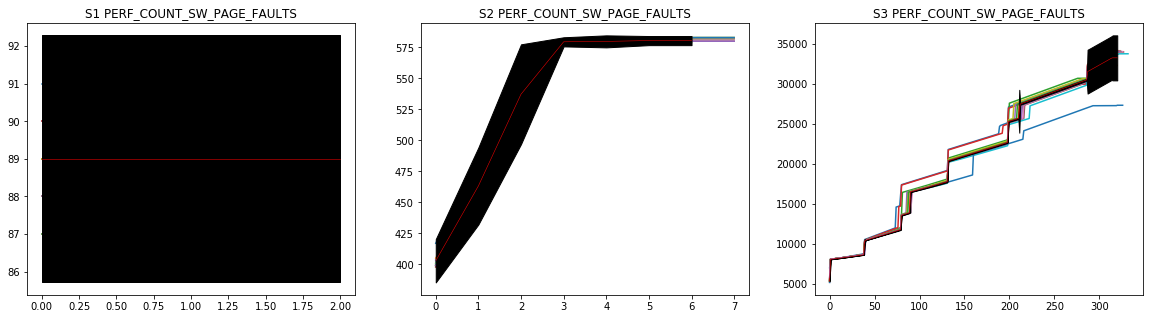

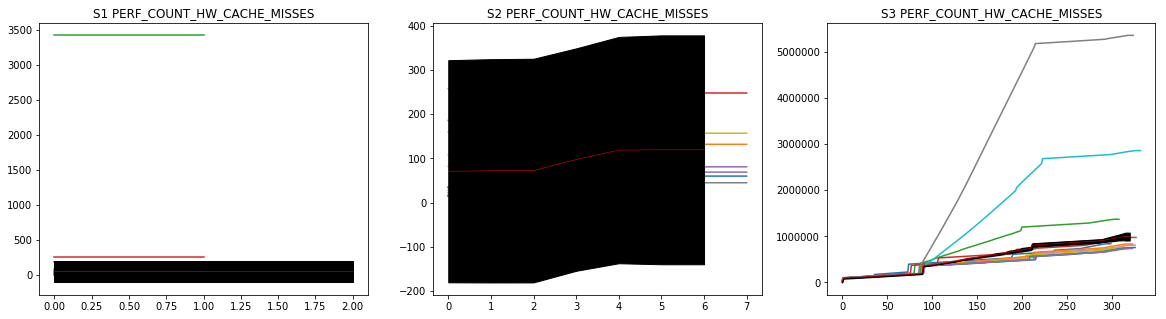

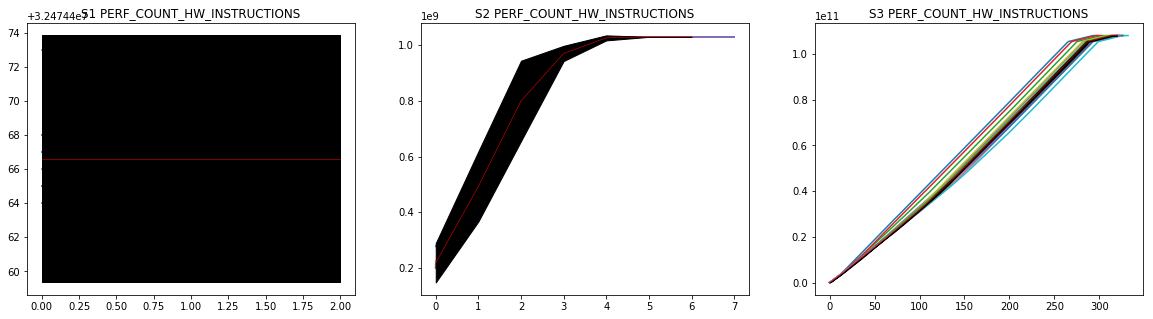

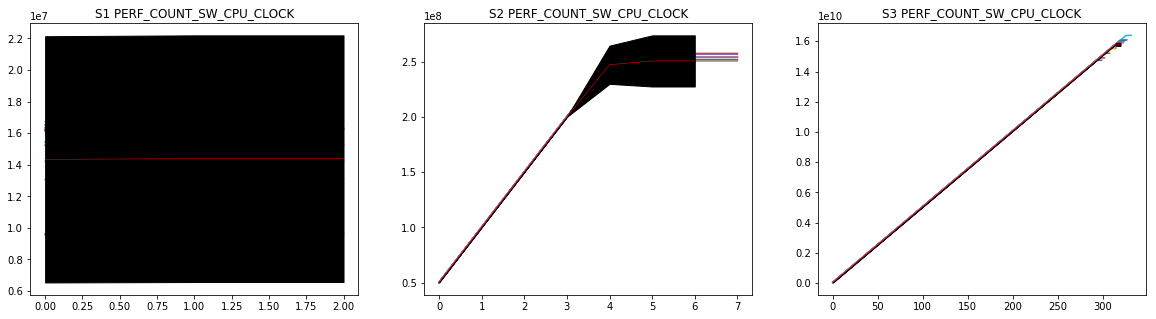

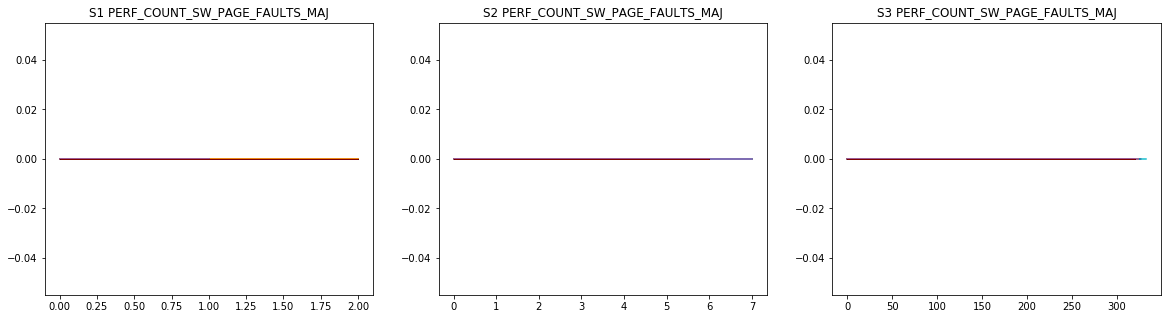

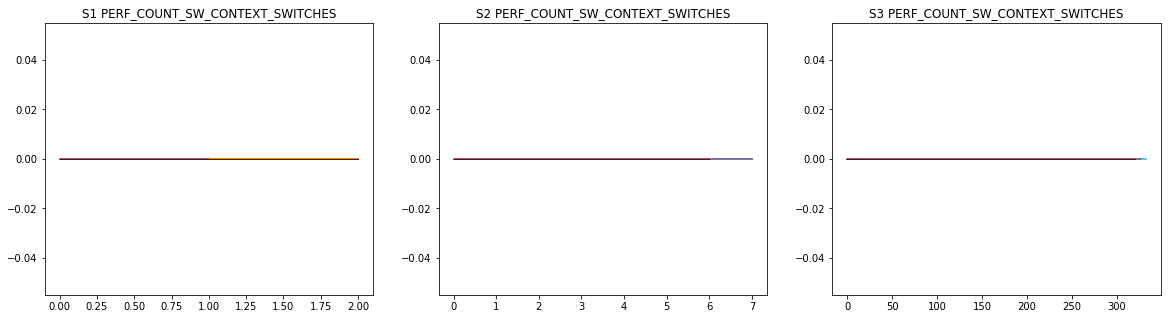

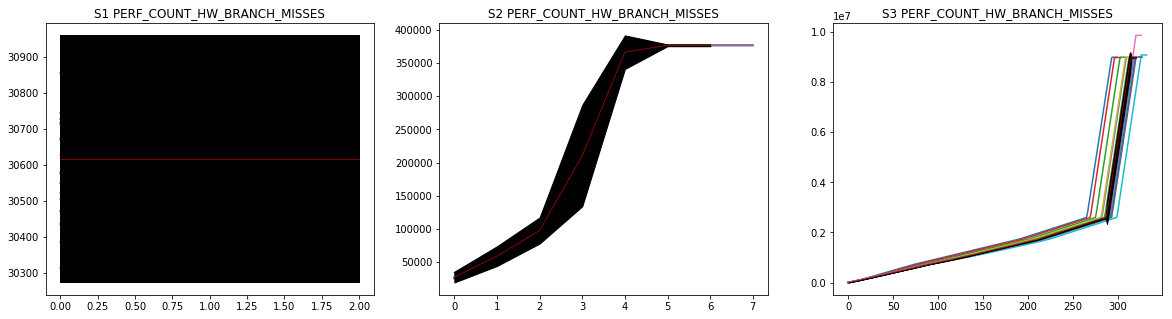

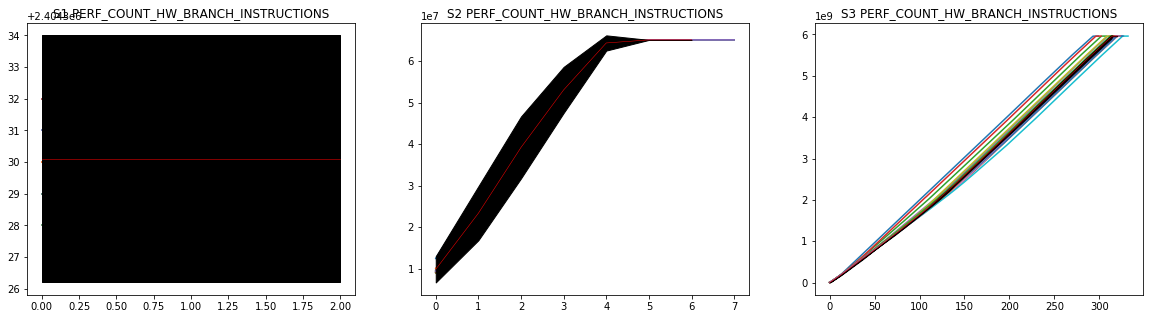

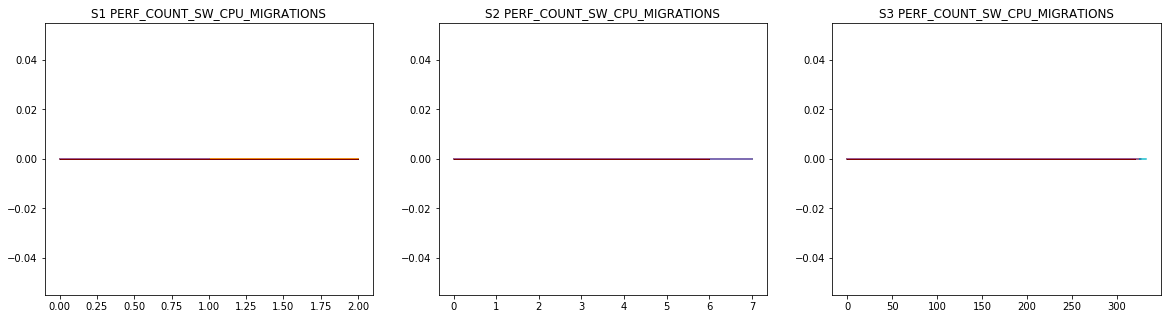

In [43]:
side_comp(['hpc_belgica/'+'3mm_SMALL_DATASET.dat',
              'hpc_belgica/'+'3mm_MEDIUM_DATASET.dat', 'hpc_belgica/'+'3mm_LARGE_DATASET.dat'],
             ['S1', 'S2','S3'],True)

## What happened to page faults?

/home/vitor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/home/vitor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in true_divide
/home/vitor/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


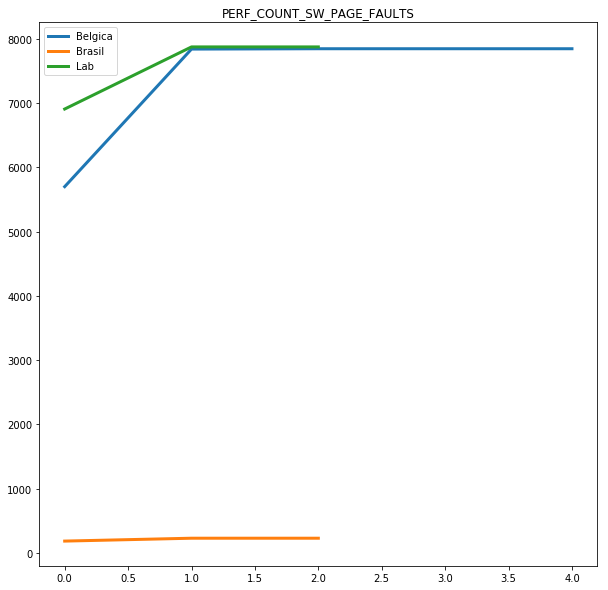

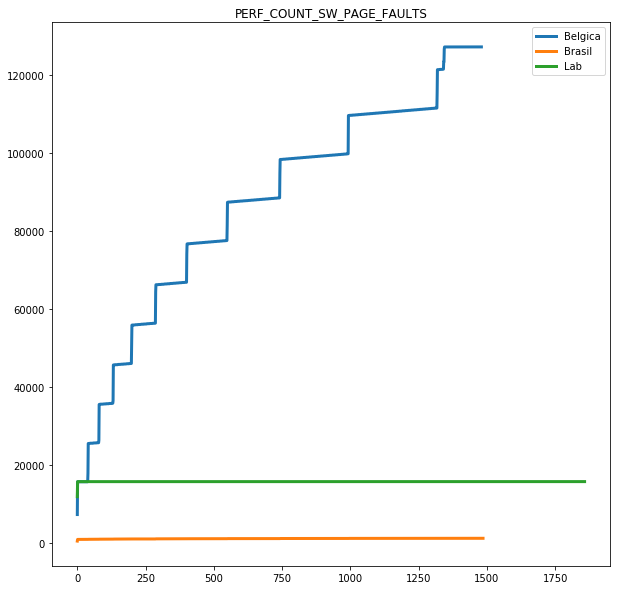

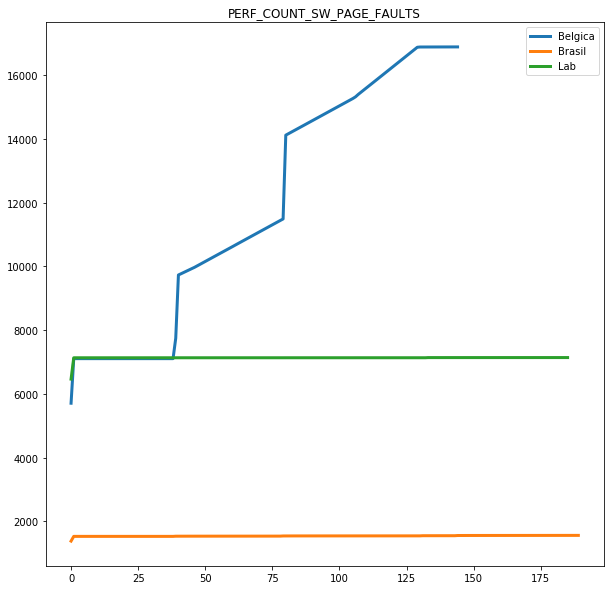

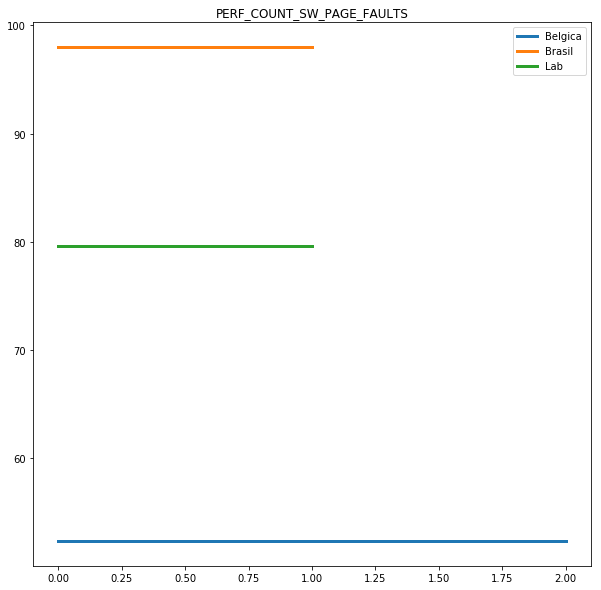

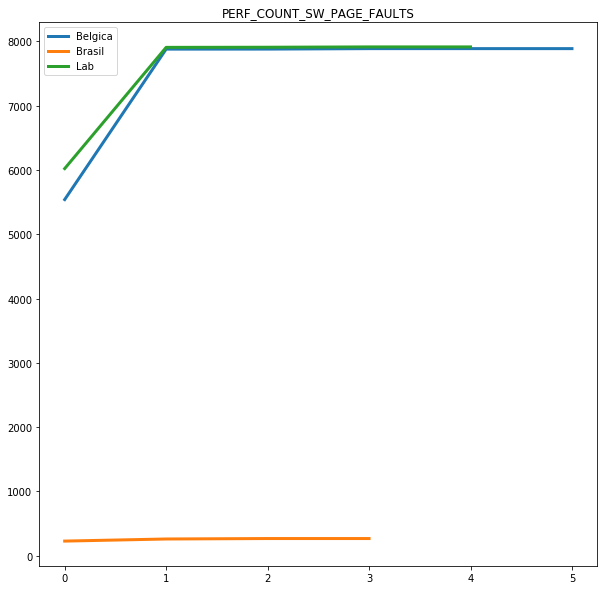

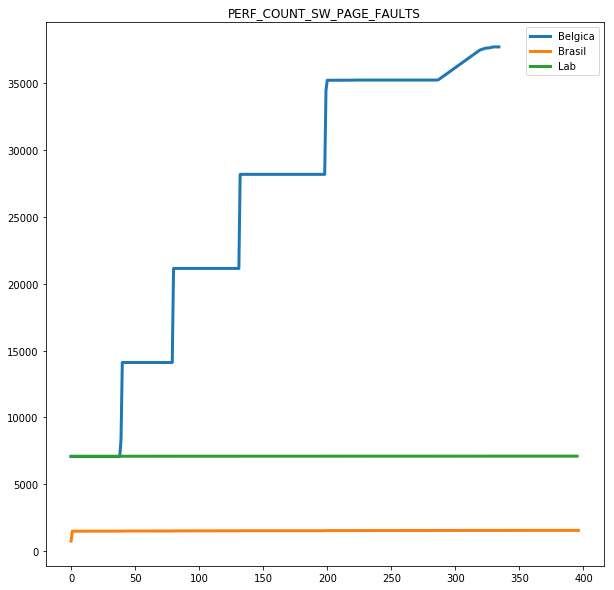

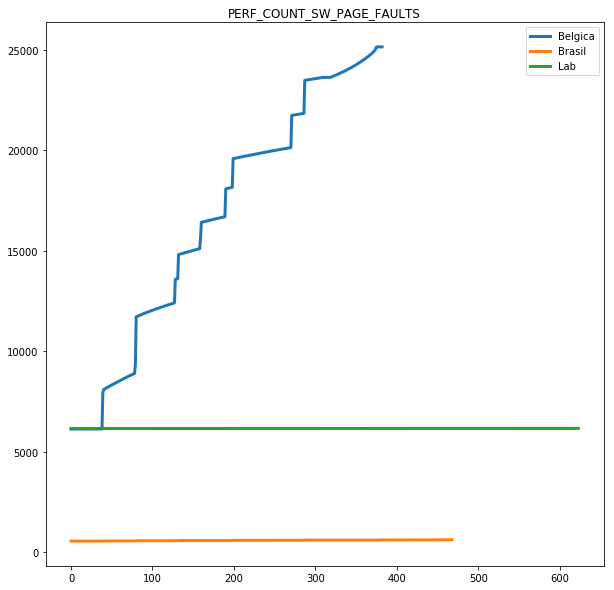

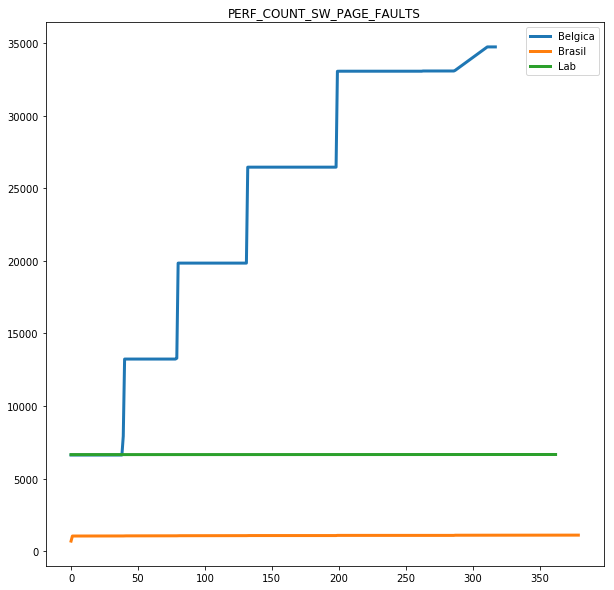

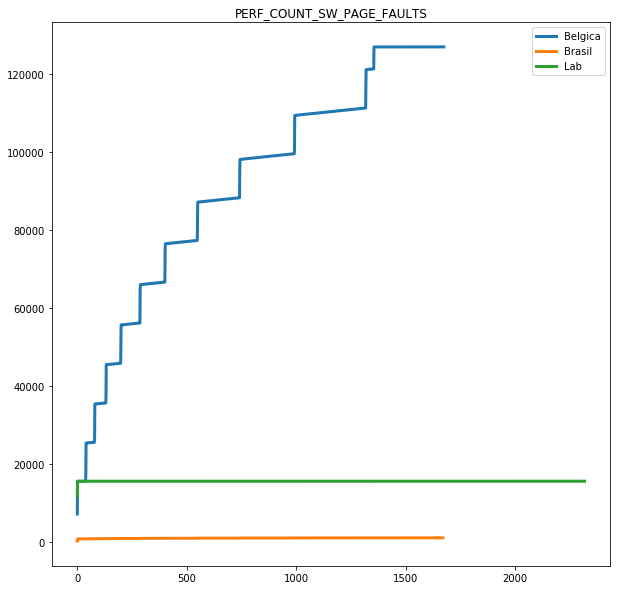

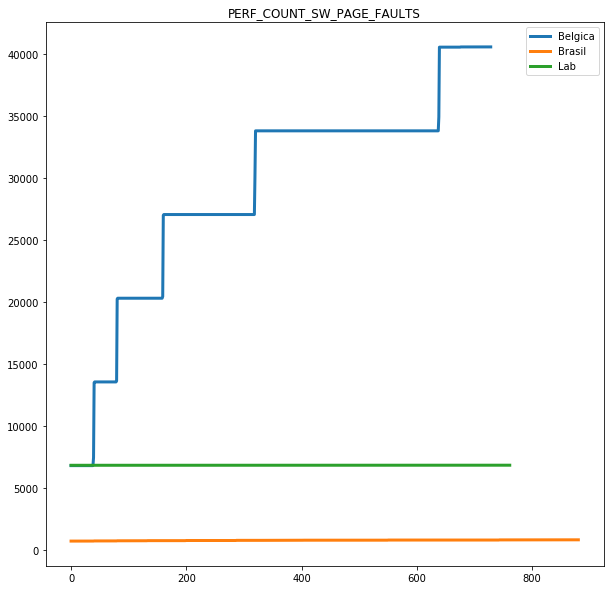

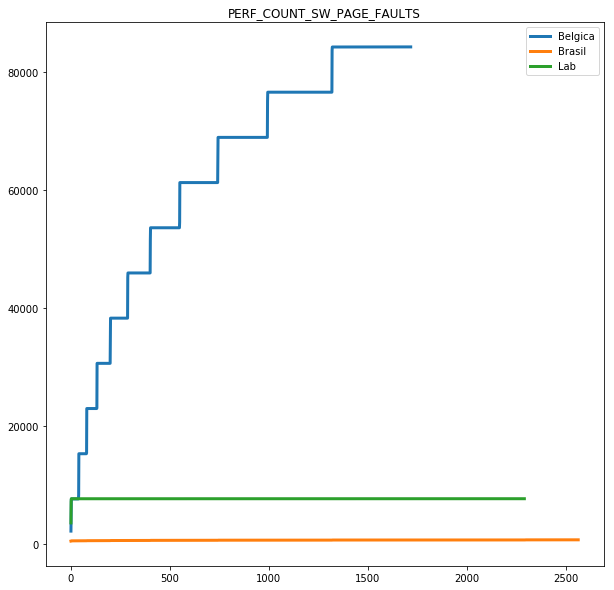

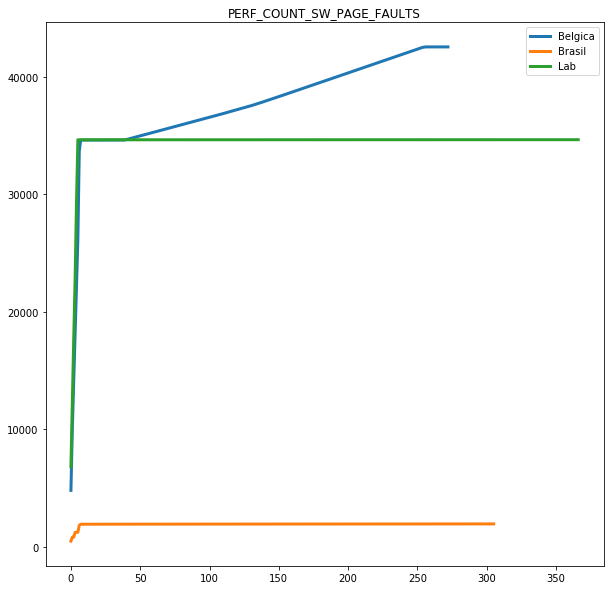

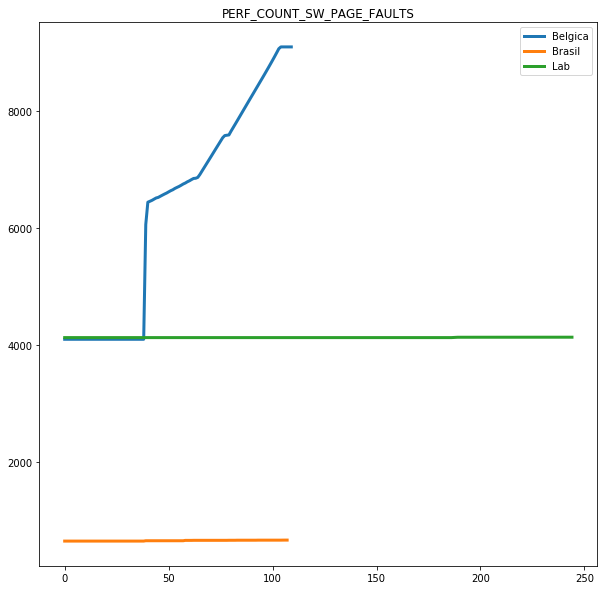

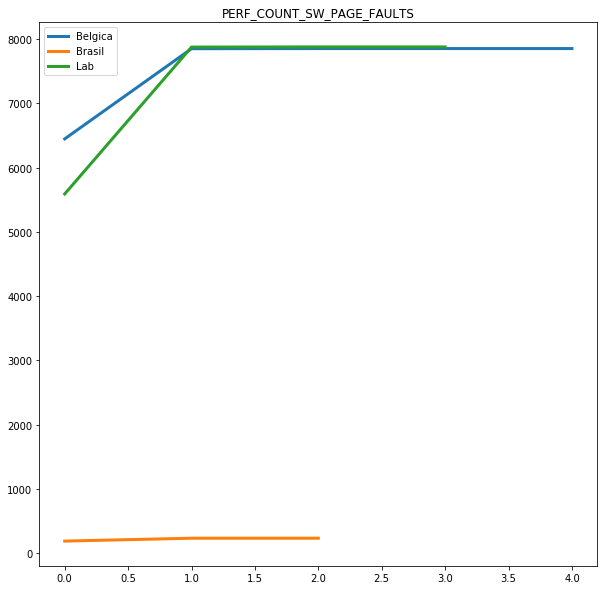

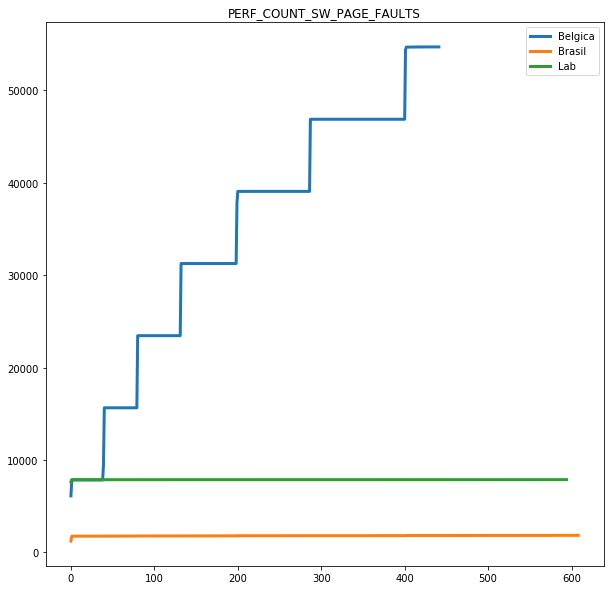

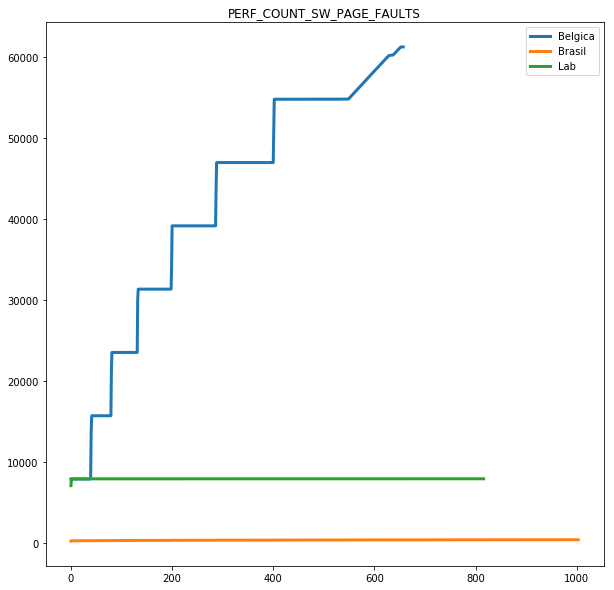

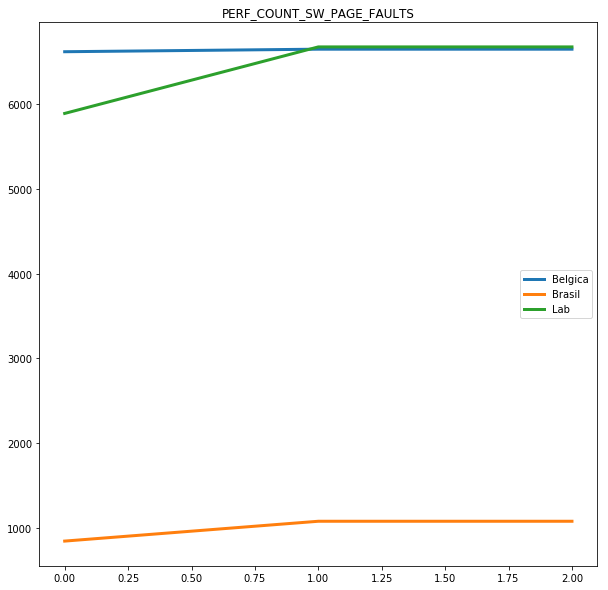

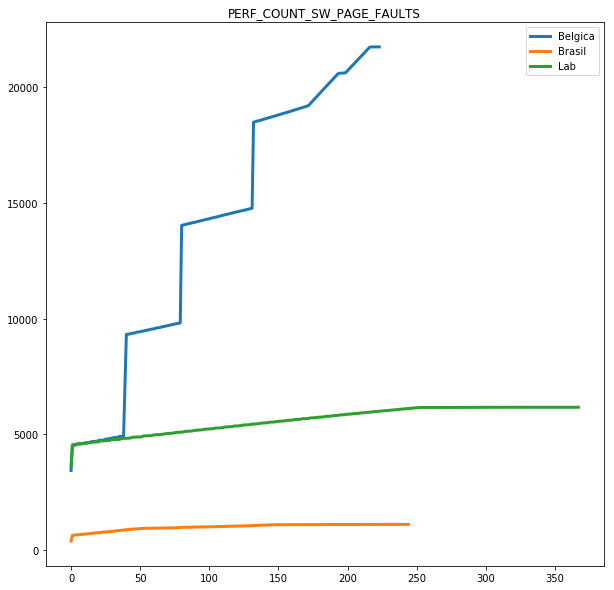

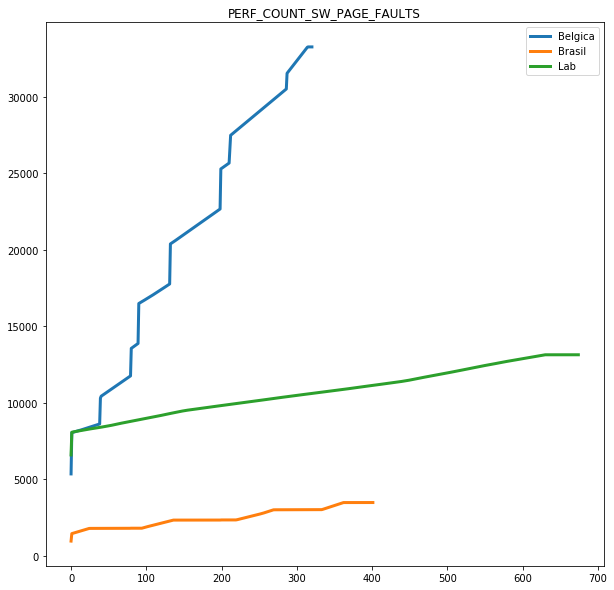

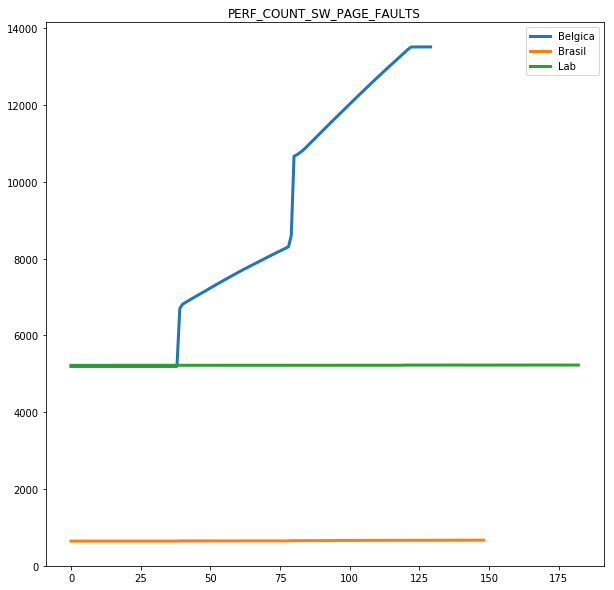

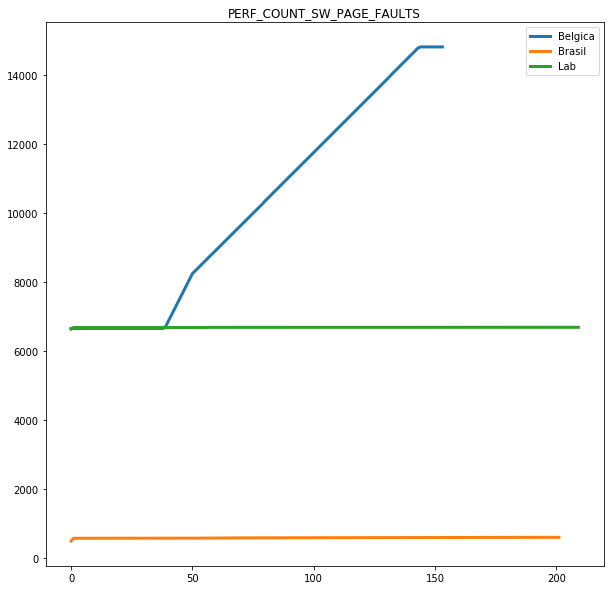

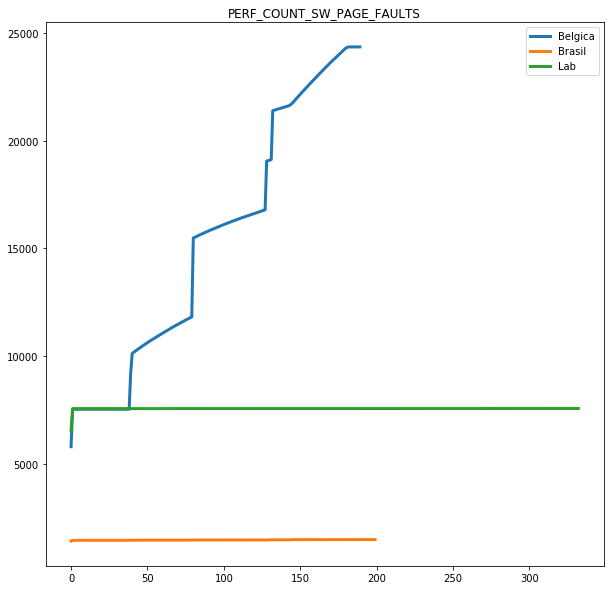

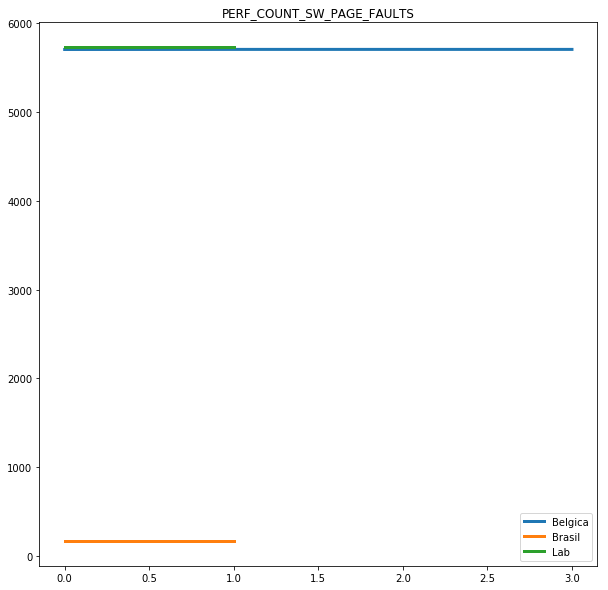

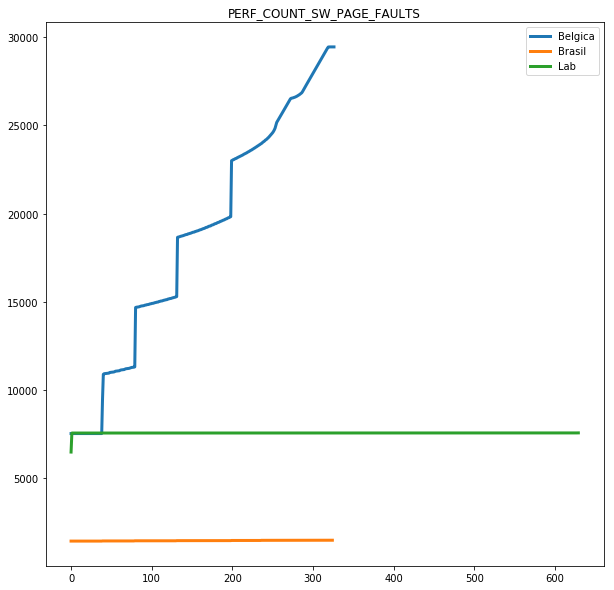

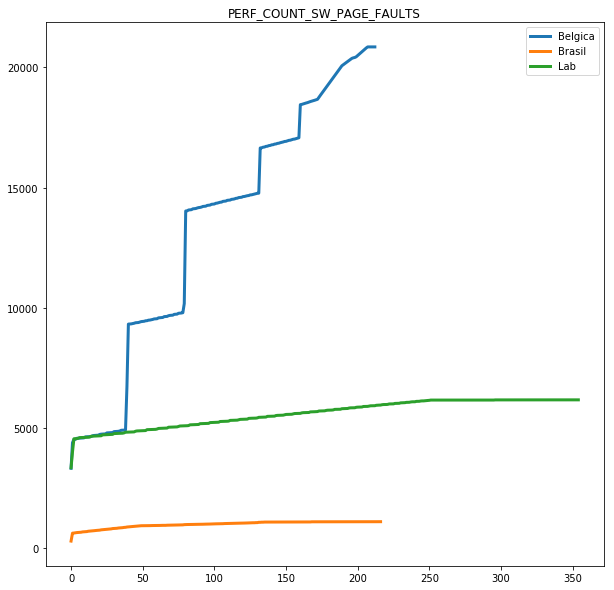

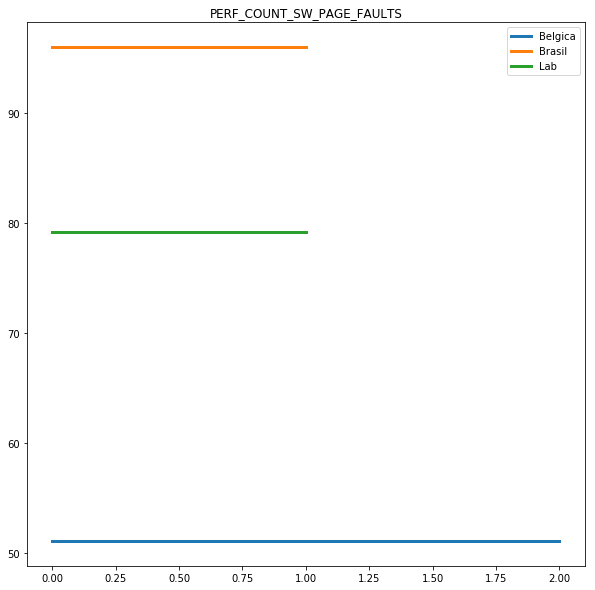

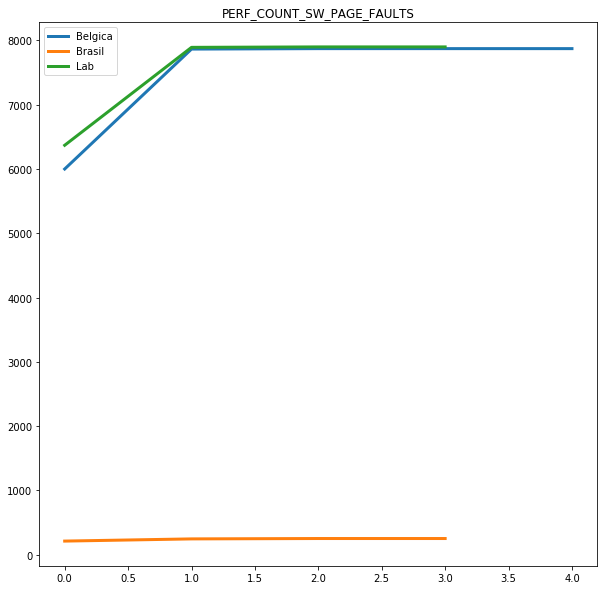

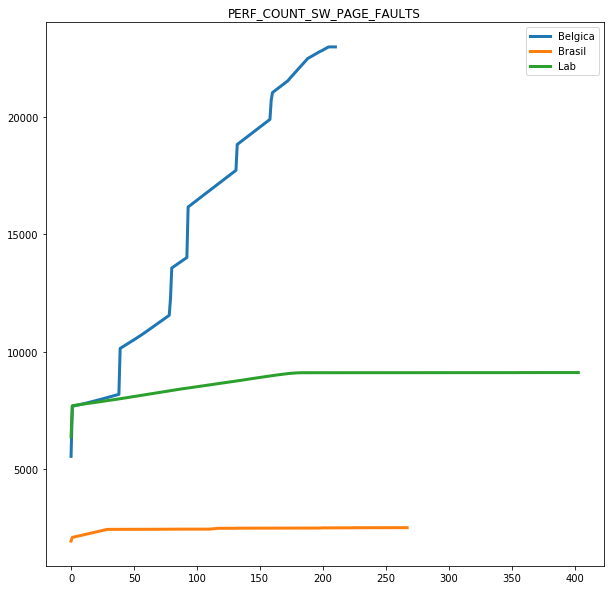

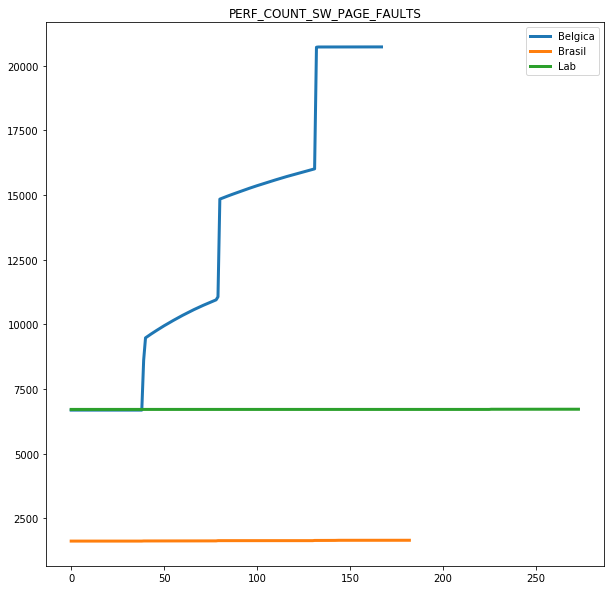

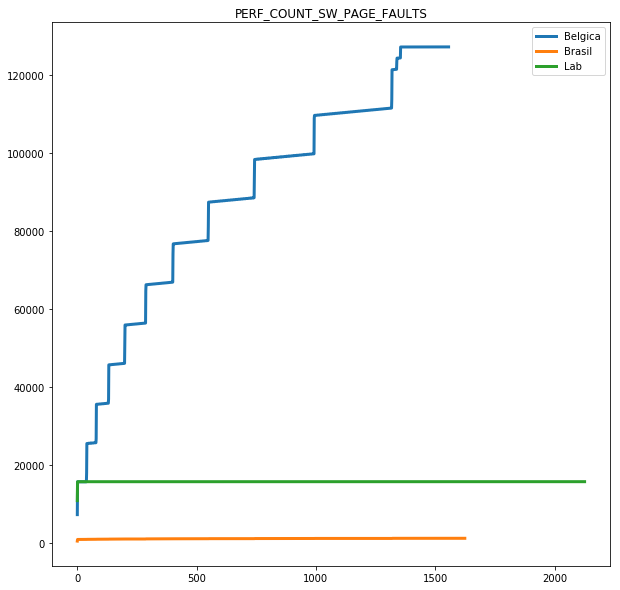

In [37]:
programs= os.listdir('hpc_belgica')
for p in programs:
    if 'LARGE' not in p: continue
    if 'mem' in p: continue
    side_comp(['hpc_belgica/'+p, 
              'hpc_brasil/'+p, 'pc_lab/'+p],
             ['Belgica', 'Brasil','Lab'])
    plt.plot()

## Function comparison

In [38]:

# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
# from sklearn.preprocessing import scale
from ipywidgets import widgets, interactive, Layout

# huge_df= pd.read_csv('huge_df.csv')
# huge_train= huge_df.drop(['SYSTEMWIDE:RAPL_ENERGY_DRAM',
#                           'SYSTEMWIDE:RAPL_ENERGY_PKG',
#                           'SYSTEMWIDE:RAPL_ENERGY_CORES',
#                          'cluster','program','run'],axis=1)
# data= scale(huge_train.values)
# pca= PCA(n_components=2)
# pca.fit(data)
# huge_train.columns

# #print(pca.components_)
# counters= pca.transform(data)
# df_reduc= pd.DataFrame(counters,columns=['x1','x2'])
# df_reduc['cluster']= huge_df['cluster'].values
# df_reduc['program']= huge_df['program'].values
# df_reduc['input']= df_reduc['program'].str.split('_',n=2,expand=True)[1]
# df_reduc['program']= df_reduc['program'].str.split('_',n=2,expand=True)[0]


dd_cluster = widgets.Dropdown(
    options=['All'] + list(df_reduc['cluster'].unique()),
    value='All',
    description='cluster:',
)
dd_program = widgets.Dropdown(
    options=['All'] + list(df_reduc['program'].unique()),
    value='All',
    description='program:',
)
dd_input = widgets.Dropdown(
    options=['All'] + list(df_reduc['input'].unique()),
    value='All',
    description='input:',
)
dd_label = widgets.Dropdown(
    options=['none', 'cluster', 'input', 'program'],
    value='none',
    description='label:',
)

def plotit(dd_cluster, dd_program, dd_input, dd_label):
    plt.figure(figsize=(10,10))
    global df_reduc
    df= df_reduc
    if dd_cluster != 'All':
        df= df[ df['cluster'] == dd_cluster]
    if dd_program != 'All':
        df= df[ df['program'] == dd_program]
    if dd_input != 'All':
        df= df[ df['input'] == dd_input]
    
    if dd_label == 'none':
        aux= df[['x1','x2']].values
        plt.plot(aux[:,0], aux[:,1], 'x',markersize=5)
    else:
        for c in df[dd_label].unique():
            aux= df[df[dd_label]==c].values
            plt.plot(aux[:,0], aux[:,1], 'x',markersize=5, label= c)
        plt.legend()
v= interactive(plotit, dd_cluster=dd_cluster, dd_program=dd_program, dd_input=dd_input, dd_label=dd_label)
# output = v.children[-1]
# output.layout.height = '850px'
v

interactive(children=(Dropdown(description='cluster:', options=('All', 'Lab', 'Brasil', 'Belgica'), value='All…

In [357]:

import cv2

def find_afineT(P, Pr):
    err = lambda p, x, y, d, y2: p[0]*x+p[1]*y+d*p[2]+(1-d)*p[3]-y2
    p0= np.ones(4)
    Xt= np.hstack( [P[:,0],P[:,1]] )
    Yt= np.hstack( [P[:,1],-P[:,0]] )
    Zt= np.hstack( [Pr[:,0], Pr[:,1]] )
    d= np.hstack( [np.ones(P[:,0].shape), np.zeros(P[:,1].shape)] )
    res= least_squares(err, p0, loss='soft_l1', f_scale=1, args=(Xt, Yt, d, Zt))
    R= np.array([
        [res.x[0], res.x[1], res.x[2]],
        [-res.x[1], res.x[0], res.x[3]],
        [0, 0, 1]
    ])
    return R

def comp_func(x0, y0, y1):
    h= np.ones(y0.shape)
    P1= np.hstack( [x0,y0,h] ).reshape((-1,3),order='F')
    P2= np.hstack( [x0,y1,h] ).reshape((-1,3),order='F')
    R, _= cv2.findHomography(np.float32(P1[:,0:2]), np.float32(P2[:,0:2]))
    if type(R) == type(None):
        return 0, 0
    return R.dot(P1.T).T, np.mean( np.abs(R.dot(P1.T).T-P2) )

def side_comp(f_list, f_list_name, sbs= False):
    hpc_data= []
    for fx in f_list:
        with open(fx, 'rb+') as f: hpc_data.append(pickle.load(f))
    
    avg_df= []
    std_df= []
    for data in hpc_data:
        avg_df_, std_df_= smooth_df(data['data'], flat_list(data['to_monitor']))
        avg_df.append(avg_df_)
        std_df.append(std_df_)

    to_monitor= set(flat_list(hpc_data[0]['to_monitor']))
    for data in hpc_data[1:]:
        to_monitor&=set(flat_list(data['to_monitor']))
    to_monitor= ['PERF_COUNT_HW_INSTRUCTIONS']
    
    if sbs:
        for c in to_monitor:
            f, axarr = plt.subplots(1, len(hpc_data), figsize=(20,5))
            
            for idx in range(len(hpc_data)):
                i= flat_list(hpc_data[idx]['to_monitor']).index(c)
                aux= avg_df[idx][c].values
                aux_std= std_df[idx][c].values
                #axarr[idx].fill_between(np.arange(aux.shape[0]), aux-3*aux_std, aux+3*aux_std,color='k',zorder=1)
            
                for idx2 in range(len(hpc_data)):
                    #axarr[idx2].plot(aux,linewidth=1,label=f_list_name[idx2])
                    #if idx == idx2: continue
                    lenx0= min(len(avg_df[idx][c].values),len(avg_df[idx2][c].values))
                    def my_sample(x, n):
                        step= len(x)//n
                        x=x[::step]
                        #to_remove= np.random.choice(range(len(x)-1), len(x)-n, replace=False)
                        to_remove= range(len(x)-n)
                        y= np.delete(x,to_remove)
                        #print(len(y))
                        return y
                    
                    s_size= 50 #min(avg_df[idx][c].shape[0], avg_df[idx2][c].shape[0])
                    x0= np.arange(0,s_size,1)
                    #y0= np.hstack( [avg_df[idx][c].values[:70], avg_df[idx][c].values[-70:]] ) #sp_samples(avg_df[idx][c].values, lenx0
                    #y1= np.hstack( [avg_df[idx2][c].values[:70], avg_df[idx2][c].values[-70:]] ) #sp_samples(avg_df[idx2][c].values, lenx0)
                    y0= my_sample(avg_df[idx][c].values, s_size)
                    y1= my_sample(avg_df[idx2][c].values, s_size)
                    if lenx0 > 3:
                        ty, eps= comp_func(x0, y0, y1)
                        print(eps)
                        if type(ty) != int:
                            axarr[idx].plot(ty[:,0],ty[:,1],linewidth=1,label='Tr%s'%idx2)
                            pass
                            #axarr[idx].plot(x0,y1,linewidth=1,label='Trx')
                
            axarr[idx].set_title(f_list_name[idx]+' '+c)
            axarr[idx].legend()
    else:
        for c in to_monitor:
            plt.figure(figsize=(10,10))
            for idx in range(len(hpc_data)):
                i= flat_list(hpc_data[idx]['to_monitor']).index(c)
                aux= avg_df[idx][c].values
                aux_std= std_df[idx][c].values
                #plt.fill_between(np.arange(aux.shape[0]), aux-3*aux_std, aux+3*aux_std,color='k',zorder=1)
                plt.plot(aux,linewidth=3, label=f_list_name[idx])
            plt.legend()
            plt.title(c)

/home/vitor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


0.0001653480530881013
103392408.27455533
614204587.8202561
102109715.12048264
0.0006387774153530018
1528221431.3838174
14655295901.567743
223196722937.689
0.0014603503555549158


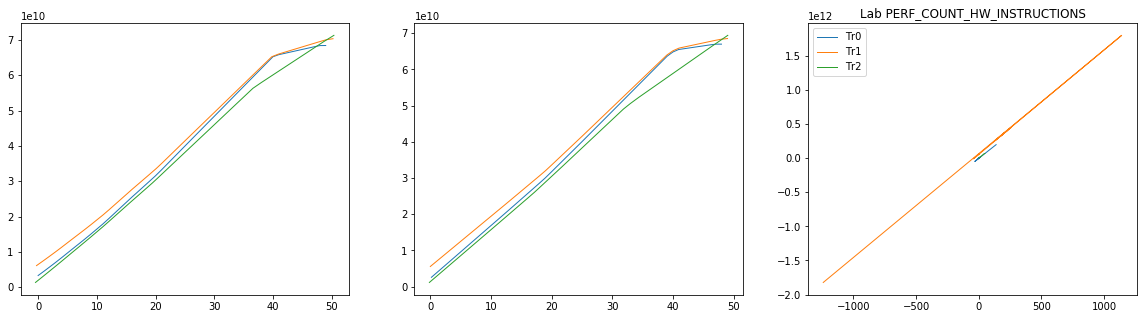

In [358]:
p= '2mm_LARGE_DATASET.dat'
side_comp(['hpc_belgica/'+p,'hpc_brasil/'+p, 'pc_lab/'+p], ['Belgica', 'Brasil','Lab'], True)

/home/vitor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


Belgica
0.0001653480530881013
Brasil
103392408.27455533
Lab
614204587.8202561
Belgica
102109715.12048264
Brasil
0.0006387774153530018
Lab
1528221431.3838174
Belgica
14655295901.567743
Brasil
223196722937.689
Lab
0.0014603503555549158


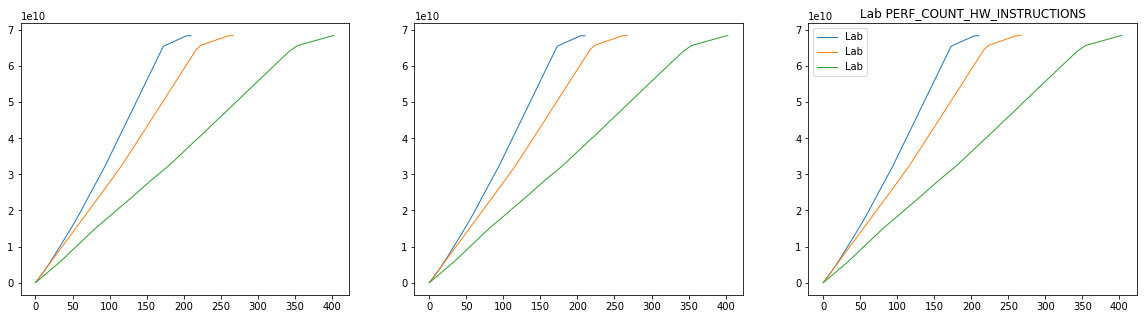

In [352]:
p= '2mm_LARGE_DATASET.dat'
side_comp(['hpc_belgica/'+p,'hpc_brasil/'+p, 'pc_lab/'+p], ['Belgica', 'Brasil','Lab'], True)

## Input size definiton

In [35]:
programs= os.listdir('hpc_belgica')
huge_df= pd.DataFrame()
for p in tqdm(programs):
    if not 'mem' in p: continue
    clusters= ['hpc_belgica/'+p, 'hpc_brasil/'+p, 'pc_lab/'+p]
    clusters_name= ['Belgica', 'Brasil','Lab']
    for c, cname in zip(clusters, clusters_name):
        with open(c,'rb+') as fname:
            data= pickle.load(fname)
        dfs= pd.DataFrame()
        df, _= smooth_df(data['data'], flat_list(data['to_monitor']))
        df['program']= p
        dfs= pd.concat([df,dfs])        
#         for i, d in enumerate(data['data']):
#             df= pd.DataFrame(d, columns=flat_list(data['to_monitor']))
#             df['run']= i
#             df['program']= p
#             dfs= pd.concat([df,dfs])
        dfs['cluster']= cname
        huge_df= pd.concat([dfs,huge_df])
huge_df.to_csv('huge_df_mem.csv')

  0%|          | 0/240 [00:00<?, ?it/s]/home/vitor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide
/home/vitor/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

100%|██████████| 240/240 [00:38<00:00,  6.31it/s]


In [7]:
huge_df_mem= pd.read_csv('huge_df_mem.csv')

In [5]:
huge_df.columns #['PERF_COUNT_HW_INSTRUCTION']/huge_df['MEM_UOPS_RETIRED:ALL_LOADS']

Index(['Unnamed: 0', 'PERF_COUNT_HW_BRANCH_INSTRUCTIONS',
       'PERF_COUNT_HW_BRANCH_MISSES', 'PERF_COUNT_HW_CACHE_MISSES',
       'PERF_COUNT_HW_INSTRUCTIONS', 'PERF_COUNT_SW_CONTEXT_SWITCHES',
       'PERF_COUNT_SW_CPU_CLOCK', 'PERF_COUNT_SW_CPU_MIGRATIONS',
       'PERF_COUNT_SW_PAGE_FAULTS', 'PERF_COUNT_SW_PAGE_FAULTS_MAJ',
       'SYSTEMWIDE:RAPL_ENERGY_CORES', 'SYSTEMWIDE:RAPL_ENERGY_DRAM',
       'SYSTEMWIDE:RAPL_ENERGY_PKG', 'cluster', 'program', 'run'],
      dtype='object')

In [8]:
huge_df_mem

Unnamed: 0  FP_ARITH_INST_RETIRED:SCALAR  FP_COMP_OPS_EXE:X87  \
0               0                           NaN           10460057.5   
1               1                           NaN           12282615.5   
2               2                           NaN           12282615.5   
3               3                           NaN           12282615.5   
4               4                           NaN           12282615.5   
5               5                           NaN           12282615.5   
6               6                           NaN           12282615.5   
7               7                           NaN           12282615.5   
8               8                           NaN           12282615.5   
9               9                           NaN           12282615.5   
10             10                           NaN           12282615.5   
11             11                           NaN           12282615.5   
12             12                           NaN           12282615.5   
13             13                           NaN           12282615.5   
14             14                           NaN           12282615.5   
15             15                           NaN           12282615.5   
16             16                           NaN           12282629.0   
17             17                           NaN           12282629.0   
18             18                           NaN           12282629.0   
19             19                           NaN           12282638.0   
20             20                           NaN           12282638.0   
21             21                           NaN           12282638.0   
22             22                           NaN           12282638.0   
23             23                           NaN           12282638.0   
24             24                           NaN           12282638.0   
25             25                           NaN           12282638.0   
26             26                           NaN           12282638.0   
27             27                           NaN           12282638.0   
28             28                           NaN           12282638.0   
29             29                           NaN           12282638.0   
...           ...                           ...                  ...   
44089         277                  6.598402e+09                  NaN   
44090         278                  6.598402e+09                  NaN   
44091         279                  6.598402e+09                  NaN   
44092         280                  6.598402e+09                  NaN   
44093         281                  6.598402e+09                  NaN   
44094         282                  6.598402e+09                  NaN   
44095         283                  6.598402e+09                  NaN   
44096         284                  6.598402e+09                  NaN   
44097         285                  6.598402e+09                  NaN   
44098         286                  6.598402e+09                  NaN   
44099         287                  6.598402e+09                  NaN   
44100         288                  6.598402e+09                  NaN   
44101         289                  6.598402e+09                  NaN   
44102         290                  6.598402e+09                  NaN   
44103         291                  6.598402e+09                  NaN   
44104         292                  6.598402e+09                  NaN   
44105         293                  6.598402e+09                  NaN   
44106         294                  6.598402e+09                  NaN   
44107         295                  6.598402e+09                  NaN   
44108         296                  6.598402e+09                  NaN   
44109         297                  6.598402e+09                  NaN   
44110         298                  6.598402e+09                  NaN   
44111         299                  6.598402e+09                  NaN   
44112         300                  6.598402e+09